# **Stable Diffusion diversity evaluation**  


## Load packages.

In [1]:
from PIL import Image
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from multiprocessing.pool import ThreadPool as Pool
from pathlib import Path

In [2]:
!pip install h5py==2.7.0 Keras==2.0.8 keras_vggface==0.3 numpy==1.13.1 imutils==0.4.3 matplotlib==2.0.2 scipy==0.19.0 Pillow==4.2.1 dlib==19.6.0 scikit_learn==0.19.0

## Identify an experiment folder and list all the folders containing experimental images. 
### Here we assume that each experiment results are located in the separate subfolder of experiment folder and that in we have subsubfolders for each mode. We also assume that experiment names are provided in format: prompt \_number of produced images\_ random number.

### For example, images for experiment with prompt butterfly, mode f\_mode\_cap and 1000 images per mode can be located in folder butterfly_1000_29244847728/f_mod/.

In [ ]:
experiments_folder = 'stable-diffusion/ee/'

image_folders = []
for f in os.listdir(experiments_folder):
    if f.find('batch') != -1:
        e = experiments_folder + f
        for s in os.listdir(e):
            if len(os.listdir(e + '/' + s + '/')) > 500:
                image_folders += [e + '/' + s + '/']
                print(e + '/' + s + '/', len(os.listdir(e + '/' + s + '/')))

## Diversity metrics. 

In [35]:
def res__(batches, function, split_parts=5):
    b_old = len(batches)//split_parts
    print("split parts", b_old)
    
    pl2 = Pool(b_old)
    results = pl2.map(function, batches[0:b_old])
    
    pl2.close()
    pl2.join()
    for i in range(1, split_parts):
        b_new = min(len(batches)//split_parts, len(batches)-i*len(batches)//split_parts)
        pl1 = Pool(b_new)
        results1 = pl1.map(function, batches[b_old:b_old + b_new])
        b_old = b_old + b_new
        results += results1
        pl1.close()
        pl1.join()
    return results

In [36]:

def check_img(filename):
    path = Path(filename)
    if not path.is_file():
        return False
    try:
        im = Image.open(filename)
        im.verify()
        im.close()
        return True
    except: 
        print(filename,'corrupted')
        return False

In [42]:
# Computes percentage of the image batches of size batch_size that contain at least  one image with dominance of each color (Red, Green, Blue).
# Input: 
# image_folder -- target image folder that is used for computing statistics;
#
def compute_RGB_statistics(image_folder, batch_size=5, K=1):
    batches = []
    for ba in os.listdir(image_folder):
        if os.path.isdir(image_folder + ba):   
            batches.append(ba)
    #image_files = os.listdir(image_folder)
    num_files = 0
    s = 0
    ss = 0
    s_sum = 0
    
    def rg(ba):
    #for ba in batches:
     s_sum_local = 0
     s_local = 0
     ss_local = 0
     num_files_local = 0
        
     l = os.listdir(image_folder + ba)
     if len(l) == batch_size:    
        sr = 0
        sg = 0
        sb = 0

        
        for i in range(len(l)):
            f = l[i]
       
            if check_img(image_folder + ba + '/' + f):
                im = Image.open(image_folder + ba + '/' + f) 
                r,g,b = im.convert("RGB").split()
                if np.sum(r) > K * max(np.sum(g), np.sum(b)):
                    sr += 1
                if np.sum(g) > K * max(np.sum(r), np.sum(b)):    
                    sg += 1
                if np.sum(b) > K * max(np.sum(r), np.sum(g)):
                    sb += 1
        s_sum_local += 1
        
        if sr > 0 and sg > 0 and sb > 0:
            s_sum_local += 1
            s_local += 1
        if sr * sg > 0 or sr * sb > 0 or sg * sb > 0:
            ss_local += 1 
            s_sum_local += 1
        num_files_local += 1
     return s_sum_local, s_local, ss_local, num_files_local

    def res_(batches):
        return res__(batches, rg)
        
    results = res_(batches)
    
    s_sum = sum(res[0] for res in results)
    s = sum(res[1] for res in results)
    ss = sum(res[2] for res in results)
    num_files = sum(res[3] for res in results)
    if num_files > 1:
        sd_sum = math.sqrt(sum((res[0] - s_sum/num_files)**2 for res in results))/(num_files-1)
    else:
        sd_sum = 0

        
    print("Image folder name: ", image_folder, )
    print("Number of images: ", num_files)    
    print("Number of image batches of size " + str(batch_size) + " that contain at least one image with dominance of each color (Red, Green, Blue) is: " + str(s))
    print()
    print()
    if num_files > 0:
        return s / num_files * 100, num_files, ss/num_files * 100, s_sum/num_files, sd_sum
    
    return 0, 0, 0, 0, 0


def compute_RGB_statistics_average(image_folder, K = 1):
    sr = 0
    sg = 0
    sb = 0
    batches = []
    for ba in os.listdir(image_folder):
        if os.path.isdir(image_folder + ba):   
            batches.append(ba)
    #image_files = os.listdir(image_folder)
    num_files = 0
    
    #for ba in batches:
    def ravg(ba):
        l = os.listdir(image_folder + ba)
        num_files_loc = len(l)
        sr_loc = 0
        sg_loc = 0
        sb_loc = 0
        for i in range(len(l)):
            f = l[i]
            if check_img(image_folder + ba + '/' + f):
                im = Image.open(image_folder + ba + '/' + f) 
                r,g,b = im.convert("RGB").split()
                if np.sum(r) > K * max(np.sum(g), np.sum(b)):
                    sr_loc += 1
                if np.sum(g) > K * max(np.sum(r), np.sum(b)):    
                    sg_loc += 1
                if np.sum(b) > K * max(np.sum(r), np.sum(g)):
                    sb_loc += 1
        return sr_loc, sg_loc, sb_loc, num_files_loc
                    
    def res_(batches):
        return res__(batches, ravg)
    
    results = res_(batches)
    print(results)
    sr = sum(res[0] for res in results)
    sg = sum(res[1] for res in results)
    sb = sum(res[2] for res in results)
    num_files = sum(res[3] for res in results)
    
    sd_r = math.sqrt(sum((res[0] - sr/num_files)**2 for res in results)/(num_files-1))
    sd_g = math.sqrt(sum((res[1] - sg/num_files)**2 for res in results)/(num_files-1))
    sd_b = math.sqrt(sum((res[2] - sb/num_files)**2 for res in results)/(num_files-1))


    return sr / num_files * 100, sg / num_files * 100, sb / num_files * 100, sd_r, sd_g, sd_b

In [38]:
def run_batch(batch_size, K=1):
    prompt_dic_5 = {}
    prompt_dic_5_ss = {}
    prompt_dic_5_num = {}
    prompt_dic_5_savg = {}
    prompt_dic_r = {}
    prompt_dic_g = {}
    prompt_dic_b = {}
    lf = { }
    sd_sum = {}
    sd_r = {}
    sd_g = {}
    sd_b = {}
    
    num_prompts = 0
    modes = set()
    
    for img_folder in image_folders:
     if img_folder.find('batch_' + str(batch_size)) != -1 and os.path.isdir(img_folder) and img_folder.find('combined') == -1:
        flag = False
        prompt = img_folder.split('/')[-3].split('_')[0]
        #if prompt in ['face', 'cat', 'ornament']:
        flag = True
        if img_folder.find('([3.2000])') != -1:
            prompt = prompt + '_longexp'
        elif img_folder.find('_0_') != -1:
            prompt = prompt + '_longexp_2'
        elif img_folder.find('([3.1000])') != -1:
            prompt = prompt + '_standardexp'
        if prompt not in prompt_dic_5.keys() and flag:
            prompt_dic_5[prompt] = {}
            prompt_dic_5_num[prompt] = {}
            prompt_dic_r[prompt] = {}
            prompt_dic_g[prompt] = {}
            prompt_dic_b[prompt] = {}
            prompt_dic_5_ss[prompt] = {}
            prompt_dic_5_savg[prompt] = {}
            lf[prompt] = {}
            sd_sum[prompt] = {}
            sd_r[prompt] = {}
            sd_g[prompt] = {}
            sd_b[prompt] = {}
            num_prompts += 1
        mode = img_folder.split('/')[-2]
        if mode == 'f_mode_max':
            mode == 'f_mode_min'

        modes.add(mode)
        if flag:
            l = 0
            if mode in lf[prompt].keys():
                l = len(os.listdir(lf[prompt][mode]))
        
            if l < len(os.listdir(img_folder)):
                lf[prompt][mode] = img_folder
                prompt_dic_5[prompt][mode], prompt_dic_5_num[prompt][mode], prompt_dic_5_ss[prompt][mode], prompt_dic_5_savg[prompt][mode], sd_sum[prompt][mode] = compute_RGB_statistics(img_folder, batch_size, K=K)
                prompt_dic_r[prompt][mode],prompt_dic_g[prompt][mode],prompt_dic_b[prompt][mode], sd_r[prompt][mode], sd_g[prompt][mode], sd_b[prompt][mode] = compute_RGB_statistics_average(img_folder, K=K)
            
            num_modes = len(modes)
    
    for mode in modes:
     for k in prompt_dic_5.keys():
      if mode not in prompt_dic_5[k]:
        prompt_dic_5[k][mode] = -1
        prompt_dic_5_ss[k][mode] = -1
        prompt_dic_r[k][mode] = -1
        prompt_dic_g[k][mode] = -1
        prompt_dic_b[k][mode] = -1
        prompt_dic_5_savg[k][mode] = -1
    return prompt_dic_5, prompt_dic_5_num, prompt_dic_r, prompt_dic_g, prompt_dic_b, lf, num_prompts, modes, prompt_dic_5_ss, prompt_dic_5_savg, sd_sum, sd_r, sd_g, sd_b


In [43]:
import math
prompt_dic_5, prompt_dic_5_num, prompt_dic_r_5, prompt_dic_g_5, prompt_dic_b_5, lf_5, num_prompts_5, modes_5, prompt_dic_5_ss, prompt_dic_5_savg, sd_sum_5, sd_r_5, sd_g_5, sd_b_5 = run_batch(5, K=1)
prompt_dic_3, prompt_dic_3_num, prompt_dic_r_3, prompt_dic_g_3, prompt_dic_b_3, lf_3, num_prompts_3, modes_3, prompt_dic_3_ss, prompt_dic_3_savg, sd_sum_3, sd_r_3, sd_g_3, sd_b_3 = run_batch(3, K=1)
prompt_dic_10, prompt_dic_10_num, prompt_dic_r_10, prompt_dic_g_10, prompt_dic_b_10, lf_10, num_prompts_10, modes_10, prompt_dic_10_ss, prompt_dic_10_savg, sd_sum_10, sd_r_10, sd_g_10, sd_b_10 = run_batch(10, K=1)
prompt_dic_5_K12, prompt_dic_5_K12_num, prompt_dic_r_5_K12, prompt_dic_g_5_K12, prompt_dic_b_5_K12, lf_5_K12, num_prompts_5_K12, modes_5_K12, prompt_dic_5_K12_ss, prompt_dic_5_K12_savg, sd_sum_5_K12, sd_r_5_K12, sd_g_5_K12, sd_b_5_K12 = run_batch(5, K=1.2)
prompt_dic_3_K12, prompt_dic_3_K12_num, prompt_dic_r_3_K12, prompt_dic_g_3_K12, prompt_dic_b_3_K12, lf_3_K12, num_prompts_3_K12, modes_3_K12, prompt_dic_3_K12_ss, prompt_dic_3_K12_savg, sd_sum_3_K12, sd_r_3_K12, sd_g_3_K12, sd_b_3_K12 = run_batch(3, K=1.2)
prompt_dic_10_K12, prompt_dic_10_K12_num, prompt_dic_r_10_K12, prompt_dic_g_10_K12, prompt_dic_b_10_K12, lf_10_K12, num_prompts_10_K12, modes_10_K12, prompt_dic_10_K12_ss, prompt_dic_10_K12_savg, sd_sum_10_K12, sd_r_10_K12, sd_g_10_K12, sd_b_10_K12 = run_batch(10, , K=1.2)
prompt_dic_5_K11, prompt_dic_5_K11_num, prompt_dic_r_5_K11, prompt_dic_g_5_K11, prompt_dic_b_5_K11, lf_5_K11, num_prompts_5_K11, modes_5_K11, prompt_dic_5_K11_ss, prompt_dic_5_K11_savg, sd_sum_5_K11, sd_r_5_K11, sd_g_5_K11, sd_b_5_K11 = run_batch(5, K=1.1)
prompt_dic_3_K11, prompt_dic_3_K11_num, prompt_dic_r_3_K11, prompt_dic_g_3_K11, prompt_dic_b_3_K11, lf_3_K11, num_prompts_3_K11, modes_3_K11, prompt_dic_3_K11_ss, prompt_dic_3_K11_savg, sd_sum_3_K11, sd_r_3_K11, sd_g_3_K11, sd_b_3_K11 = run_batch(3, K=1.1)
prompt_dic_10_K11, prompt_dic_10_K11_num, prompt_dic_r_10_K11, prompt_dic_g_10_K11, prompt_dic_b_10_K11, lf_10_K11, num_prompts_10_K11, modes_10_K11, prompt_dic_10_K11_ss, prompt_dic_10_K11_savg, sd_sum_10_K11, sd_r_10_K11, sd_g_10_K11, sd_b_10_K11 = run_batch(10, K=1.1)


In [1077]:
def compute_error(cum_prob, num_images, t=1.71, error_type='cumulative'):
    cff = 1
    if cum_prob > 1:
            cff = 100
    if error_type == 'cumulative':
        if cum_prob > 0 and cum_prob < 1:
            s_d = math.sqrt(cum_prob * (1 - cum_prob) / num_images)
            l = 2 * cum_prob * t * s_d
            r = 2 * (1 - cum_prob) * t * s_d
            return l * cff , u * cff
        else:
            # Handle the case when cum_prob is 0 or 1
            return 0, 0
    else:
        # Handle other error types
        return 0, 0


def get_graph(prompt_dic, prompt_dic_num, lf_dic, num_modes, modes, sd=None, title = 'Percentages obtained in different modes', updated_experiment = True):

    
    
    if updated_experiment == True:
        title += ', long experiment'
    else:
        title += ', standard experiment'
    pr = []
    ks = []
    ms = sorted(list(modes))
    
    num_prompts = 0
    for k in sorted(list(prompt_dic.keys())):
        for m in ms:
            if m not in prompt_dic[k].keys():
                prompt_dic[k][m] = 0
                
        if (k.find('_longexp') != -1 and updated_experiment == True) or updated_experiment == None:    
            ks.append(k)
            num_prompts += 1
            
        if (k.find('_standardexp') != -1 and updated_experiment == False) or updated_experiment == None:    
            ks.append(k)
            num_prompts += 1
        
        
    

    p = []

    for k in ks:
        if k == 'a professional photograph of an adult person face_longexp':
            p.append('photo_longexp')
        elif k == 'a professional photograph of an adult person face_standardexp':
            p.append('photo_standardexp')
        elif k == "photo of an animal in the grass_longexp":
            p.append("animal_longexp")
        elif k == "photo of an animal in the grass_standardexp":
            p.append("animal_standardexp")
        elif k == "octane, hyperrealistic, backlit_longexp":
            p.append("octane_longexp")
        elif k == "octane, hyperrealistic, backlit_standardexp":
            p.append("octane_standardexp")
        else:
            p.append(k)

    if updated_experiment == True:
        for i in range(len(p)):
            pr.append(p[i].split('_longexp')[0])
    if updated_experiment == False:
        for i in range(len(p)):
            pr.append(p[i].split('_standardexp')[0])
            
        

        
    w = 1.0
    first_tick = int(math.ceil((num_modes * w / 2))) 
    gap = num_modes * w + 1
    x = np.array([first_tick + i * gap for i in range(num_prompts)])
    colors = plt.cm.get_cmap('inferno', num_modes)
    fig,ax = plt.subplots(1,1, figsize=(14,12))
    b = []
    
    for i in range(len(ms)):
        for k in ks:
            if ms[i] not in prompt_dic[k].keys():
                prompt_dic[k][ms[i]] = -1
            if ms[i] not in lf_dic[k]:
                lf_dic[k][ms[i]] = -1
        b.append(ax.bar(x - (i - num_modes/2 + 0.5)*w, 
                 [prompt_dic[k][ms[i]] for k in ks], 
                 width=w, 
                 color=colors(i), 
                 align='center', 
                 edgecolor = 'black', 
                 linewidth = 1.0, 
                 alpha=0.5))
        
    modes_list = []
    
    for m in ms:
        if m == 'f_mod_max':
            modes_list.append('f_mod_min')
        elif m == 'f_mod_max_real':
            modes_list.append('f_mod_max')
        else:
            modes_list.append(m)
            
    ax.legend([b_ for b_ in b], 
               modes_list, 
               ncol = 3, 
               loc = 'best', 
               framealpha = 0.1)
    br = []
    x_new = []
    br_dic = {}
    for i in range(len(ms)):
        x_new += list(x - (i - num_modes/2 + 0.5)*w)
        for k in ks:
            if ms[i] in prompt_dic[k].keys():
                br_el = prompt_dic[k][ms[i]]
                br.append(br_el)
                br_dic[len(br)-1] = ms[i]
            else:
                br.append(-1)
                br_dic[0] = ms[i]
                prompt_dic[k][ms[i]] = 0



    error_l = [compute_error(prompt_dic[k][m], prompt_dic_num[k][m])[0]*100 for m in ms for k in ks]
    error_r = [compute_error(prompt_dic[k][m], prompt_dic_num[k][m])[1]*100 for m in ms for k in ks]
    
    if sd != None:
        error_l = [sd[k][m]for m in ms for k in ks]
        error_r = [sd[k][m]for m in ms for k in ks]

    error = np.zeros((2,len(error_l)))
    
    for i in range(len(error_l)):
        error[0][i] = error_l[i]
        error[1][i] = error_r[i]
        
    ax.errorbar(x_new, br, yerr = error, fmt='none')
           
    ax.set_ylabel('Percentages')
    ax.set_xlabel('Modes')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(pr)

    plt.savefig('graphs/' + title.replace('Percentage of image batches of', 'percent').replace('that contain images with dominance of different colors (at least 2 from 3)','2inRGB').replace('contain images', '').replace('Average number of dominant colors (among RGB) present in a batch', 'avg bs').replace(' that contain at least one image with dominance of each color (Red, Green, Blue)','1inRGB').replace('with dominance of different colors ', '').replace(' ', '_').replace(',', '').replace('.', '').replace('_,','_').replace("_'", "_").replace('__','_').replace('__','_'))
    plt.show()

In [841]:
!mkdir graphs

In [853]:
def split_title(title, sp_size = 80):
    # Split the title into two lines if it exceeds the plot width
    if len(title) > sp_size:
        split_idx = title[:sp_size].rfind(' ')  # Find the last space within the limit
        if split_idx == -1:
            split_idx = sp_size  # If no space found, split at the exact position
        title = title[:split_idx] + '\n' + title[split_idx+1:]
    return title

In [1243]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def compute_error(cum_prob, num_images, t=1.71, error_type='cumulative'):
    cff = 1
    if cum_prob > 1:
            cff = 100
    if error_type == 'cumulative':
        if cum_prob/cff > 0 and cum_prob/cff < 1:
            s_d = math.sqrt(cum_prob/cff * (1 - cum_prob/cff) / num_images)
            l = 2 * cum_prob/cff * t * s_d
            r = 2 * (1 - cum_prob/cff) * t * s_d
            return l * cff , r * cff
        else:
            # Handle the case when cum_prob is 0 or 1
            return 0, 0
    else:
        # Handle other error types
        return 0, 0
 
def get_graph(prompt_dic, prompt_dic_num, lf_dic, num_modes, modes, sd=None, title='Percentages obtained in different modes', updated_experiment=True):
    #print('prompt_dic')
    #print(prompt_dic)
    #print()
    #print('prompt_dic_num')
    #print(prompt_dic_num)
    #print()
    #print('lf_dic')
    #print(lf_dic)
    
    if updated_experiment == True:
        title += ', long experiment'
    else:
        title += ', standard experiment'
    if len(title) > 80:
        title = split_title(title)
    pr = []
    ks = []
    ms = sorted(list(modes))

    num_prompts = 0
    for k in sorted(list(prompt_dic.keys())):
        for m in ms:
            if m not in prompt_dic[k].keys():
                prompt_dic[k][m] = 0
        if (prompt_dic_num[k][m]) > 100:
            if (k.find('_longexp') != -1 and updated_experiment == True) or updated_experiment == None:
                ks.append(k)
                num_prompts += 1

            if (k.find('_standardexp') != -1 and updated_experiment == False) or updated_experiment == None:
                ks.append(k)
                num_prompts += 1

    p = []

    for k in ks:
        if k == 'a professional photograph of an adult person face_longexp':
            p.append('photo_longexp')
        elif k == 'a professional photograph of an adult person face_standardexp':
            p.append('photo_standardexp')
        elif k == "photo of an animal in the grass_longexp":
            p.append("animal_longexp")
        elif k == "photo of an animal in the grass_standardexp":
            p.append("animal_standardexp")
        elif k == "octane, hyperrealistic, backlit_longexp":
            p.append("octane_longexp")
        elif k == "octane, hyperrealistic, backlit_standardexp":
            p.append("octane_standardexp")
        else:
            p.append(k)

    if updated_experiment == True:
        for i in range(len(p)):
            pr.append(p[i].split('_longexp')[0])
    if updated_experiment == False:
        for i in range(len(p)):
            pr.append(p[i].split('_standardexp')[0])

    w = 0.5
    first_tick = int(math.ceil((num_modes * w / 2)))
    gap = num_modes * w + 1
    x = np.array([first_tick + i * gap for i in range(num_prompts)])

    # Use a distinct seaborn color palette for each mode
    colors = sns.color_palette('ocean', num_modes+1)[1:]
    for i in range(len(ms)):
        if ms[i] == 'f_mod':
            colors[i] = (0,0,0)
        if ms[i] == 'f_mod_cap_pooling':
            colors[i] = (1,0,0)
    plt.rcParams.update({'font.size': 14})

    fig, ax = plt.subplots(1, 1, figsize=(14, num_prompts * 20 / 25.4))
    ax.yaxis.grid(False)

    b = []

    for i in range(len(ms)):
        for k in ks:
            if ms[i] not in prompt_dic[k].keys():
                prompt_dic[k][ms[i]] = -1
            if ms[i] not in lf_dic[k]:
                lf_dic[k][ms[i]] = -1
        b.append(ax.barh(x - (i - num_modes / 2 + 0.5) * w,[prompt_dic[k][ms[i]] for k in ks],
                    height=w,
                    color=colors[i],
                    align='center',
                    edgecolor='black',
                    linewidth=1.0,
                    alpha=0.5))

    modes_list = []

    for m in ms:
        if m == 'f_mod':
            modes_list.append('baseline')
        elif m == 'f_mod_cap':
            modes_list.append('cap')
        elif m == 'f_mod_max_pooling':
            modes_list.append('pooling_max')
        elif m == 'f_mod_cap_pooling':
            modes_list.append('pooling_cap')
        elif m == 'f_mod_max':
            modes_list.append('min')
        elif m == 'f_mod_max_real':
            modes_list.append('max')
        else:
            modes_list.append(m)

    ax.legend([b in b],
              modes_list, ncol=3, loc='best', framealpha=0.1)

    br = []
    x_new = []
    br_dic = {}

    for i in range(len(ms)):
        x_new += list(x - (i - num_modes / 2 + 0.5) * w)
        for k in ks:
            if ms[i] in prompt_dic[k].keys():
                br_el = prompt_dic[k][ms[i]]
                br.append(br_el)
                br_dic[len(br) - 1] = ms[i]
            else:
                br.append(-1)
                br_dic[0] = ms[i]
                prompt_dic[k][ms[i]] = 0

    error_l = [compute_error(prompt_dic[k][m], prompt_dic_num[k][m])[0] for m in ms for k in ks]
    error_r = [compute_error(prompt_dic[k][m], prompt_dic_num[k][m])[1] for m in ms for k in ks]
    
    #print()
    #print('error_l')
    #print(error_l)
    #print()
    #print('error_r')
    #print(error_r)

    if sd is not None:
        error_l = [sd[k][m] for m in ms for k in ks]
        error_r = [sd[k][m] for m in ms for k in ks]

    error = np.zeros((2, len(error_l)))

    for i in range(len(error_l)):
        error[0][i] = error_l[i]
        error[1][i] = error_r[i]

    # Draw line segments and dots for each mode
    for i, color in enumerate(colors):
        for j in range(len(ks)):
            x_val = x[j] - (i - num_modes / 2 + 0.5) * w
            y_val = br[j + len(ks) * i]
            error_left = error[0][j + len(ks) * i]
            error_right = error[1][j + len(ks) * i]

            # Draw the line segment
    ax.errorbar(br, x_new, xerr=error, fmt='none')
    ax.set_xlabel('Percentages')
    ax.set_ylabel('Modes')
    ax.set_title(title)
    ax.set_yticks(x)
    ax.set_yticklabels(pr)

    ax.set_xlim(min(br) - max(error_l))
    
    plt.tight_layout()


    plt.savefig('graphs/' + title.replace('\n',' ').replace('.', ',').replace('Percentage of image batches of', 'percent')
                .replace('that contain images with dominance of different colors (at least 2 from 3)', '2inRGB')
                .replace('contain images', ''))

    plt.show()

    
def get_graph_(prompt_dic_list, prompt_dic_num_list, lf_dic_list, num_modes, modes, sd=None, experiments=None, title='Percentage Improvement in Different Experiments'):
    pr = []
    ks_list = []
    ms = sorted(list(modes))
    
    num_prompts = 0
    for prompt_dic, prompt_dic_num, lf_dic in zip(prompt_dic_list, prompt_dic_num_list, lf_dic_list):
        ks = []
        for k in sorted(list(prompt_dic.keys())):
            for m in ms:
                if m not in sorted(list(prompt_dic[k].keys())):
                    prompt_dic[k][m] = 0
                    
            ks.append(k)
            num_prompts += 1
        
        ks_list.append(ks)
    
    p_list = []

    for ks in ks_list:
        p = []
        for k in ks:
            if k == 'a professional photograph of an adult person face_longexp':
                p.append('photo_longexp')
            elif k == 'a professional photograph of an adult person face_standardexp':
                p.append('photo_standardexp')
            elif k == "photo of an animal in the grass_longexp":
                p.append("animal_longexp")
            elif k == "photo of an animal in the grass_standardexp":
                p.append("animal_standardexp")
            elif k == "octane, hyperrealistic, backlit_longexp":
                p.append("octane_longexp")
            elif k == "octane, hyperrealistic, backlit_standardexp":
                p.append("octane_standardexp")
            else:
                p.append(k)
        
        p_list.append(p)
        
    rarity = []
    improvement = []

    for i, (prompt_dic, prompt_dic_num, lf_dic) in enumerate(zip(prompt_dic_list, prompt_dic_num_list, lf_dic_list)):
                rarity.append([])
                improvement.append([])
                baseline_mode = 'f_mod'
                compare_mode = 'f_mod_cap_pooling'

                for k in ks_list[i]:
                    if isinstance(prompt_dic[k], set):  # Check if the value is a set
                        prompt_dic[k] = frozenset(prompt_dic[k])  # Convert set to frozenset

                    baseline_val = prompt_dic[k][baseline_mode]
                    compare_val = prompt_dic[k][compare_mode]
                    baseline_num = prompt_dic_num[k][baseline_mode]
                    compare_num = prompt_dic_num[k][compare_mode]

                    rarity[i].append(baseline_val)
                    cvcn = 0
                    if compare_num != 0:
                        cvcn = compare_val / compare_num
                    bvbn = 1
                    if baseline_num != 0 and baseline_val != 0:
                        bvbn = baseline_val / baseline_num
                    
                    improvement[i].append(cvcn/bvbn)

    colors = plt.cm.get_cmap('rainbow', len(prompt_dic_list))
    plt.rcParams.update({'font.size': 14})
        
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
     
    for i in range(len(prompt_dic_list)):
        if experiments == None:
            label = f'Experiment {i+1}'
        else:
            label = experiments[i]
        ax.scatter(rarity[i], improvement[i], color=colors(i), alpha=0.6, label=label, linewidths=4)

    # Add a light gray line at coefficient 1
    ax.axhline(y=1, color='lightgray', linestyle='--')

    ax.legend(ncol=3, loc='best', framealpha=1)
    ax.set_xlabel('Percentage')
    ax.set_ylabel('Multiplicative improvement coefficient')
    ax.set_title(title)

    ax.set_yscale('log')
    from matplotlib.ticker import ScalarFormatter, MaxNLocator

    ax.yaxis.set_major_locator(MaxNLocator(13))
    ax.yaxis.set_major_formatter(ScalarFormatter())
    
    ax.set_ylim(0.8)
    plt.savefig('graphs/' + title.replace(' ', '_').replace(',', '').replace('.', ''))
    plt.show()


# K = 1
## batch size = 3

In [1091]:
k = 1
bs = 3

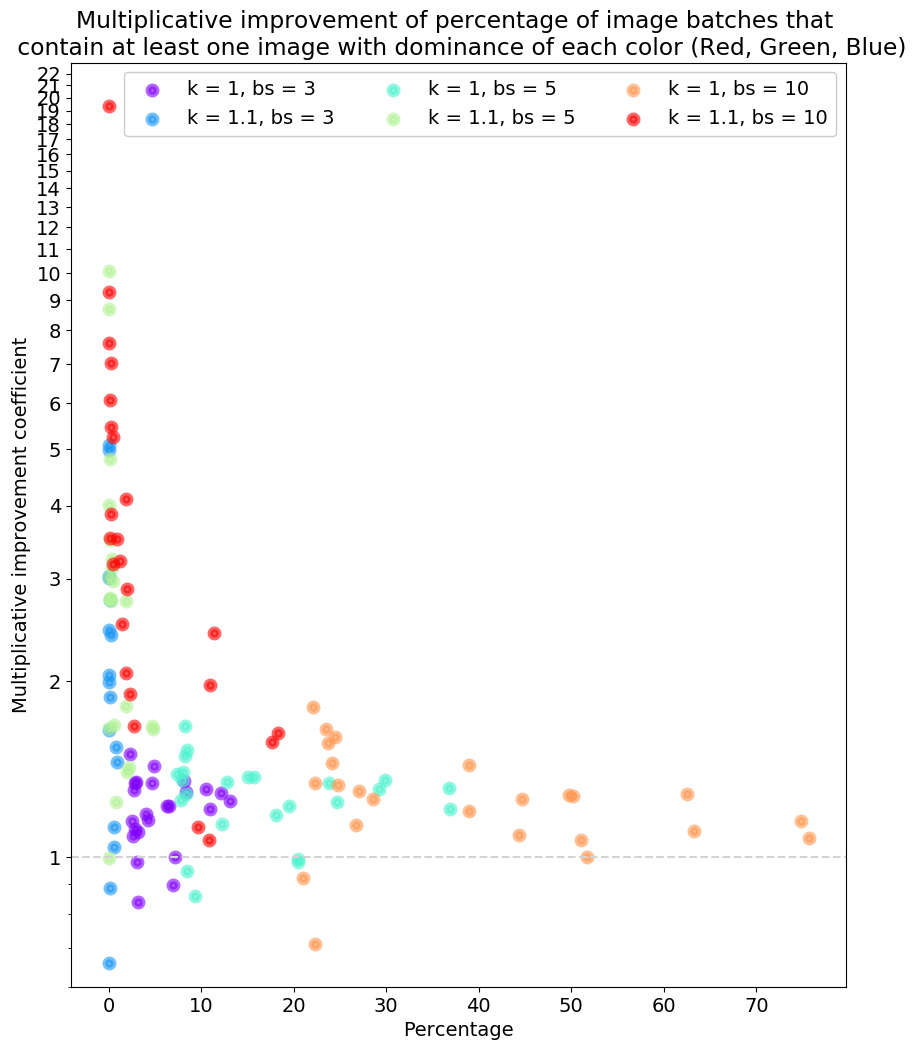

In [1238]:
get_graph_([prompt_dic_3, prompt_dic_3_K11]+[prompt_dic_5, prompt_dic_5_K11]+[prompt_dic_10, prompt_dic_10_K11],
           [prompt_dic_3_num, prompt_dic_3_K11_num]+[prompt_dic_5_num, prompt_dic_5_K11_num]
           +[prompt_dic_10_num, prompt_dic_10_K11_num], [lf_3, lf_3_K11]+[lf_5, lf_5_K11]+[lf_10, lf_10_K11], 
           len(list(modes_3)), modes_3, 
           experiments=['k = 1, bs = 3', 'k = 1.1, bs = 3']+
           ['k = 1, bs = 5', 'k = 1.1, bs = 5']+['k = 1, bs = 10', 'k = 1.1, bs = 10'],
           title="Multiplicative improvement of percentage of image batches that \n contain at least one image with dominance of each color (Red, Green, Blue)")


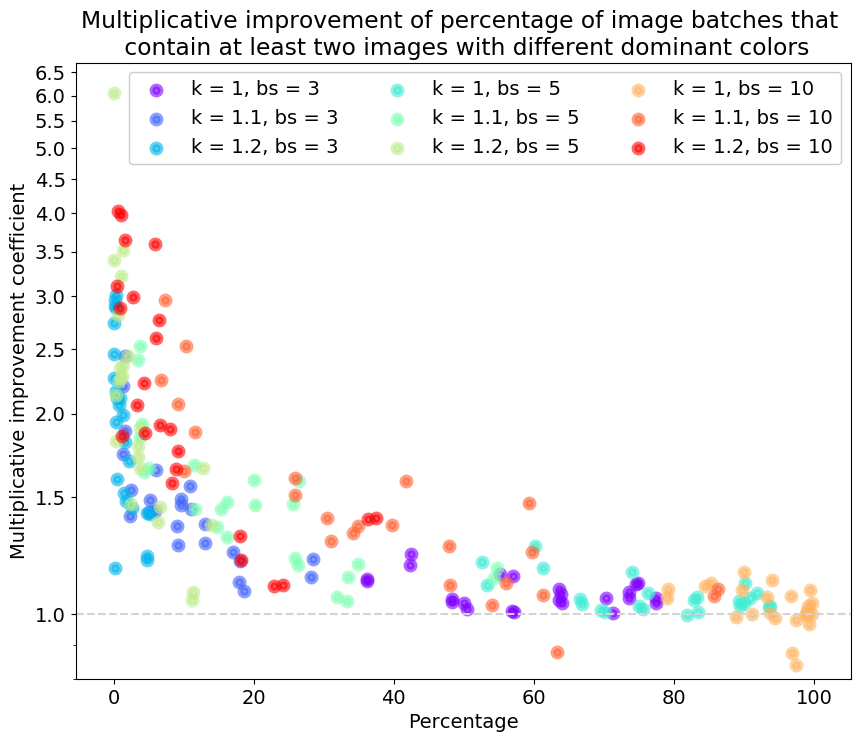

In [1244]:
get_graph_([prompt_dic_3_ss, prompt_dic_3_K11_ss, prompt_dic_3_K12_ss]+
           [prompt_dic_5_ss, prompt_dic_5_K11_ss, prompt_dic_5_K12_ss]+
           [prompt_dic_10_ss, prompt_dic_10_K11_ss, prompt_dic_10_K12_ss],
           [prompt_dic_3_num, prompt_dic_3_K11_num, prompt_dic_3_K12_num]+[prompt_dic_5_num, prompt_dic_5_K11_num, prompt_dic_5_K12_num]
           +[prompt_dic_10_num, prompt_dic_10_K11_num, prompt_dic_10_K12_num], [lf_3, lf_3_K11, lf_3_K12]+[lf_5, lf_5_K11, lf_5_K12]+[lf_10, lf_10_K11, lf_10_K12], 
           len(list(modes_3)), modes_3, 
           experiments=['k = 1, bs = 3', 'k = 1.1, bs = 3', 'k = 1.2, bs = 3']+
           ['k = 1, bs = 5', 'k = 1.1, bs = 5', 'k = 1.2, bs = 5']+['k = 1, bs = 10', 'k = 1.1, bs = 10', 'k = 1.2, bs = 10'],
           title="Multiplicative improvement of percentage of image batches that \n contain at least two images with different dominant colors")


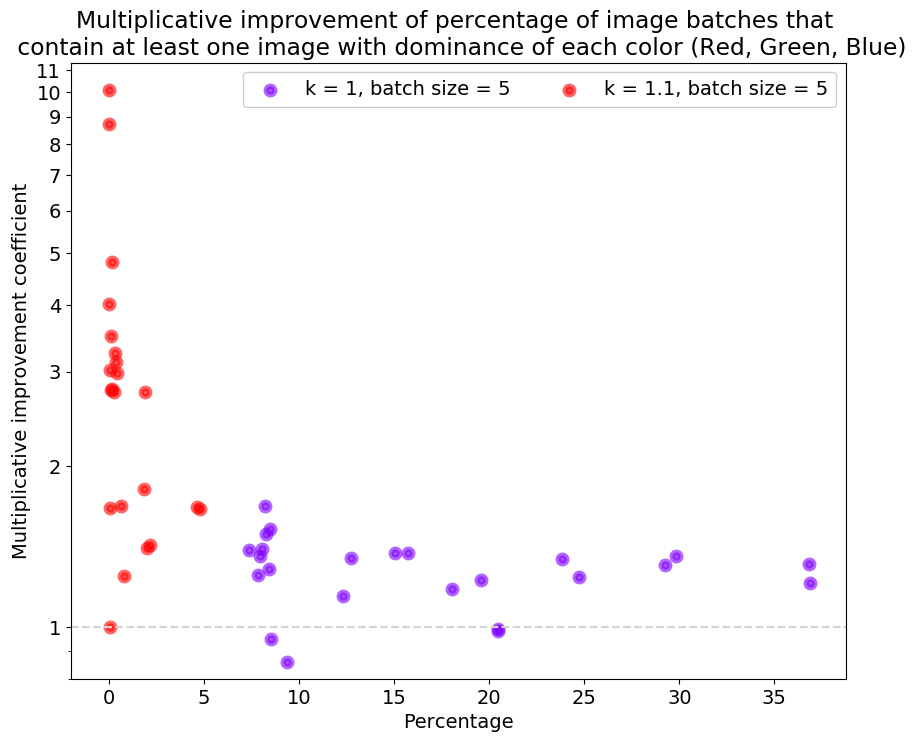

In [1245]:
get_graph_([prompt_dic_5, prompt_dic_5_K11], [prompt_dic_5_num, prompt_dic_5_K11_num], [lf_5, lf_5_K11], len(list(modes_5)), modes_5, experiments=['k = 1, batch size = 5', 'k = 1.1, batch size = 5'], title="Multiplicative improvement of percentage of image batches that \n contain at least one image with dominance of each color (Red, Green, Blue)")


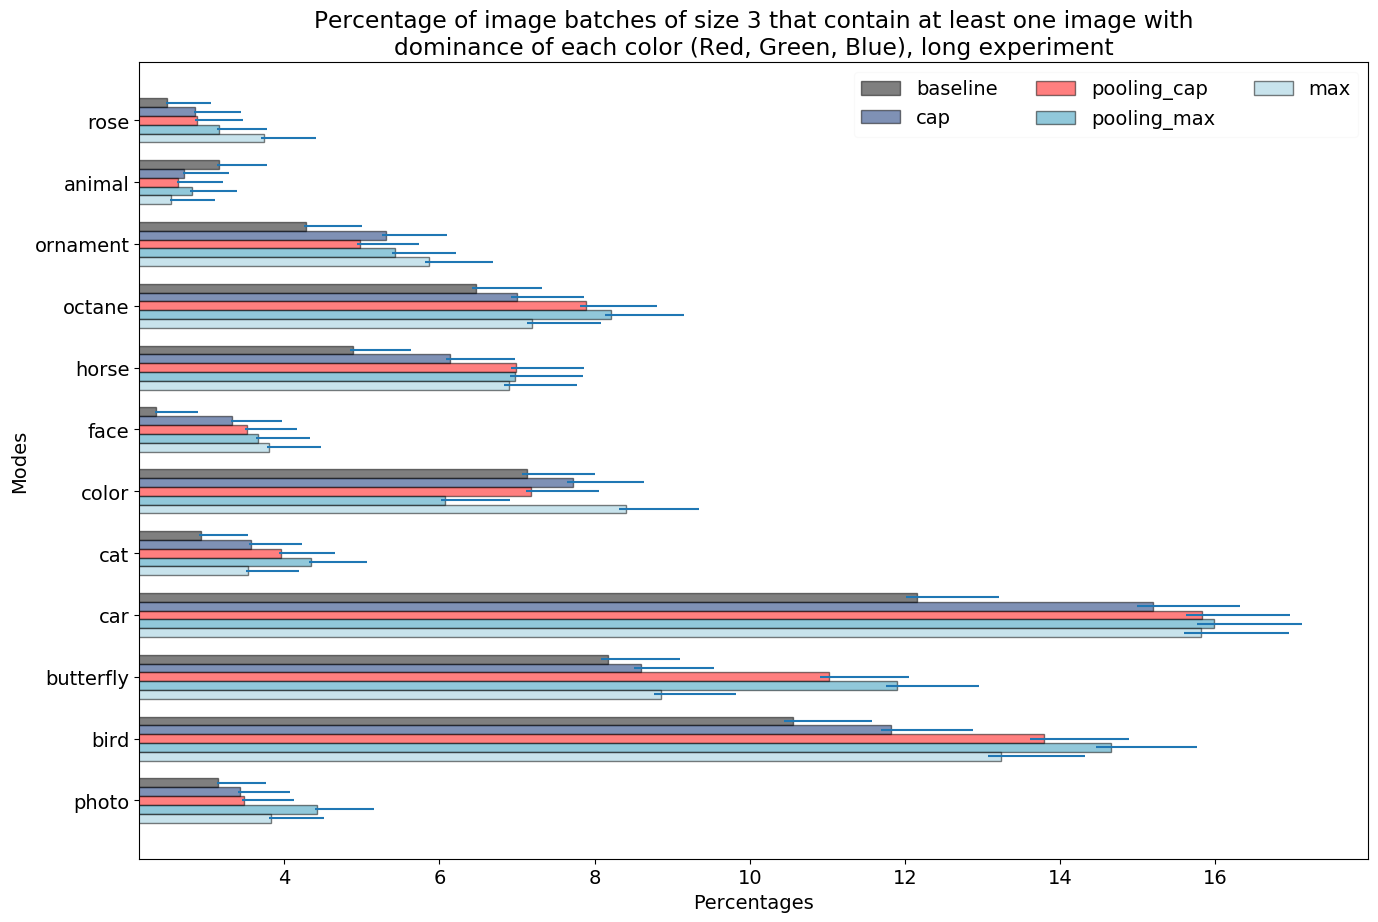

In [1095]:
get_graph(prompt_dic_3, prompt_dic_3_num, lf_3, len(list(modes_3)), modes_3, sd = None,
          title = "Percentage of image batches of size " + str(bs) + " that contain at least one image with dominance of each color (Red, Green, Blue)")

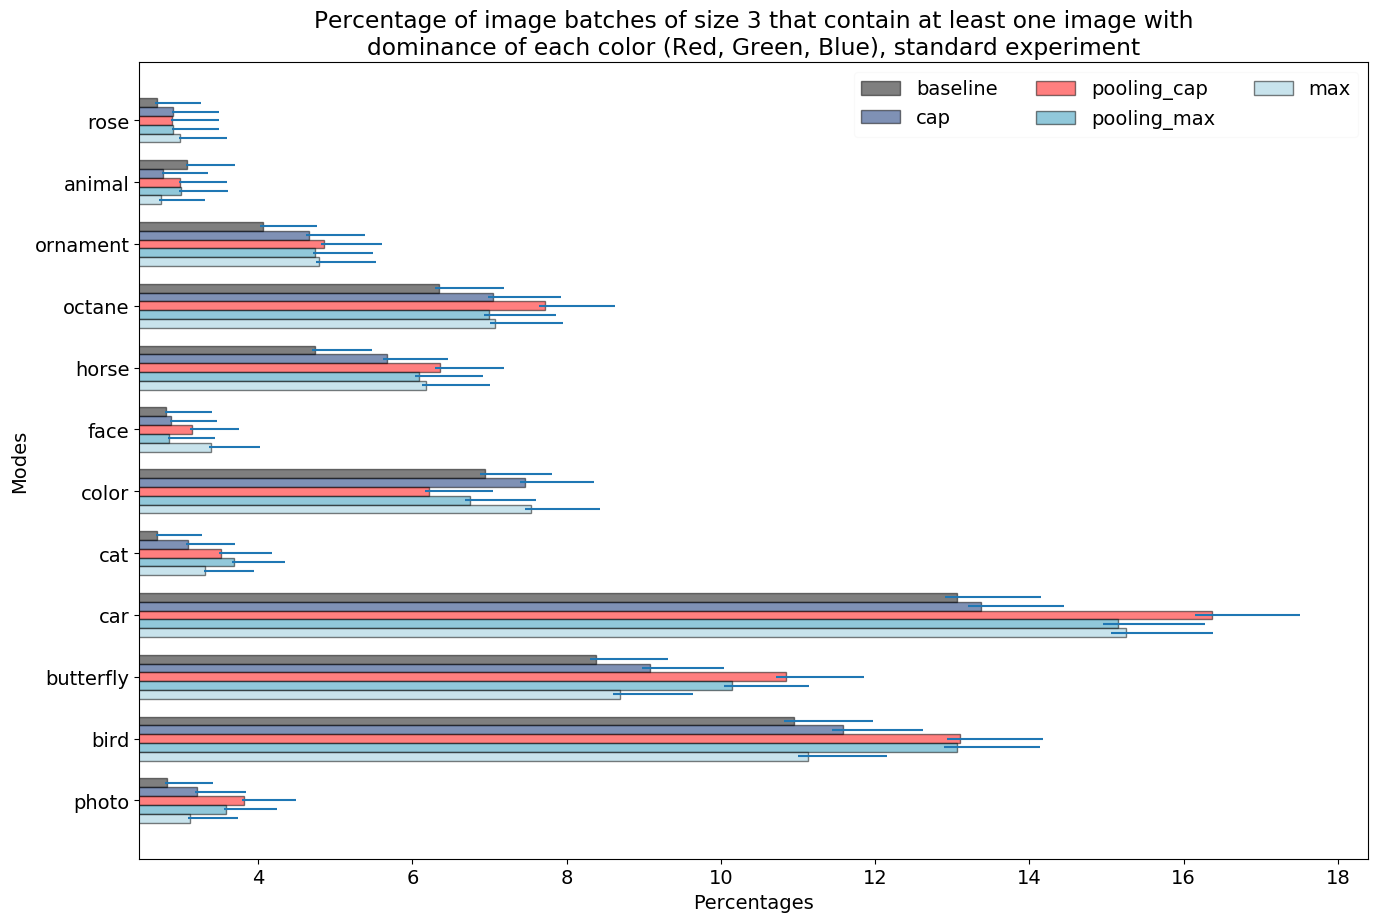

In [1096]:
get_graph(prompt_dic_3, prompt_dic_3_num, lf_3, len(list(modes_3)), modes_3, sd = None,
          title = "Percentage of image batches of size " + str(bs) + " that contain at least one image with dominance of each color (Red, Green, Blue)", updated_experiment = False)

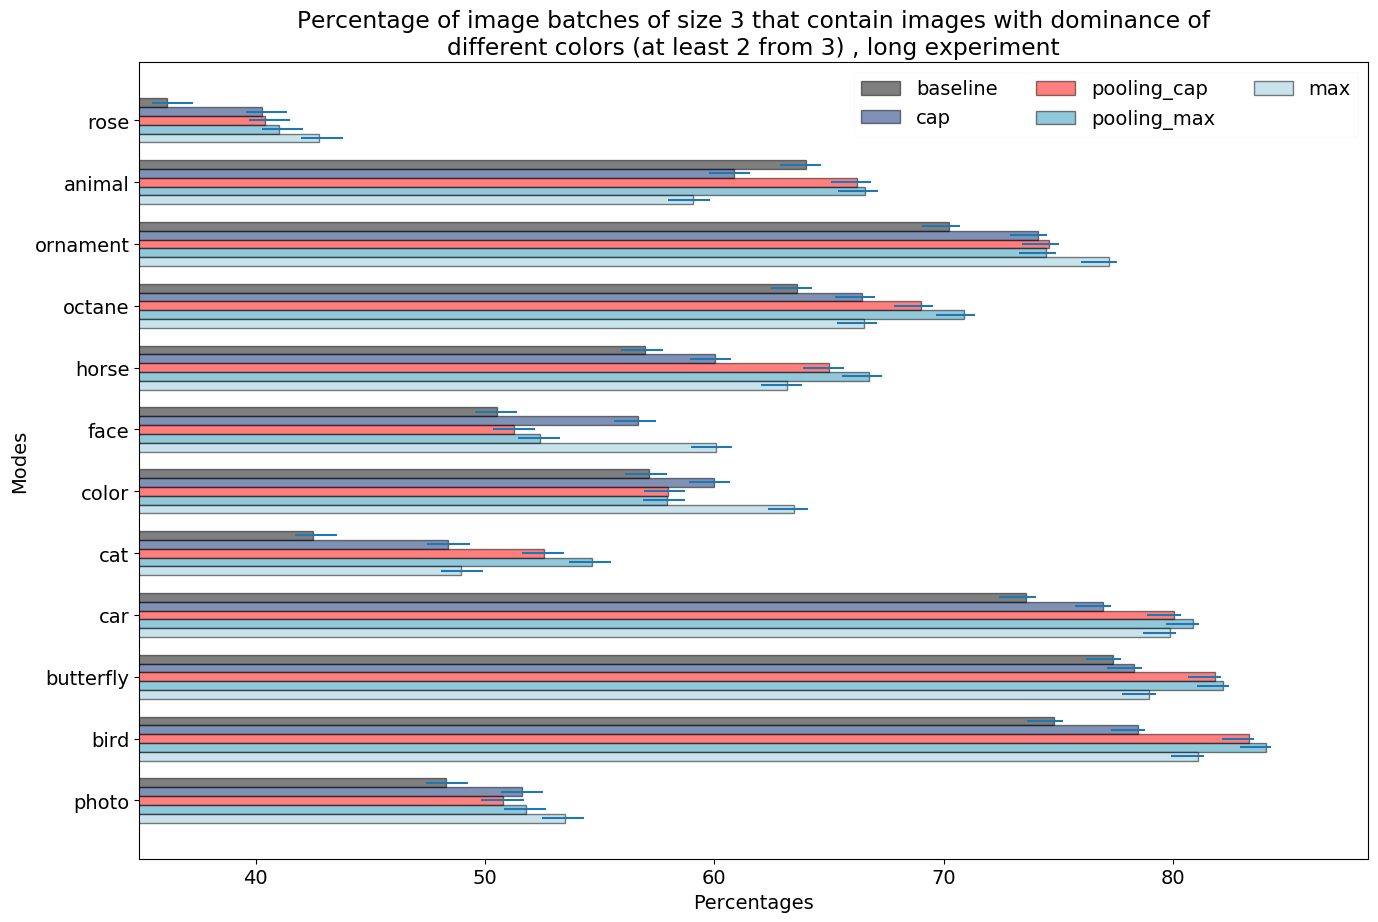

In [1097]:
get_graph(prompt_dic_3_ss, prompt_dic_3_num, lf_3, len(list(modes_3)), modes_3, sd = None,
          title = "Percentage of image batches of size " + str(bs) + " that contain images with dominance of different colors (at least 2 from 3) ")

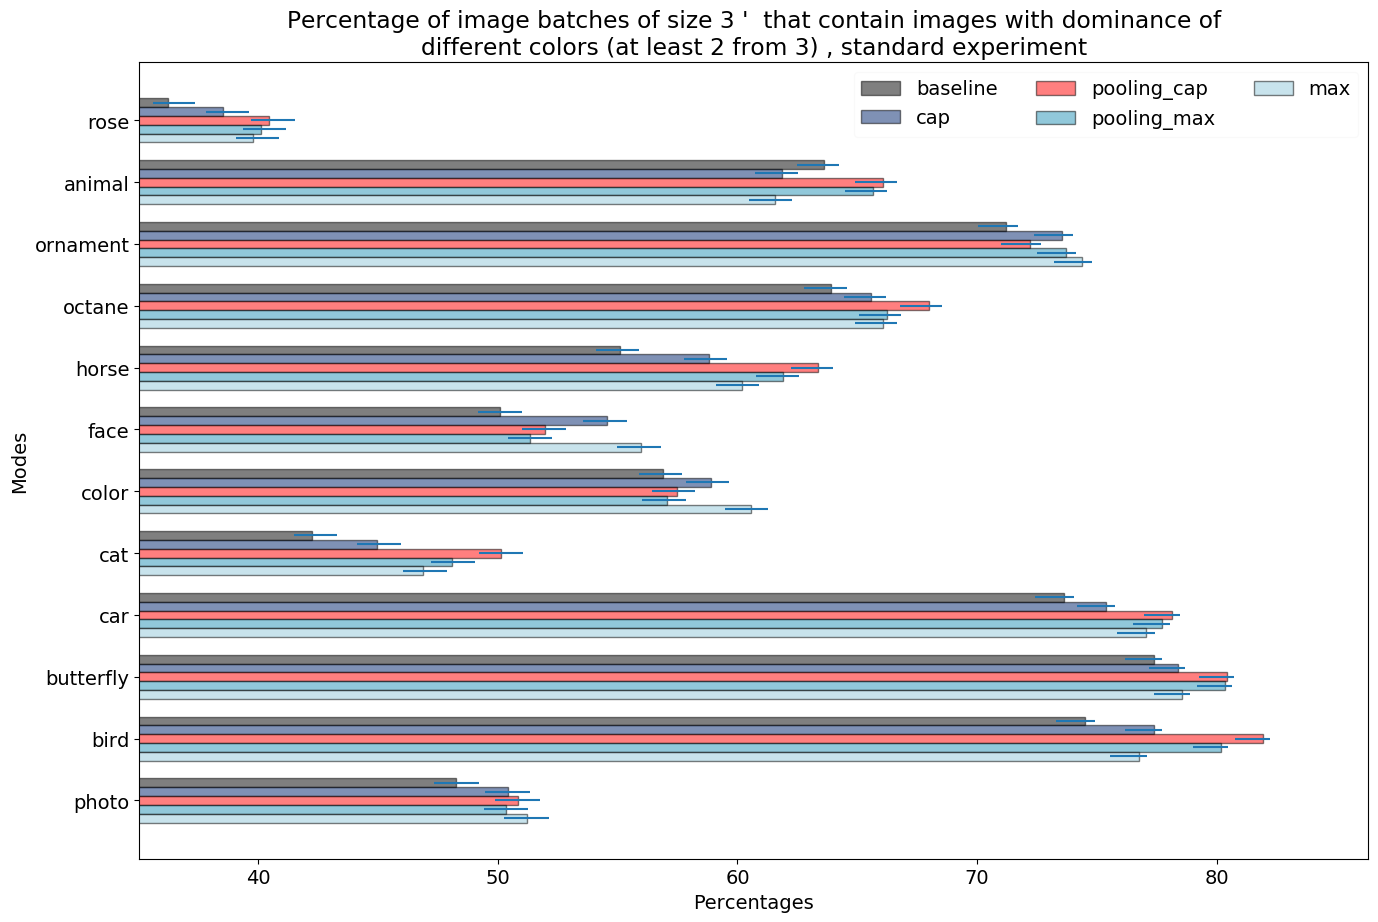

In [1098]:
get_graph(prompt_dic_3_ss, prompt_dic_3_num, lf_3, len(list(modes_3)), modes_3, sd = None,
          title = "Percentage of image batches of size " + str(bs) + " '  that contain images with dominance of different colors (at least 2 from 3) " , updated_experiment = False )

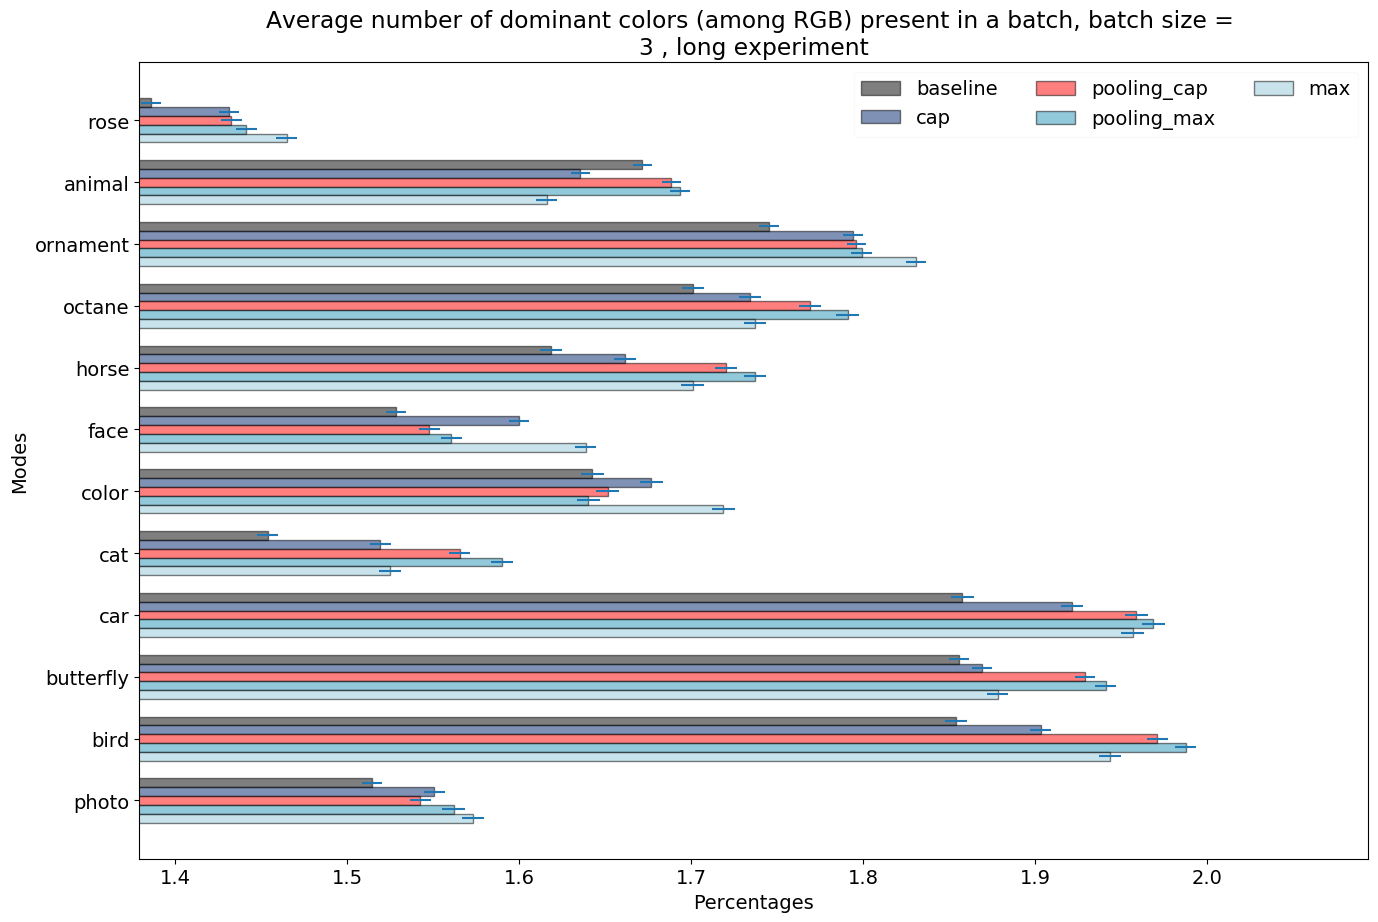

In [1099]:
get_graph(prompt_dic_3_savg, prompt_dic_3_num, lf_3, len(list(modes_3)), modes_3, sd = sd_sum_3,
          title = "Average number of dominant colors (among RGB) present in a batch, batch size =  " + str(bs) + ' ')

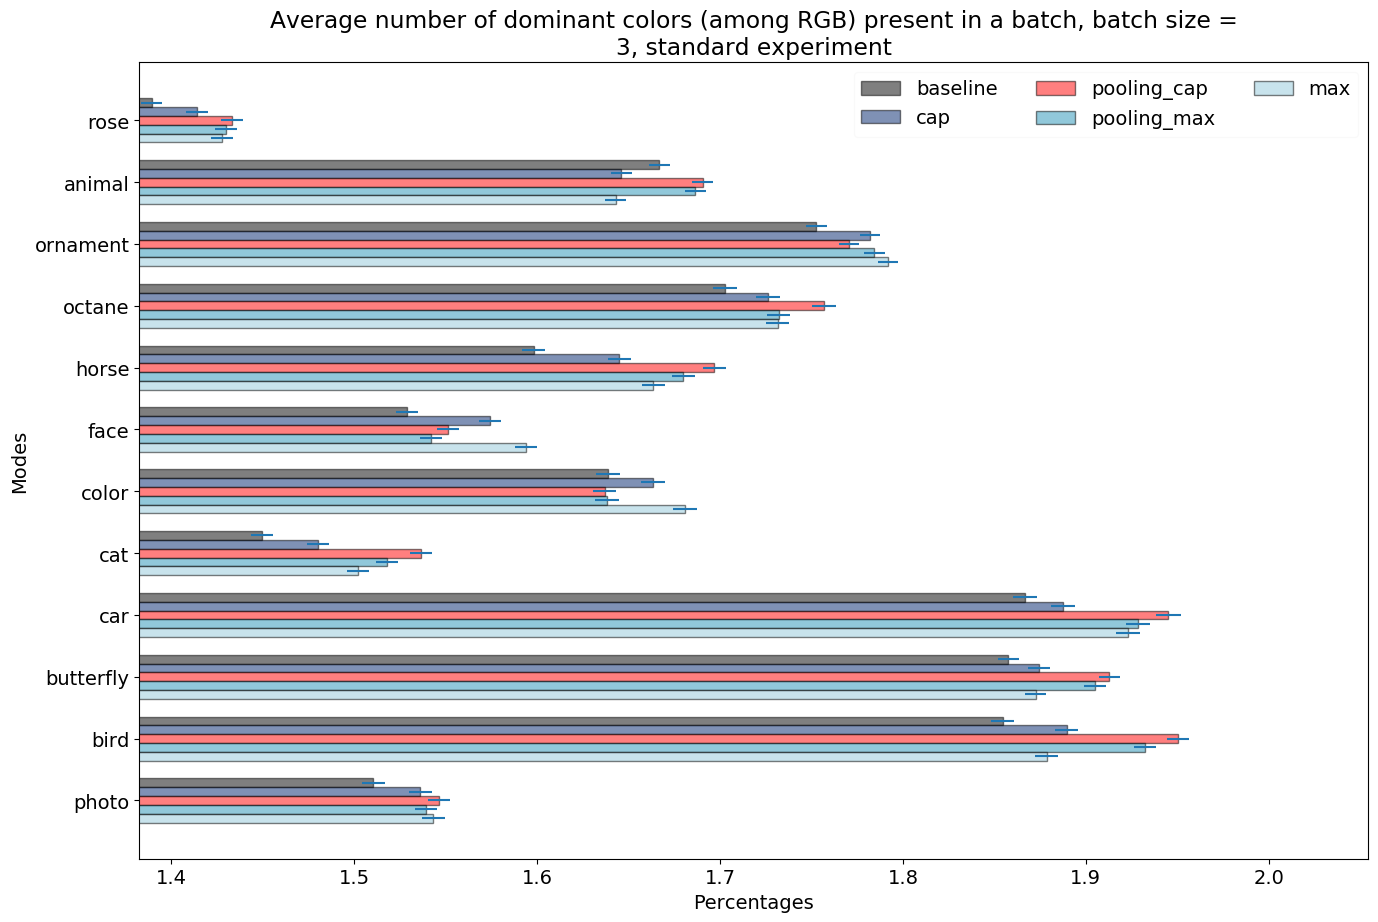

In [1100]:
get_graph(prompt_dic_3_savg, prompt_dic_3_num, lf_3, len(list(modes_3)), modes_3, sd = sd_sum_3,
          title = "Average number of dominant colors (among RGB) present in a batch, batch size = " + str(bs) ,  updated_experiment = False )

## batch_size = 5

In [1101]:
bs = 5

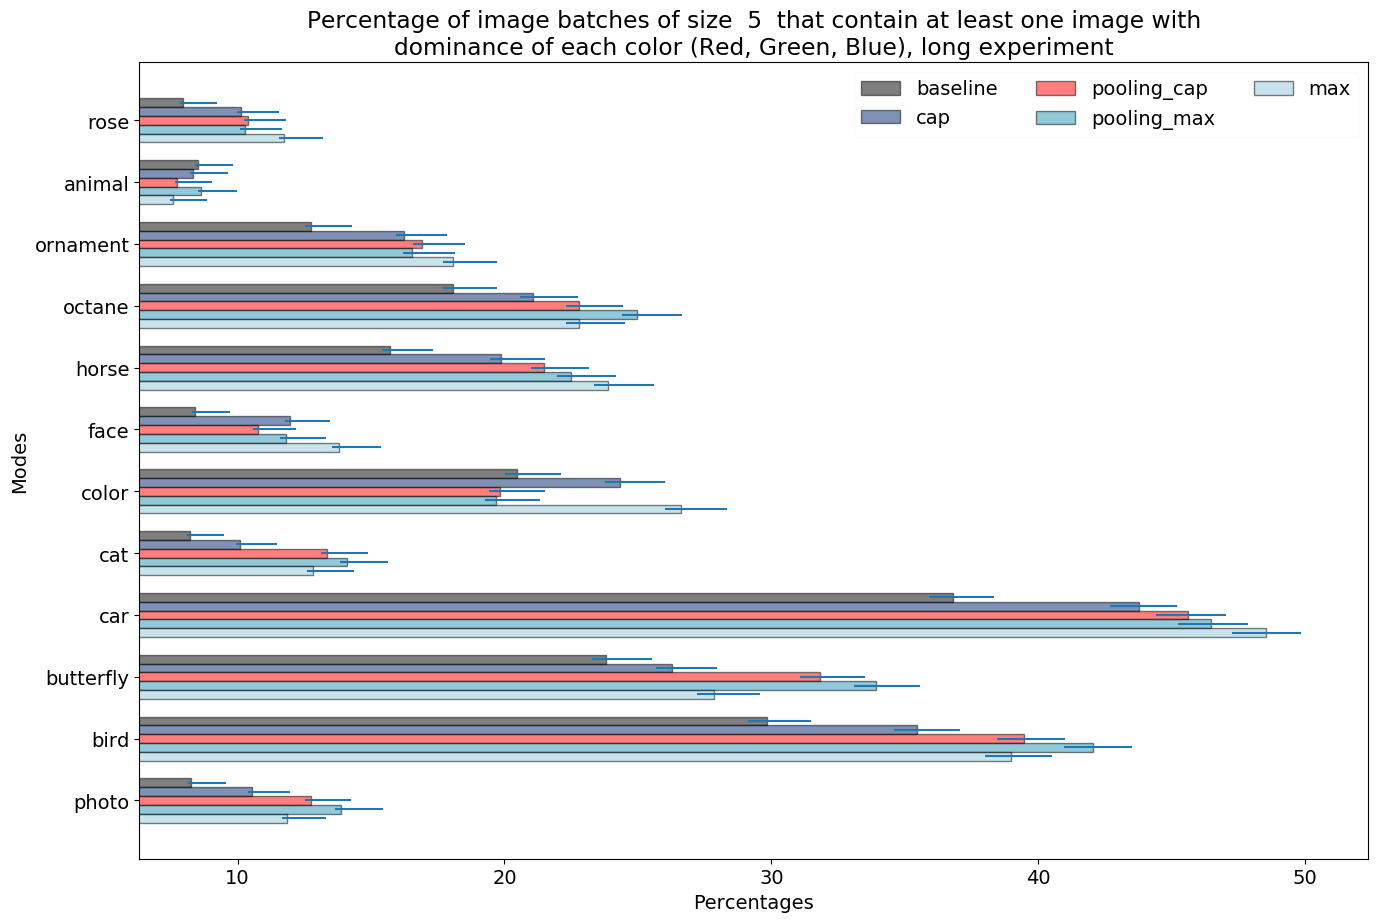

In [1102]:
get_graph(prompt_dic_5, prompt_dic_5_num, lf_5, len(list(modes_5)), modes_5, sd = None,
          title = "Percentage of image batches of size  " + str(bs) + "  that contain at least one image with dominance of each color (Red, Green, Blue)")

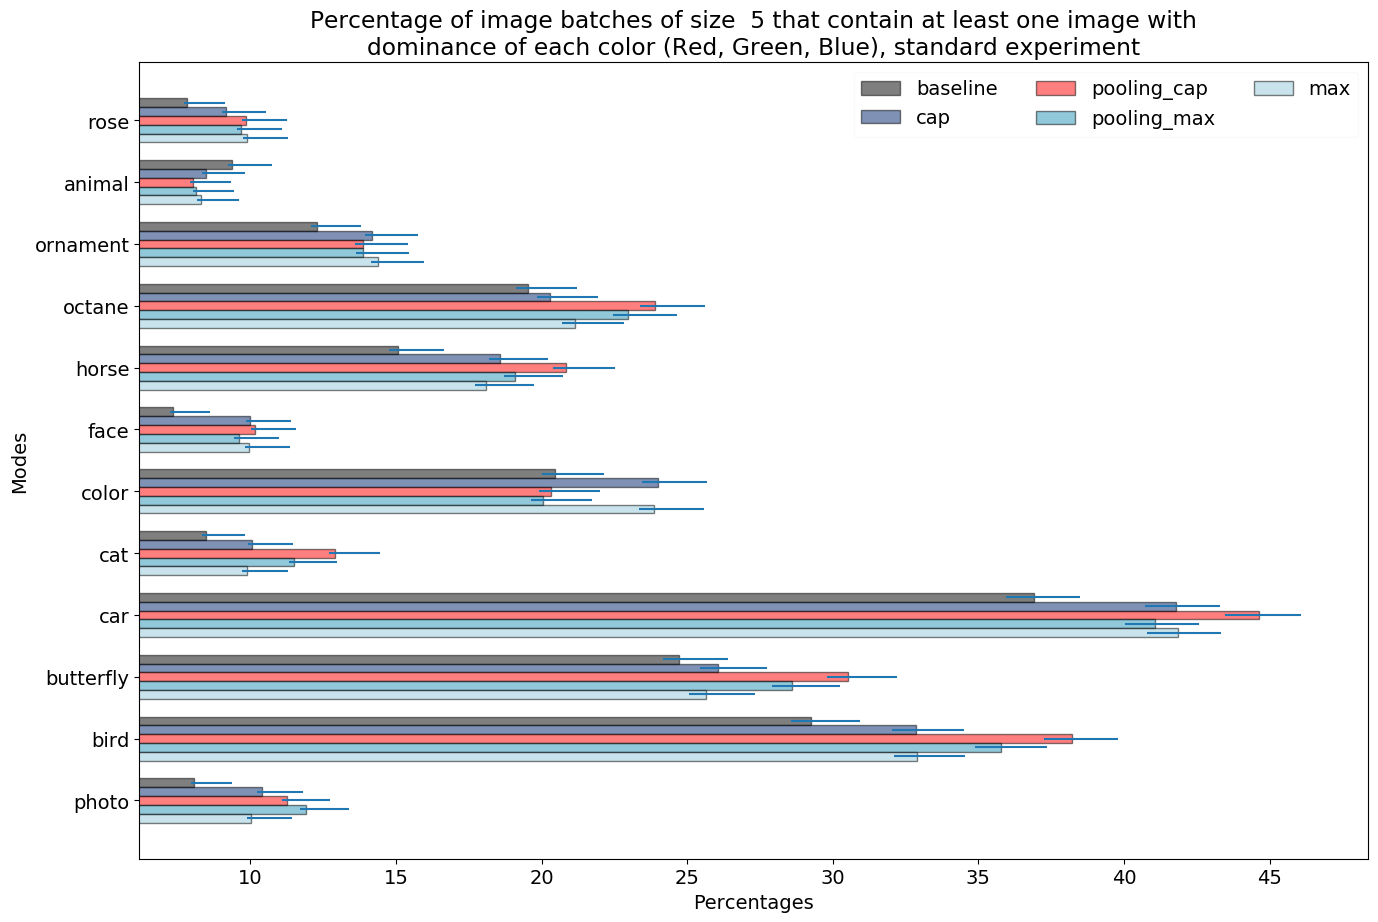

In [1103]:
get_graph(prompt_dic_5, prompt_dic_5_num, lf_5, len(list(modes_5)), modes_5, sd = None,
          title = "Percentage of image batches of size  " + str(bs) + " that contain at least one image with dominance of each color (Red, Green, Blue)", updated_experiment = False)

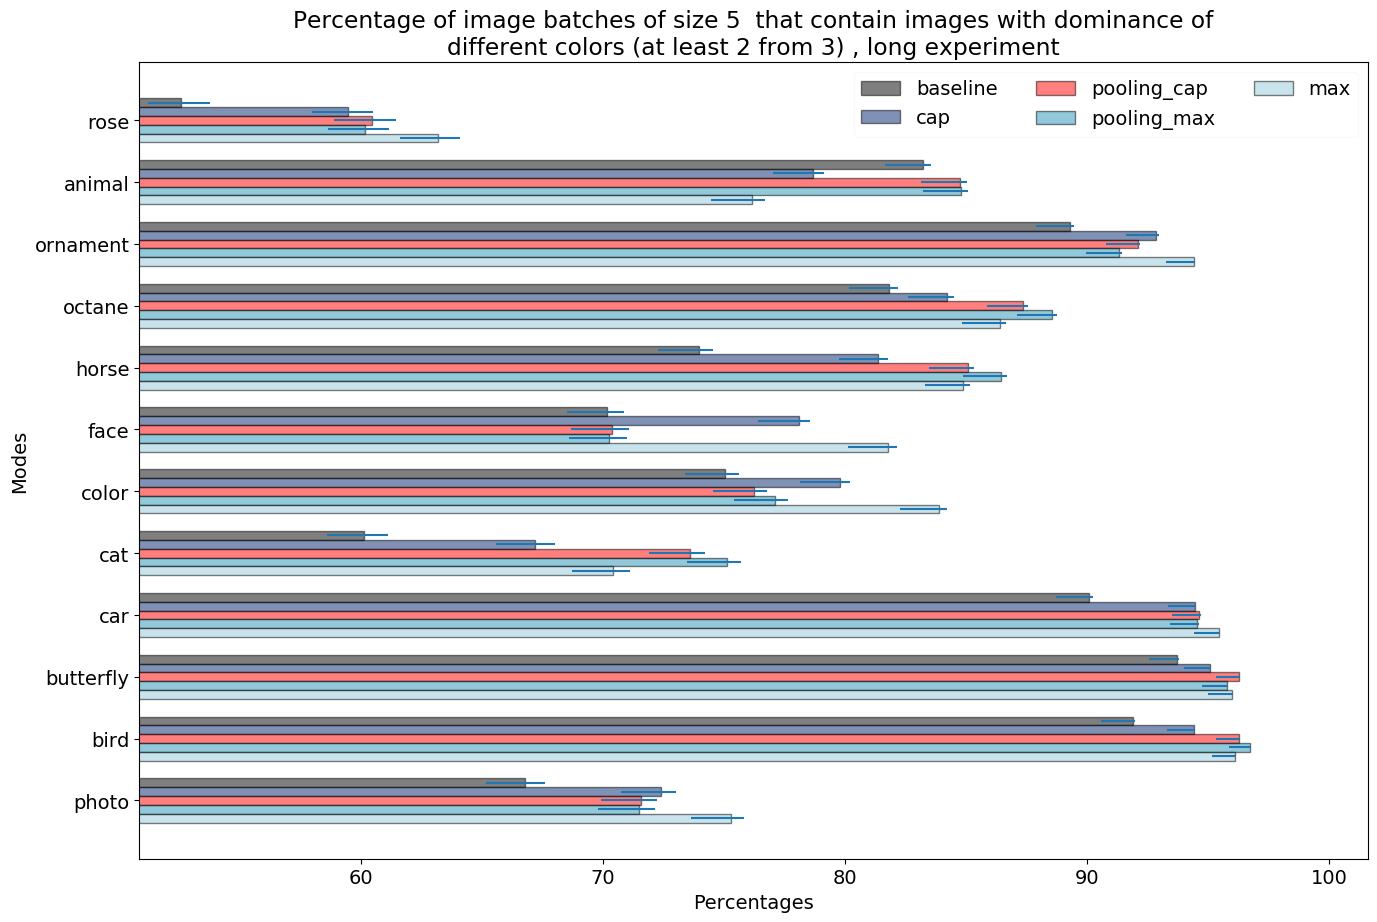

In [1104]:
get_graph(prompt_dic_5_ss, prompt_dic_5_num, lf_5, len(list(modes_5)), modes_5, sd = None,
          title = "Percentage of image batches of size " + str(bs) + "  that contain images with dominance of different colors (at least 2 from 3) ")

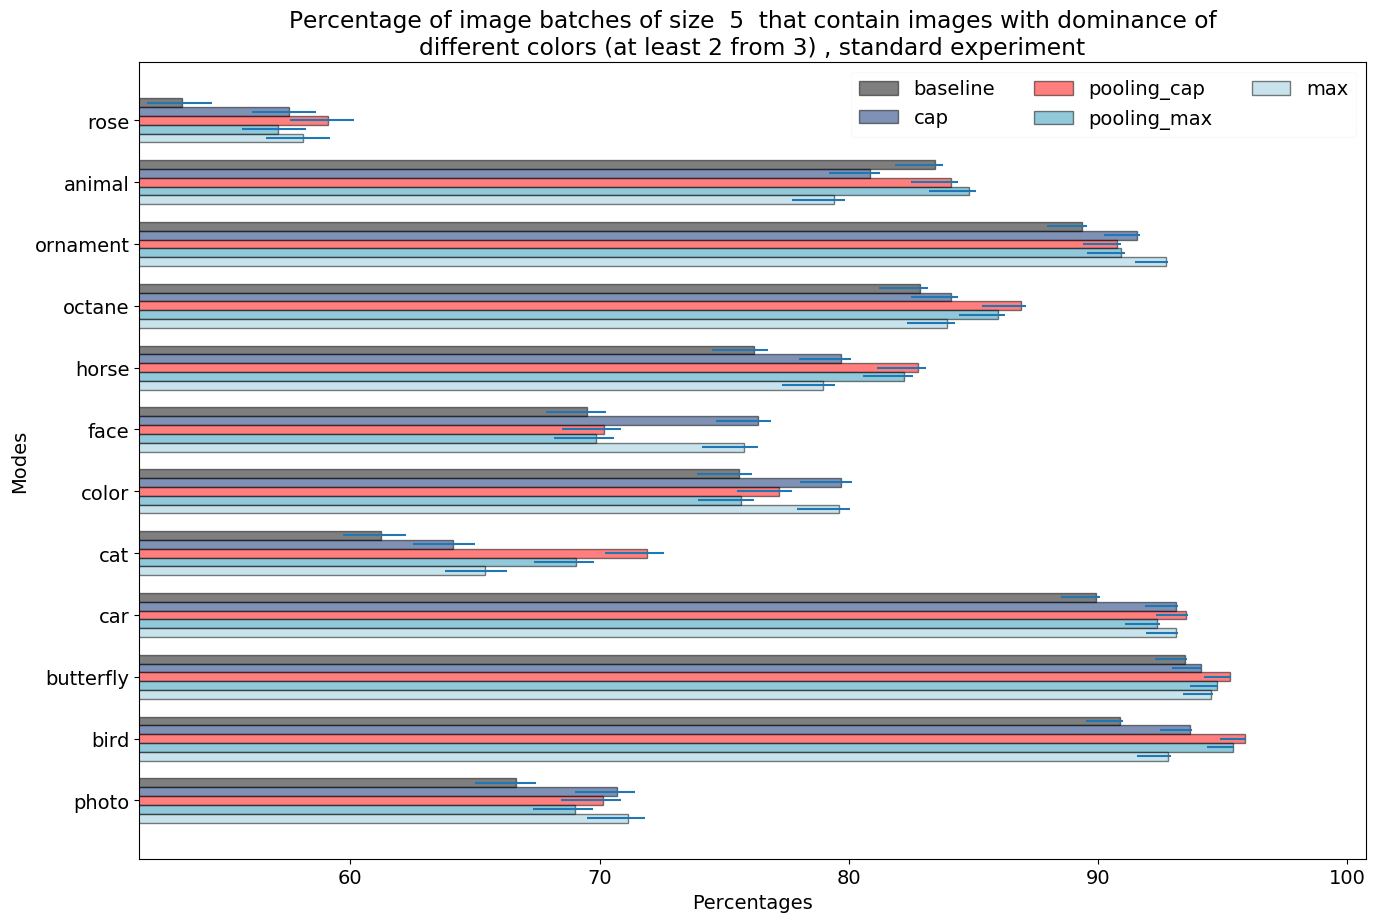

In [1105]:
get_graph(prompt_dic_5_ss, prompt_dic_5_num, lf_5, len(list(modes_5)), modes_5, sd = None,
          title = "Percentage of image batches of size  " + str(bs) + "  that contain images with dominance of different colors (at least 2 from 3) " , updated_experiment = False )

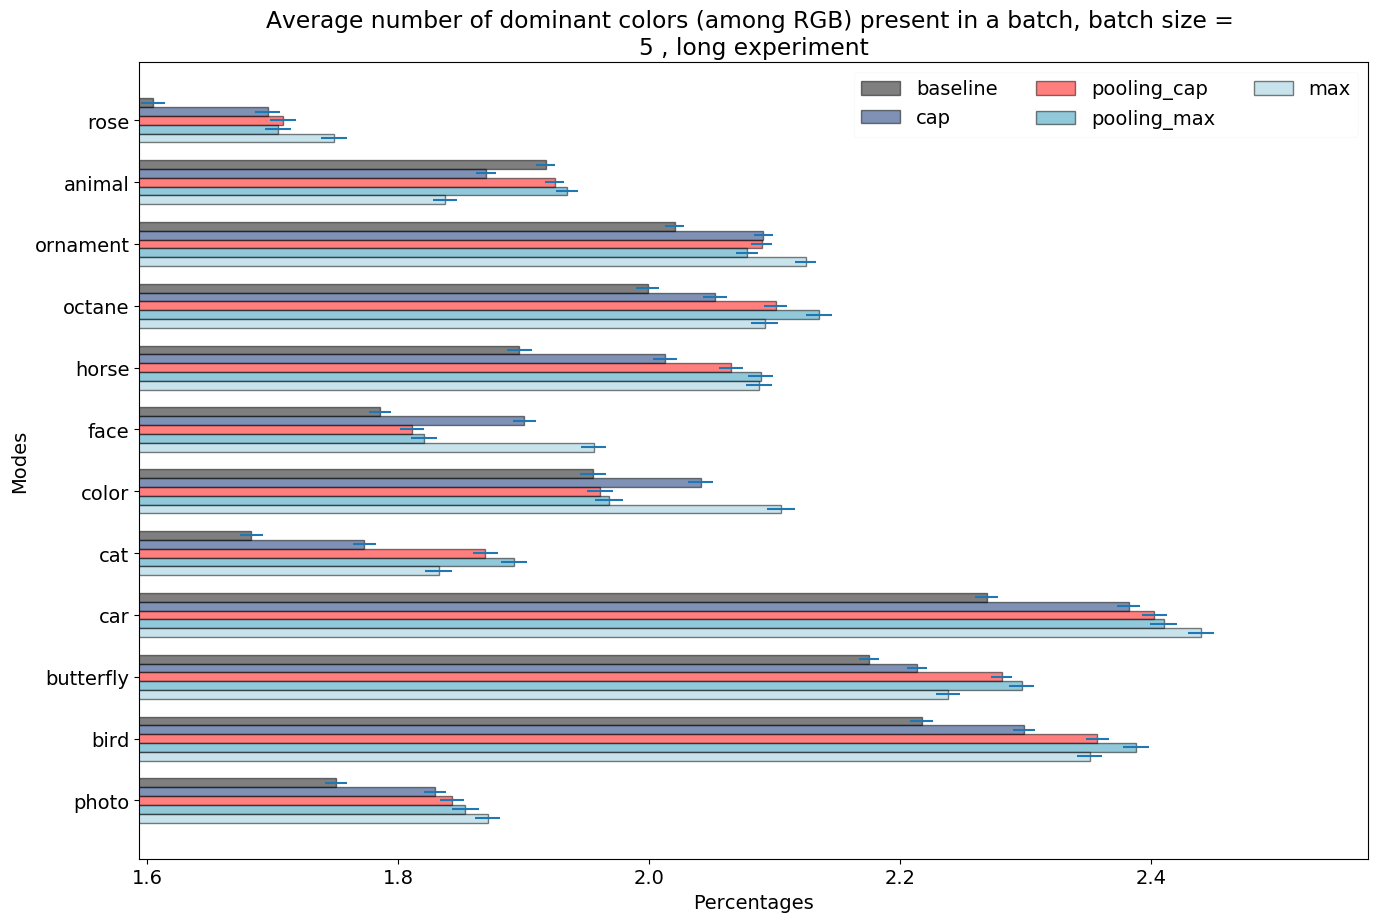

In [1106]:
get_graph(prompt_dic_5_savg, prompt_dic_5_num, lf_5, len(list(modes_5)), modes_5, sd = sd_sum_5,
          title = "Average number of dominant colors (among RGB) present in a batch, batch size =  " + str(bs) + " ")

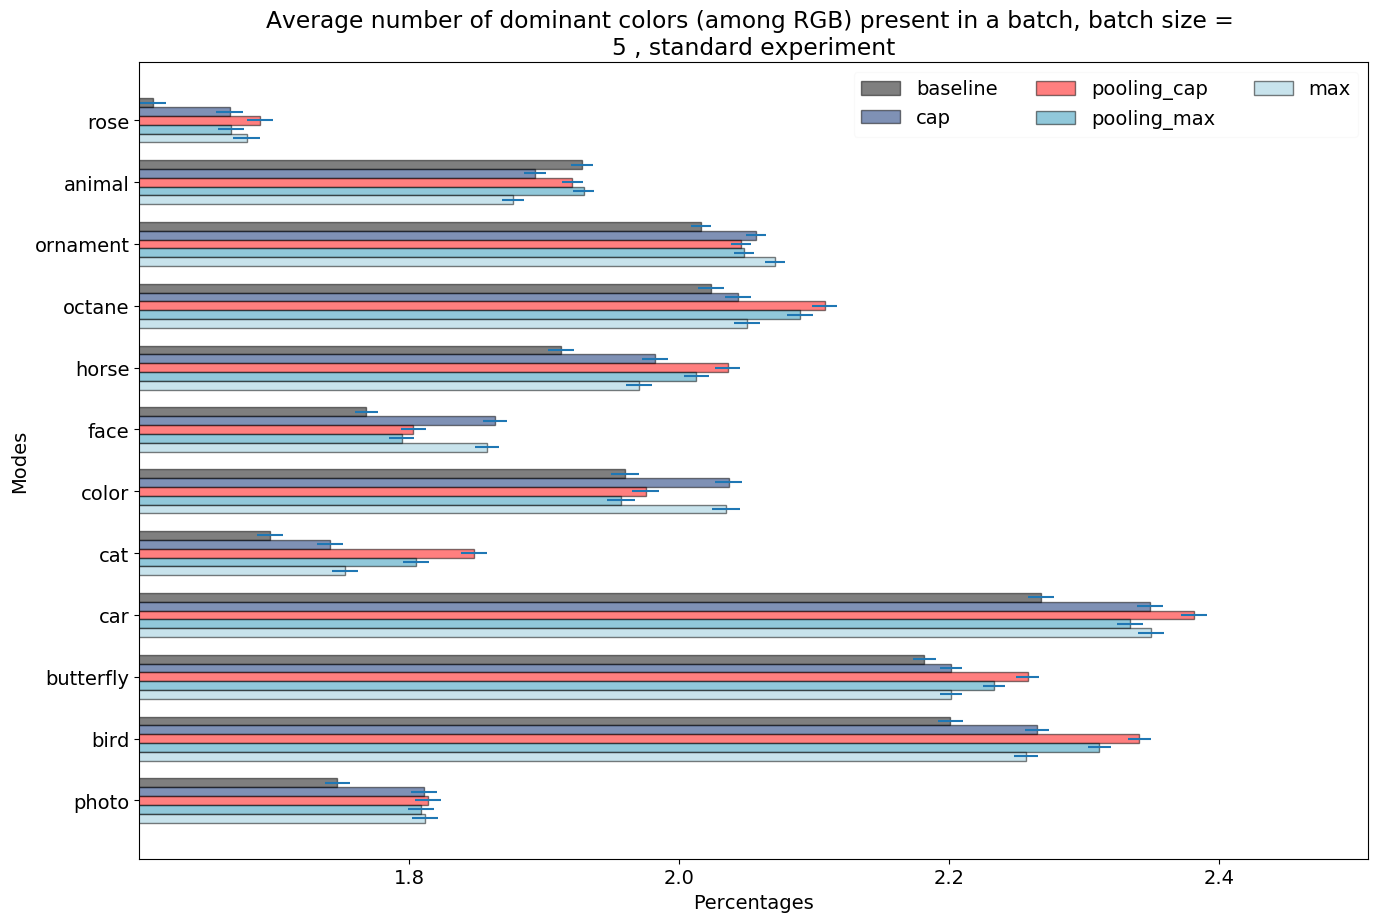

In [1107]:
get_graph(prompt_dic_5_savg, prompt_dic_5_num, lf_5, len(list(modes_5)), modes_5, sd = sd_sum_5,
          title = "Average number of dominant colors (among RGB) present in a batch, batch size =  " + str(bs) + " ",  updated_experiment = False )

## batch_size = 10

In [1108]:
bs = 10

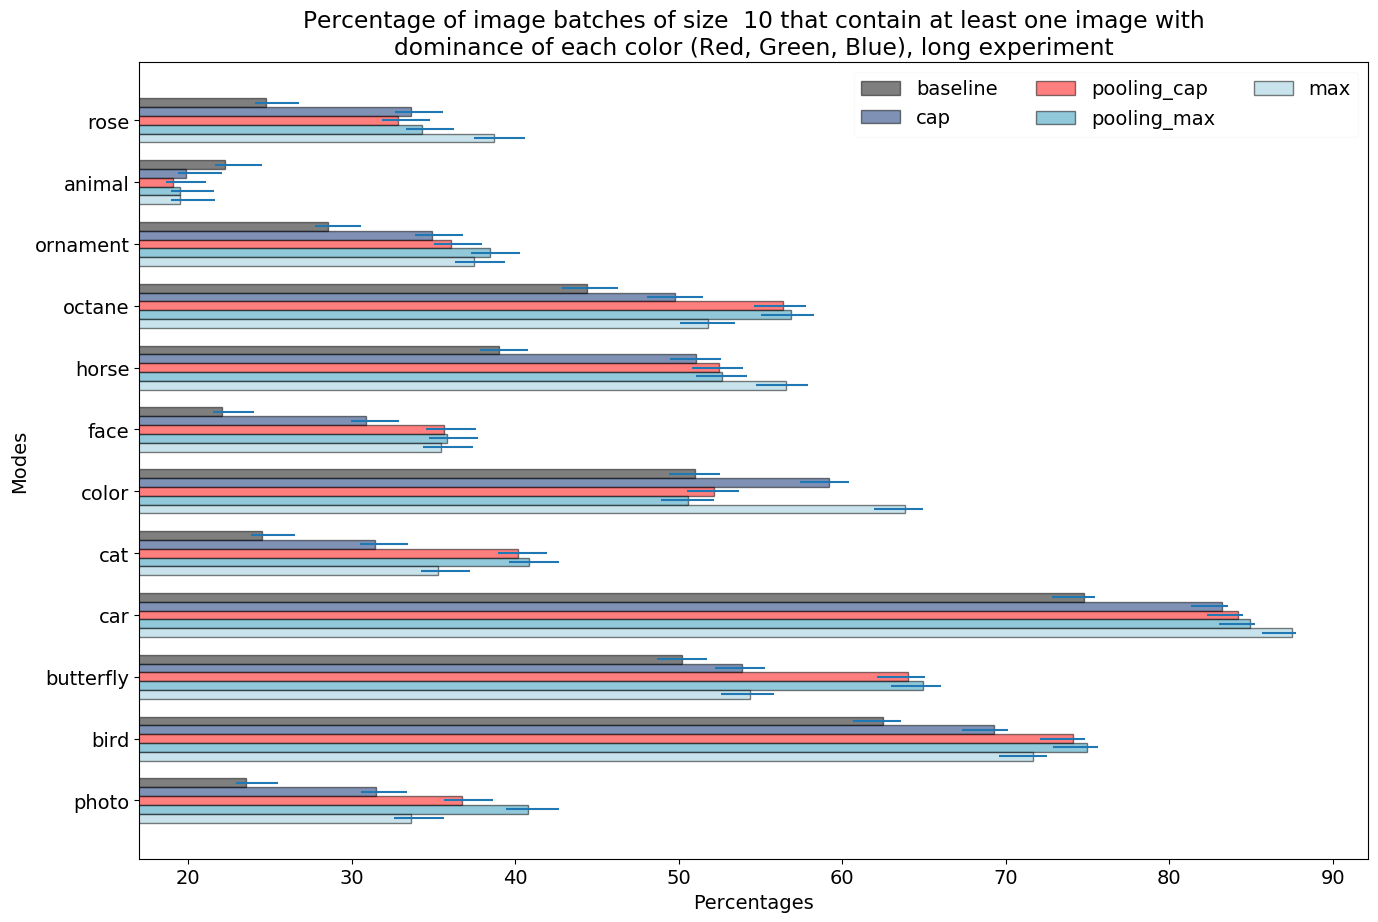

In [1109]:
get_graph(prompt_dic_10, prompt_dic_10_num, lf_10, len(list(modes_10)), modes_10, sd = None,
          title = "Percentage of image batches of size  " + str(bs) + " that contain at least one image with dominance of each color (Red, Green, Blue)")

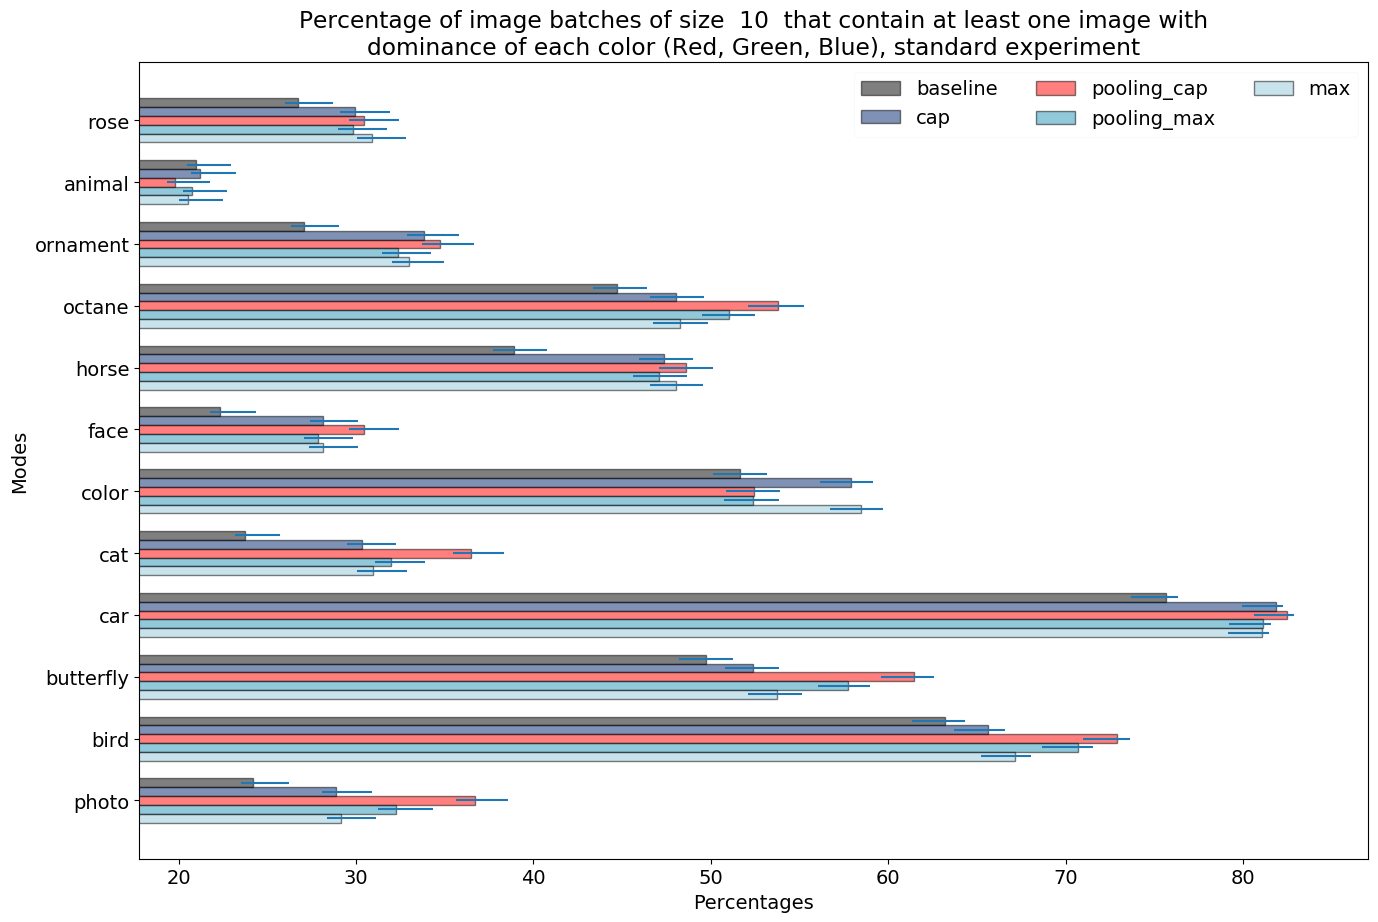

In [1110]:
get_graph(prompt_dic_10, prompt_dic_10_num, lf_10, len(list(modes_10)), modes_10, sd = None,
          title = "Percentage of image batches of size  " + str(bs) + "  that contain at least one image with dominance of each color (Red, Green, Blue)", updated_experiment = False)

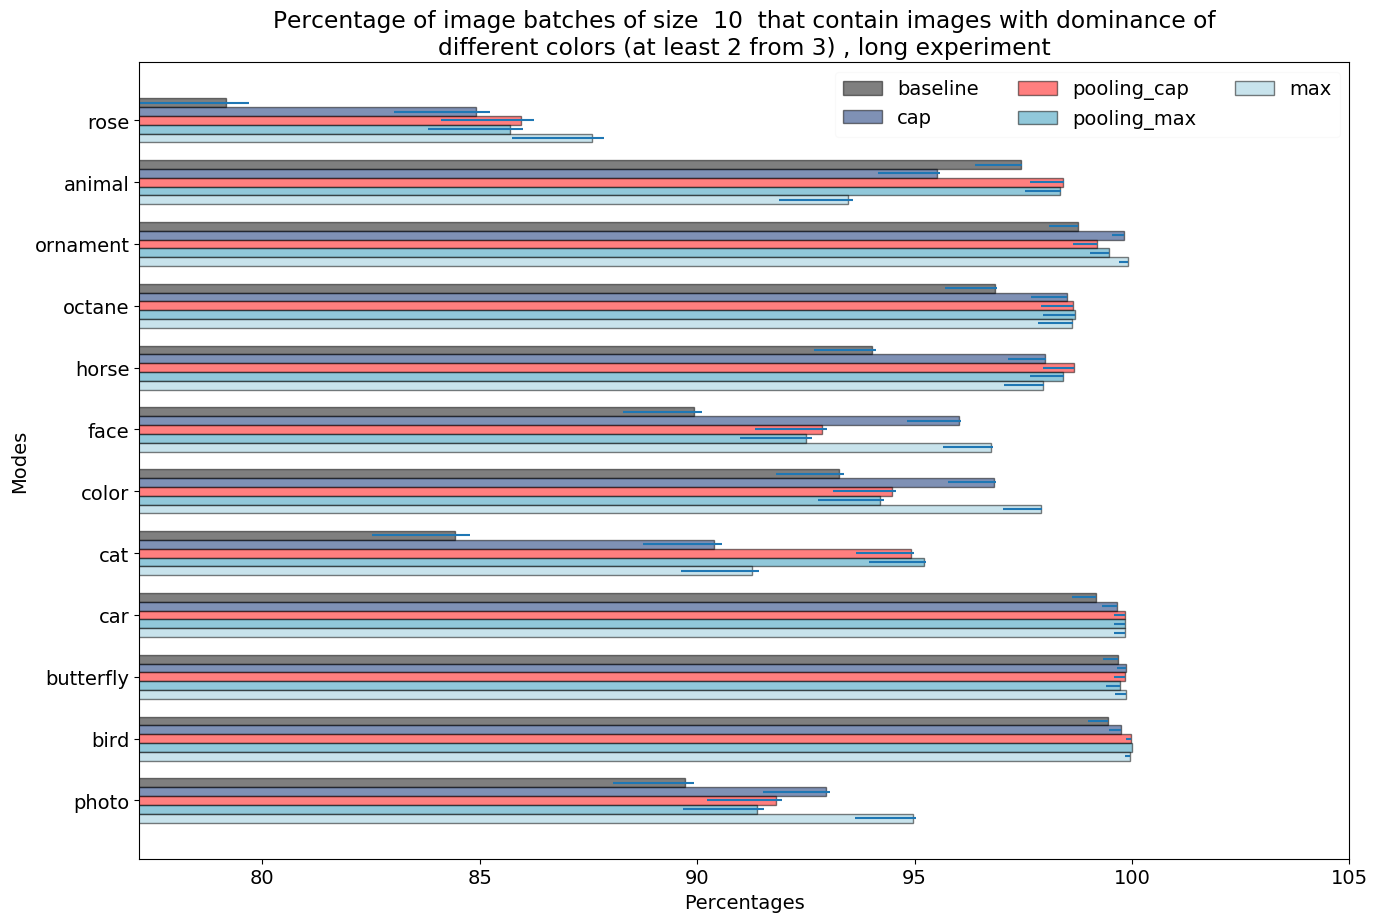

In [1111]:
get_graph(prompt_dic_10_ss, prompt_dic_10_num, lf_10, len(list(modes_10)), modes_10, sd = None,
          title = "Percentage of image batches of size  " + str(bs) + "  that contain images with dominance of different colors (at least 2 from 3) ")

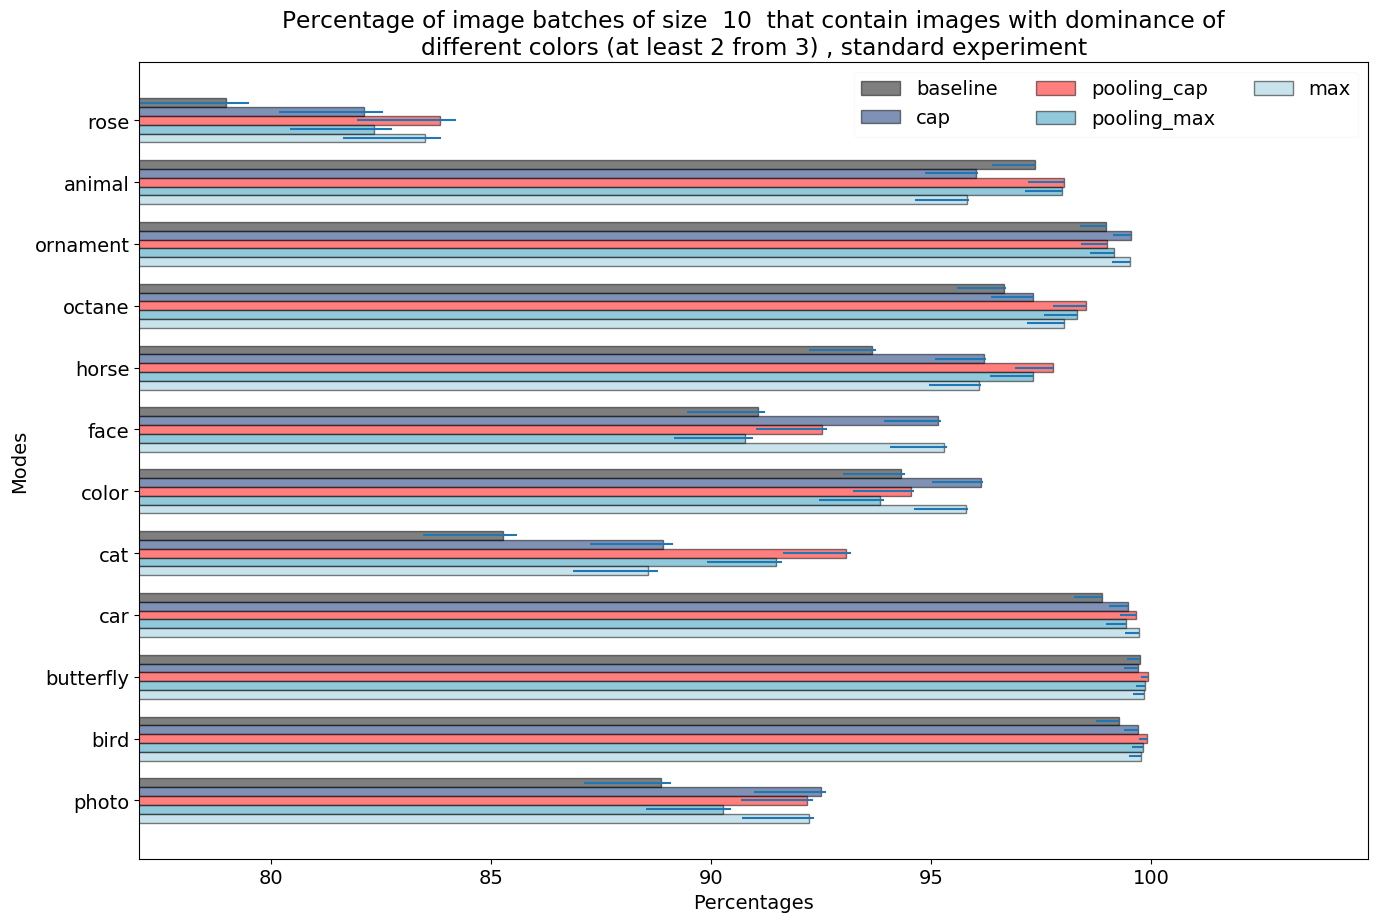

In [1112]:
get_graph(prompt_dic_10_ss, prompt_dic_10_num, lf_10, len(list(modes_10)), modes_10, sd = None,
          title = "Percentage of image batches of size  " + str(bs) + "  that contain images with dominance of different colors (at least 2 from 3) " , updated_experiment = False )

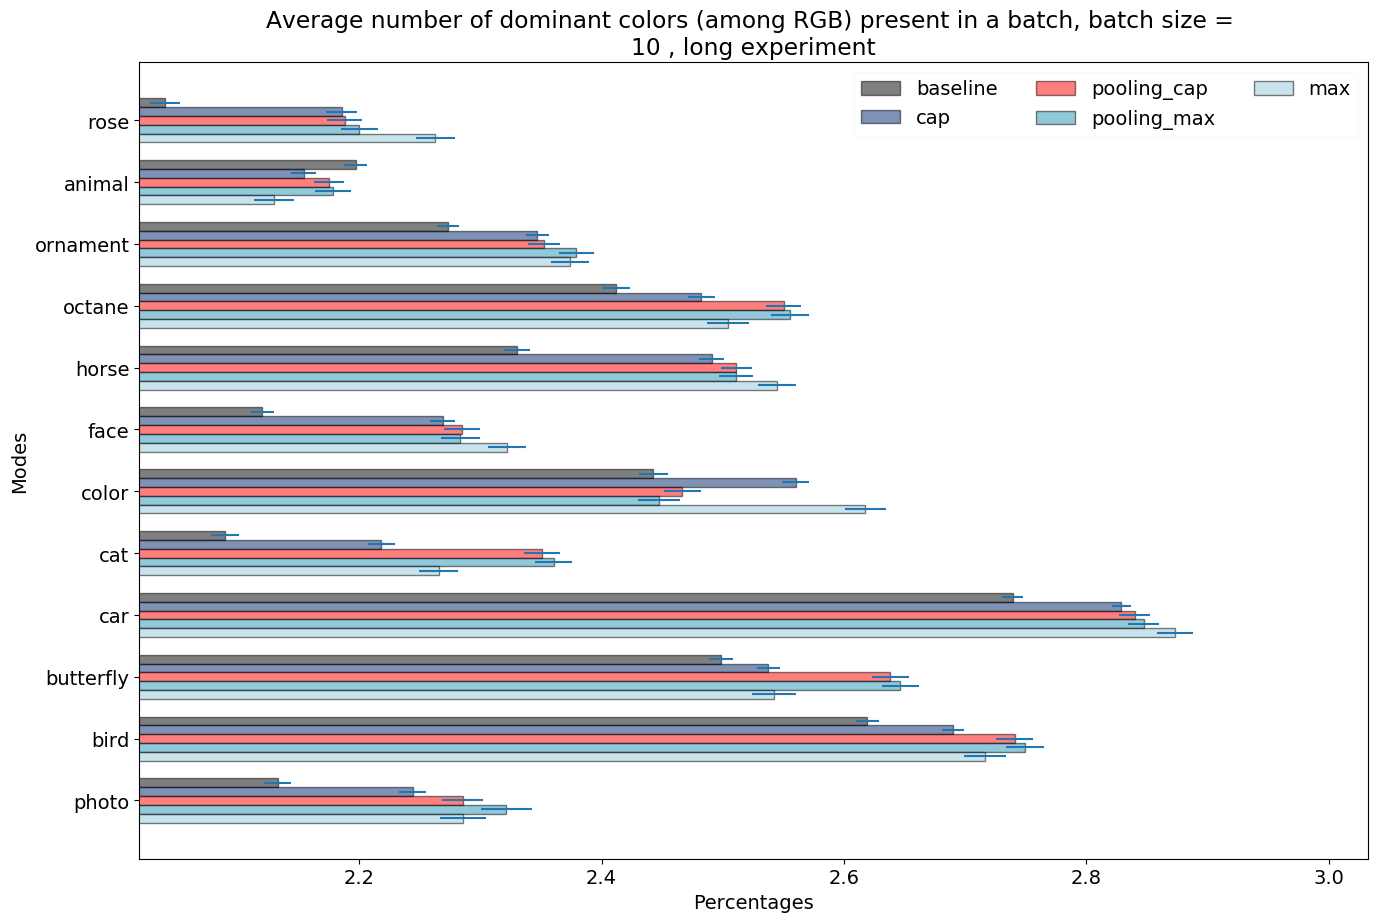

In [1113]:
get_graph(prompt_dic_10_savg, prompt_dic_10_num, lf_10, len(list(modes_10)), modes_10, sd = sd_sum_10,
          title = "Average number of dominant colors (among RGB) present in a batch, batch size =  " + str(bs) + " ")

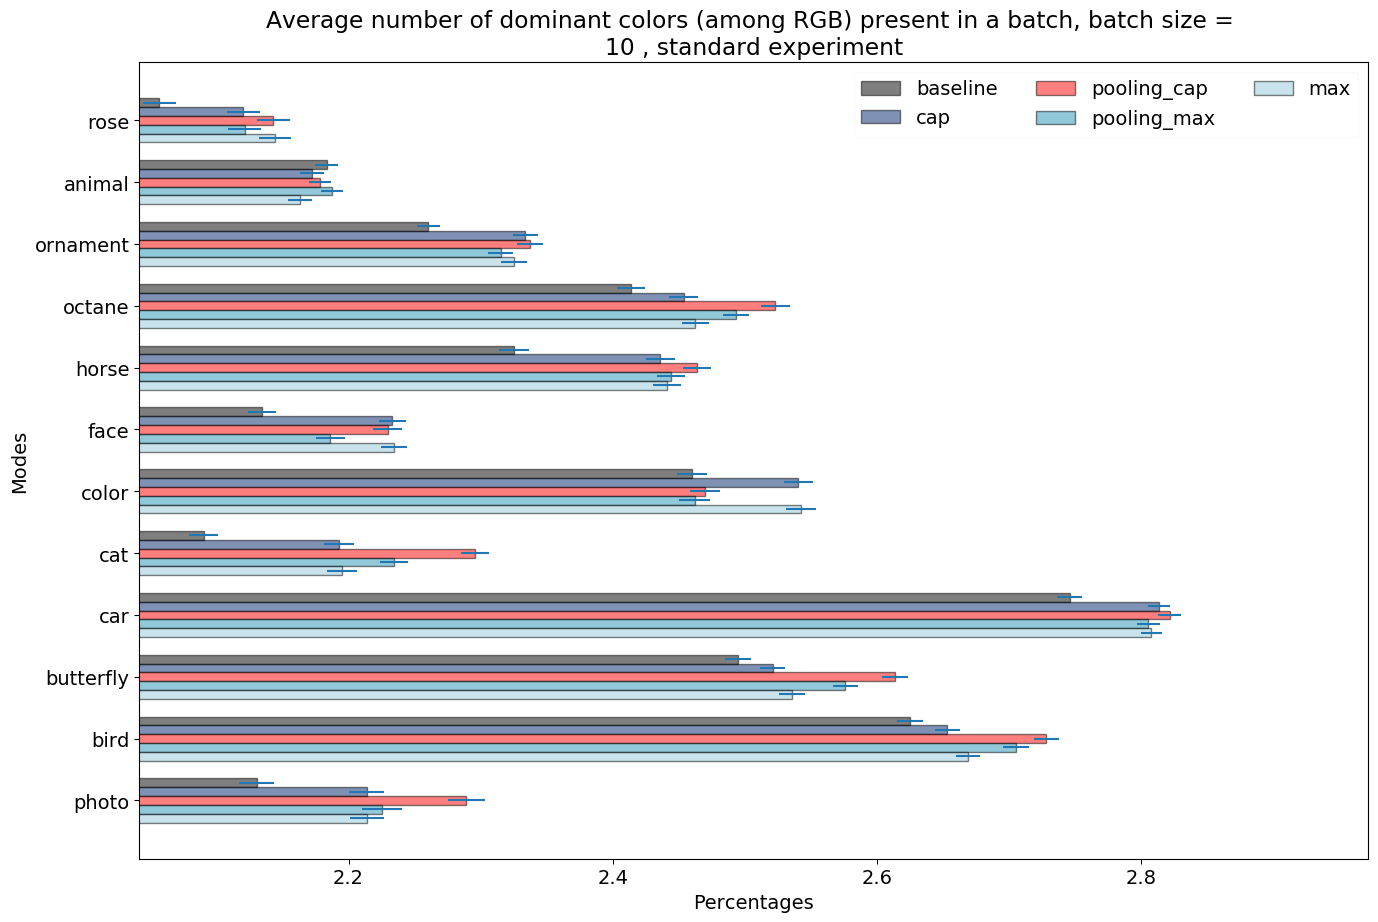

In [1114]:
get_graph(prompt_dic_10_savg, prompt_dic_10_num, lf_10, len(list(modes_10)), modes_10, sd = sd_sum_10,
          title = "Average number of dominant colors (among RGB) present in a batch, batch size =  " + str(bs) + " ",  updated_experiment = False )

# K = 1.2
## batch size = 3

In [1115]:
k = 1.2
bs = 3

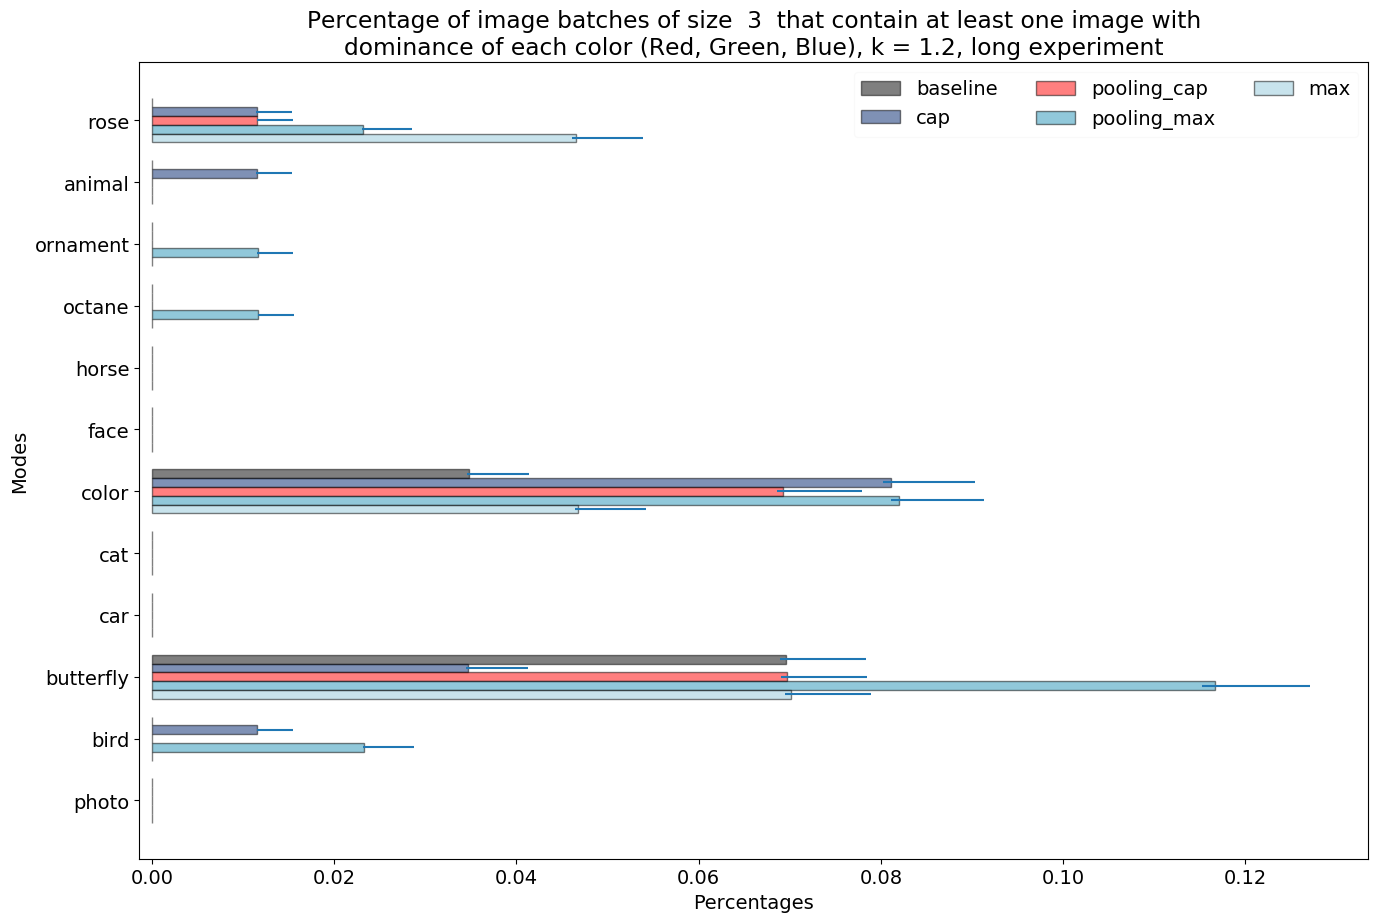

In [1116]:
get_graph(prompt_dic_3_K12, prompt_dic_3_K12_num, lf_3_K12, len(list(modes_3_K12)), modes_3_K12, sd = None,
          title = "Percentage of image batches of size  " + str(bs) + "  that contain at least one image with dominance of each color (Red, Green, Blue), k = " + str(k))

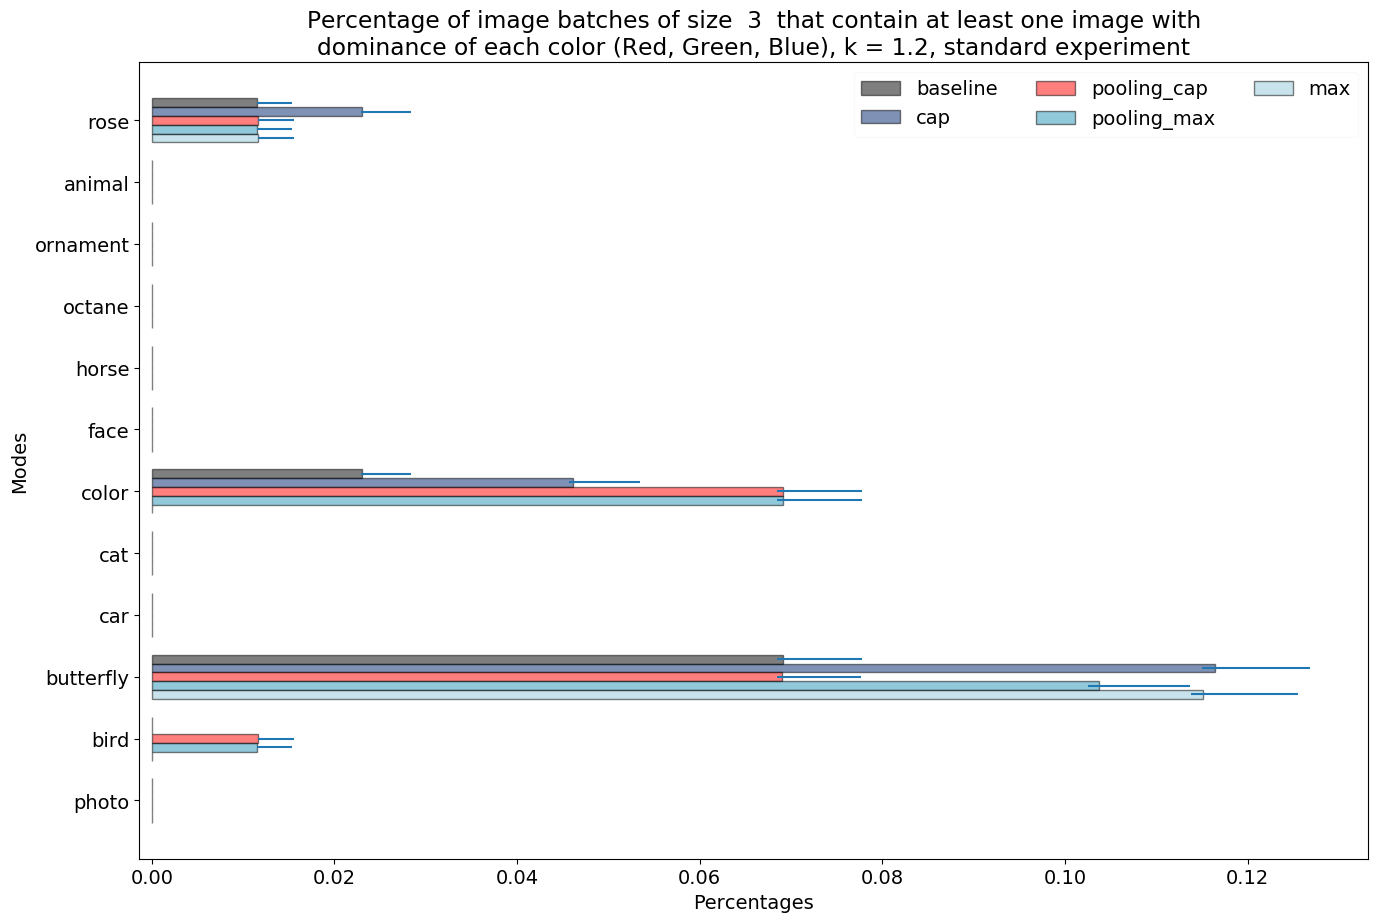

In [1117]:
get_graph(prompt_dic_3_K12, prompt_dic_3_K12_num, lf_3_K12, len(list(modes_3_K12)), modes_3_K12, sd = None,
          title = "Percentage of image batches of size  " + str(bs) + "  that contain at least one image with dominance of each color (Red, Green, Blue), k = " + str(k), updated_experiment = False )

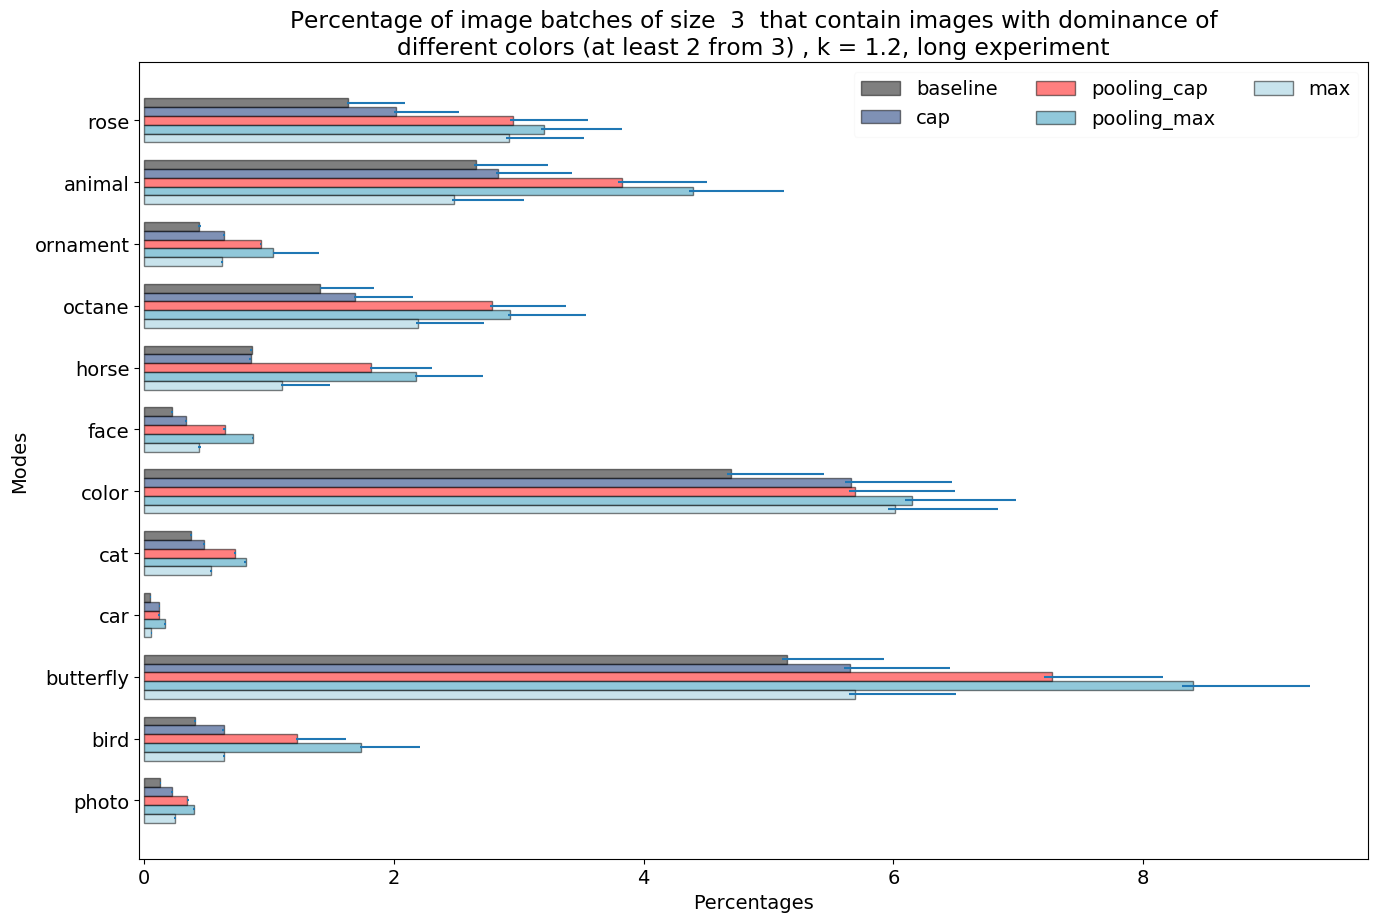

In [1118]:
get_graph(prompt_dic_3_K12_ss, prompt_dic_3_K12_num, lf_3_K12, len(list(modes_3_K12)), modes_3_K12, sd = None,
          title = "Percentage of image batches of size  " + str(bs) + "  that contain images with dominance of different colors (at least 2 from 3) , k = " + str(k))

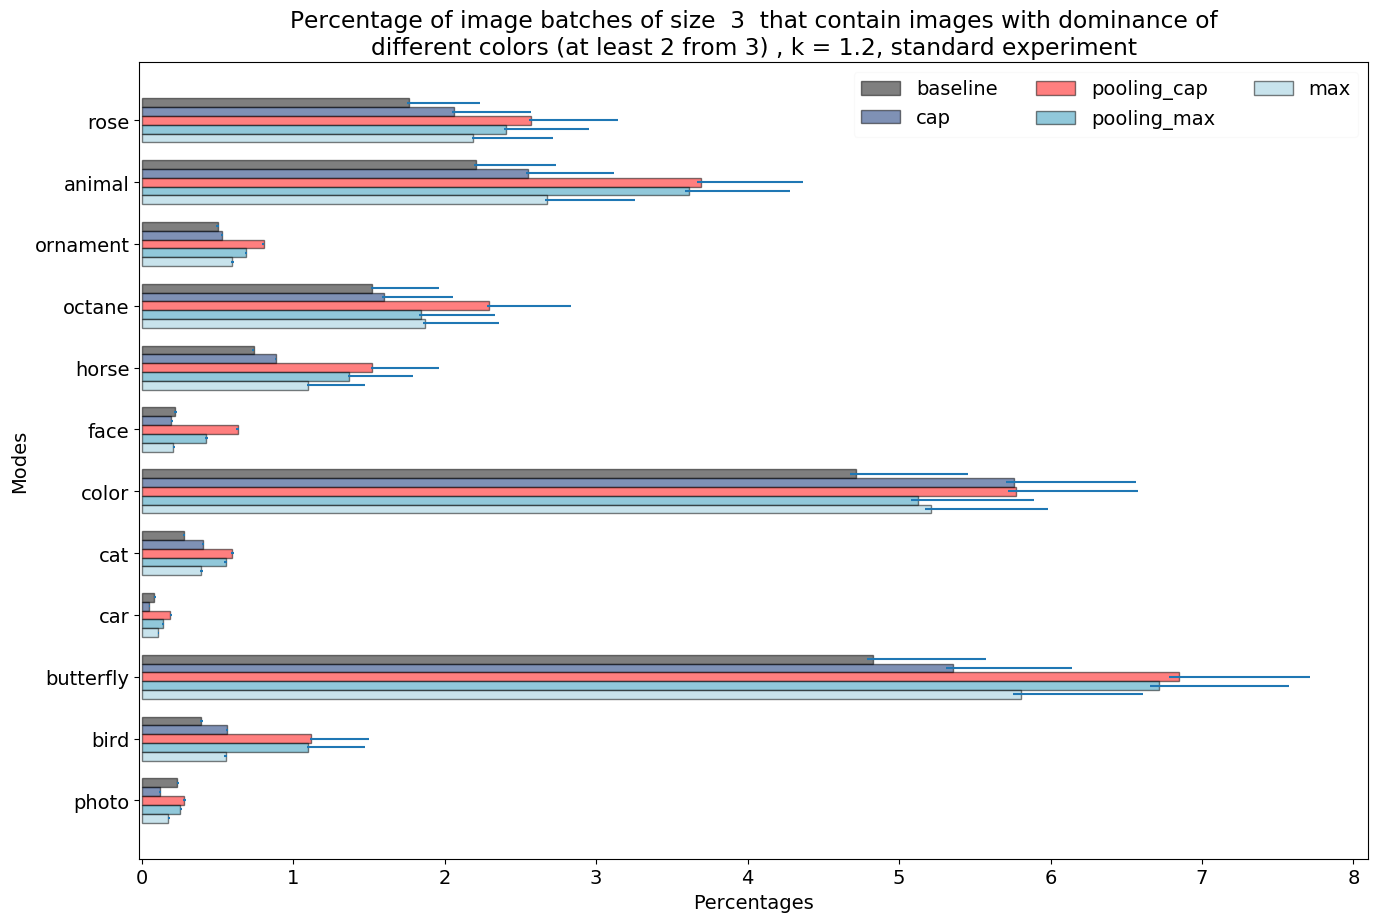

In [1119]:
get_graph(prompt_dic_3_K12_ss, prompt_dic_3_K12_num, lf_3_K12, len(list(modes_3_K12)), modes_3_K12, sd = None,
          title = "Percentage of image batches of size  " + str(bs) + "  that contain images with dominance of different colors (at least 2 from 3) , k = " + str(k), updated_experiment = False )

## batch size = 5

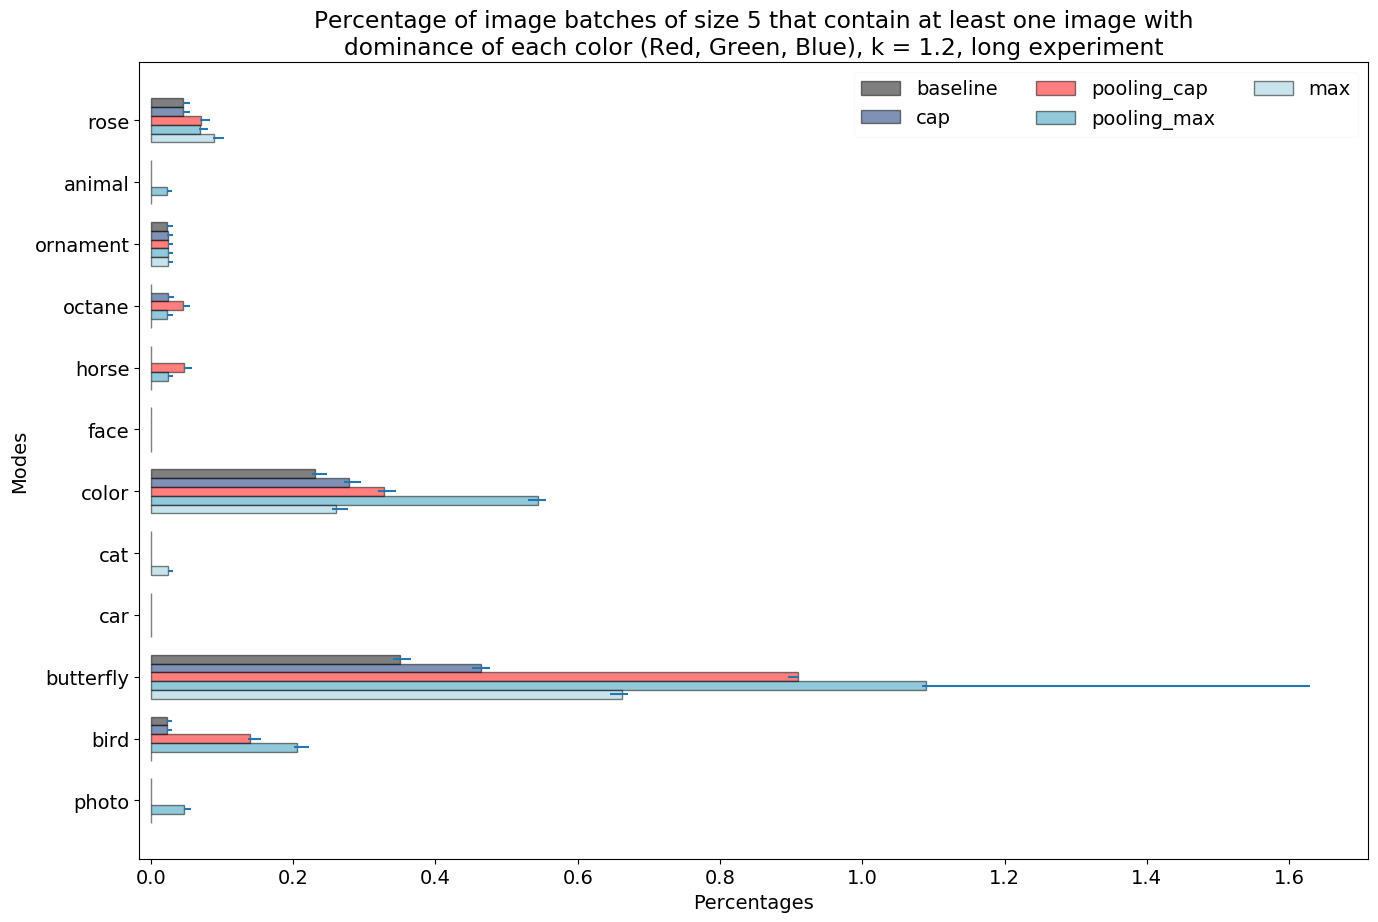

In [1120]:
get_graph(prompt_dic_5_K12, prompt_dic_5_K12_num, lf_5_K12, len(list(modes_5_K12)), modes_5_K12, sd = None,
          title = "Percentage of image batches of size 5 that contain at least one image with dominance of each color (Red, Green, Blue), k = " + str(k))

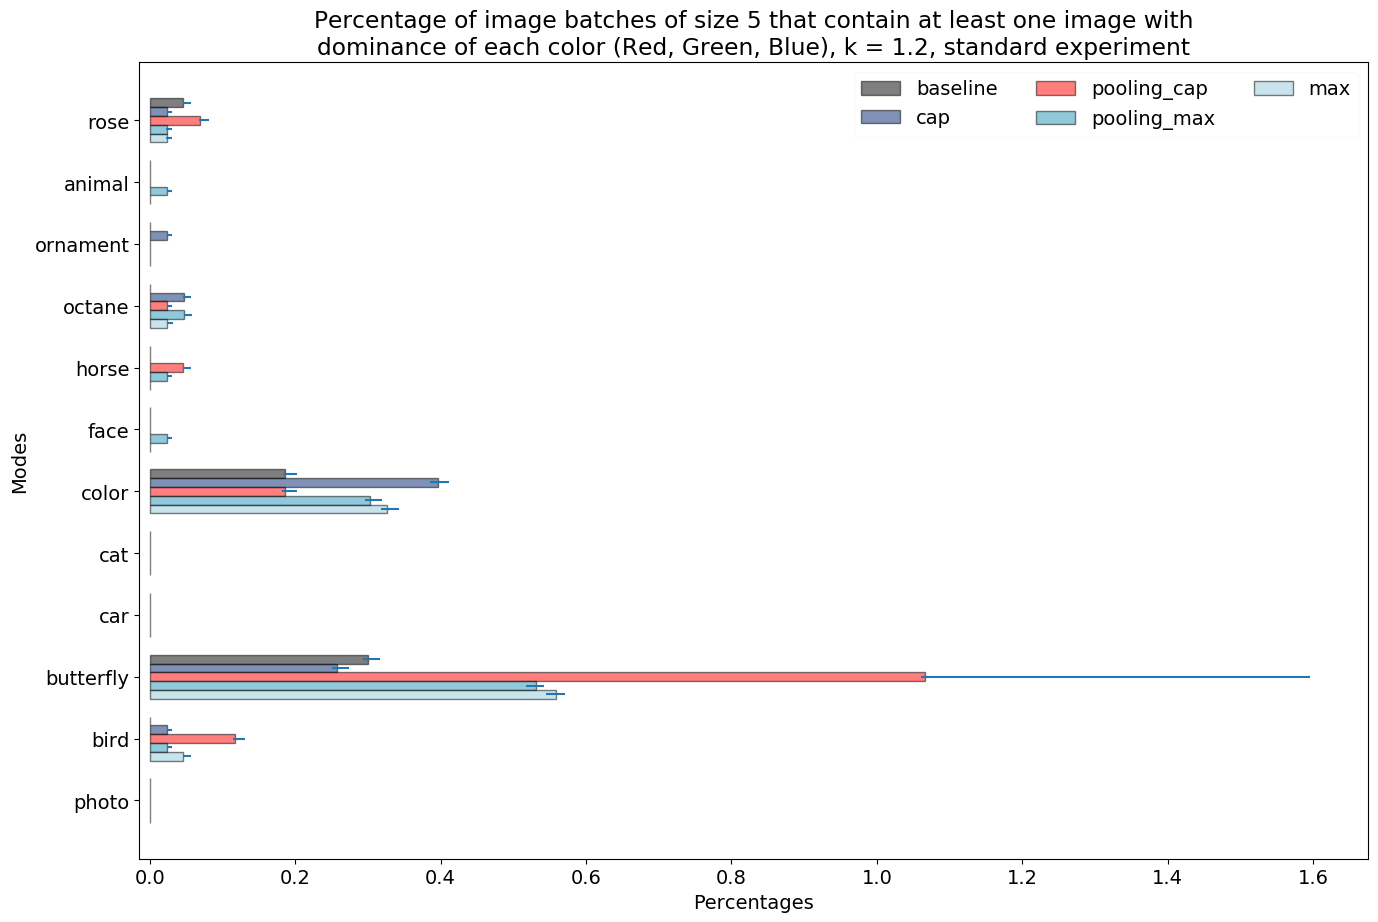

In [1121]:
get_graph(prompt_dic_5_K12, prompt_dic_5_K12_num, lf_5_K12, len(list(modes_5_K12)), modes_5_K12, sd = None,
          title = "Percentage of image batches of size 5 that contain at least one image with dominance of each color (Red, Green, Blue), k = " + str(k), updated_experiment = False )


In [1139]:
k = 1.2

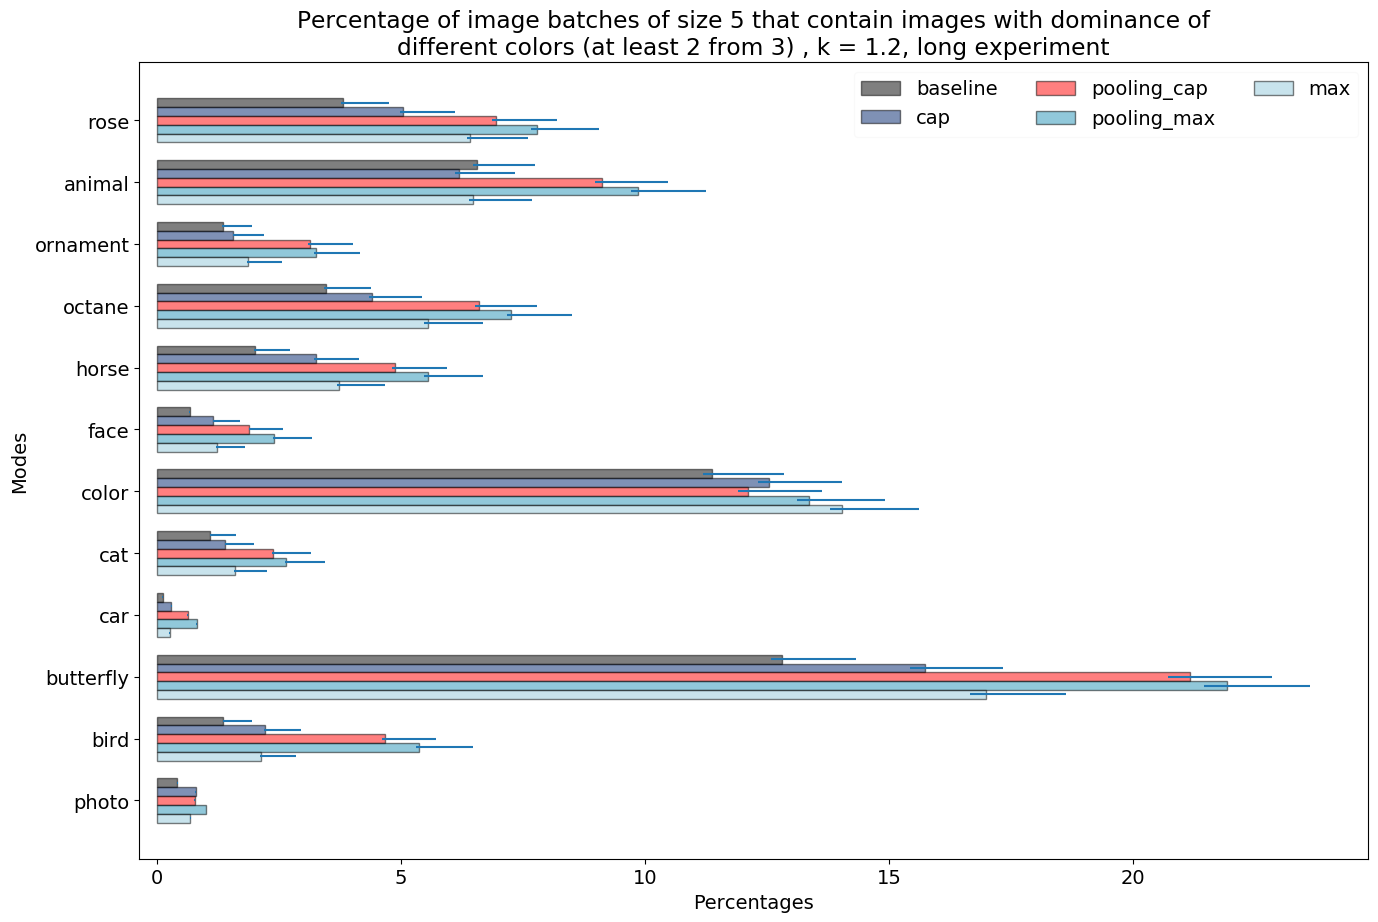

In [1140]:
get_graph(prompt_dic_5_K12_ss, prompt_dic_5_K12_num, lf_5_K12, len(list(modes_5_K12)), modes_5_K12, sd = None,
          title = "Percentage of image batches of size 5 that contain images with dominance of different colors (at least 2 from 3) , k = " + str(k))

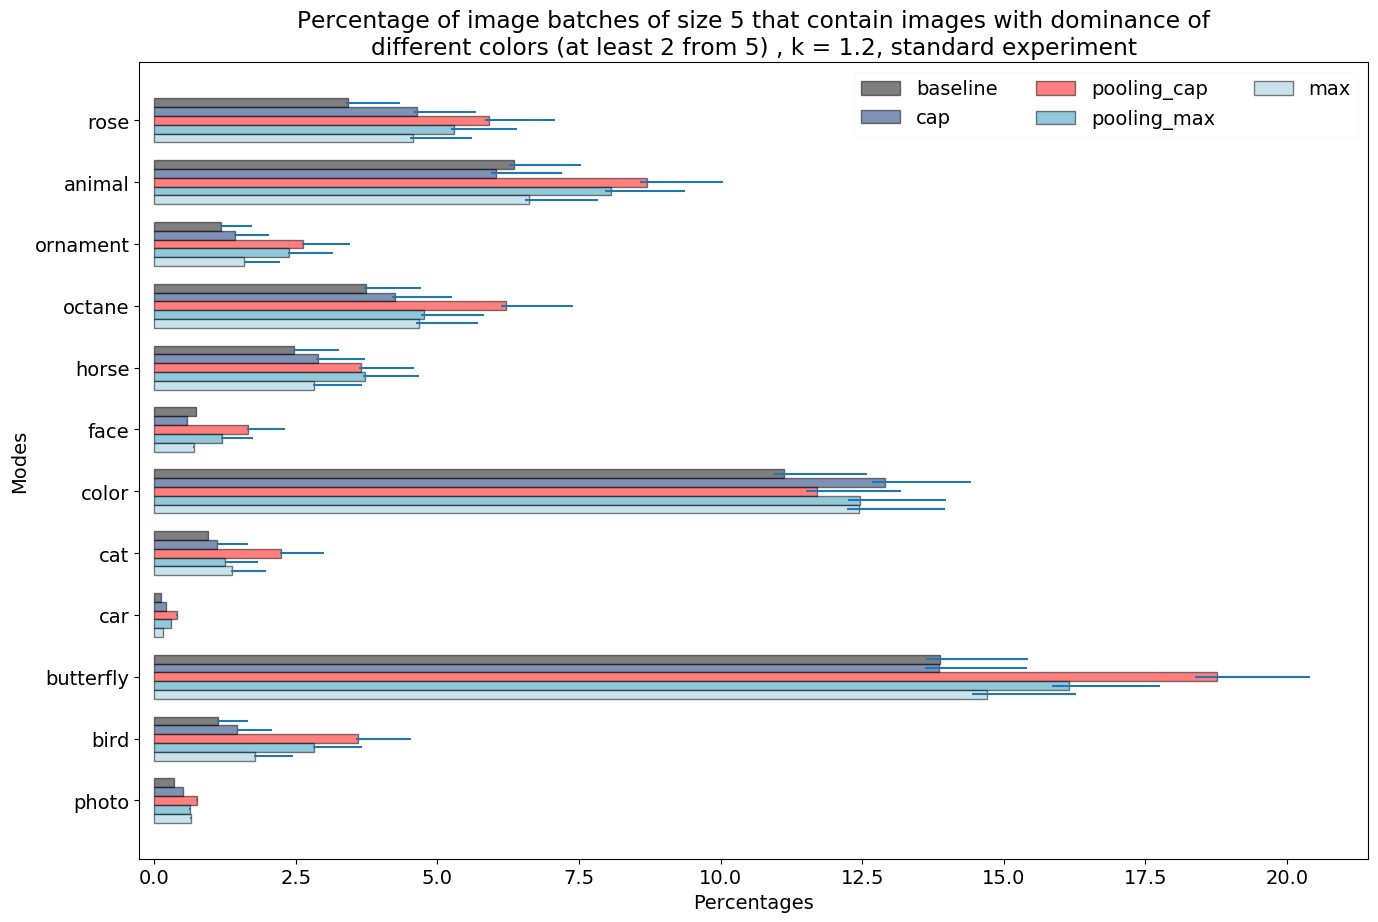

In [1123]:
get_graph(prompt_dic_5_K12_ss, prompt_dic_5_K12_num, lf_5_K12, len(list(modes_5_K12)), modes_5_K12, sd = None,
          title = "Percentage of image batches of size 5 that contain images with dominance of different colors (at least 2 from 5) , k = " + str(k), updated_experiment = False )

## batch size = 50

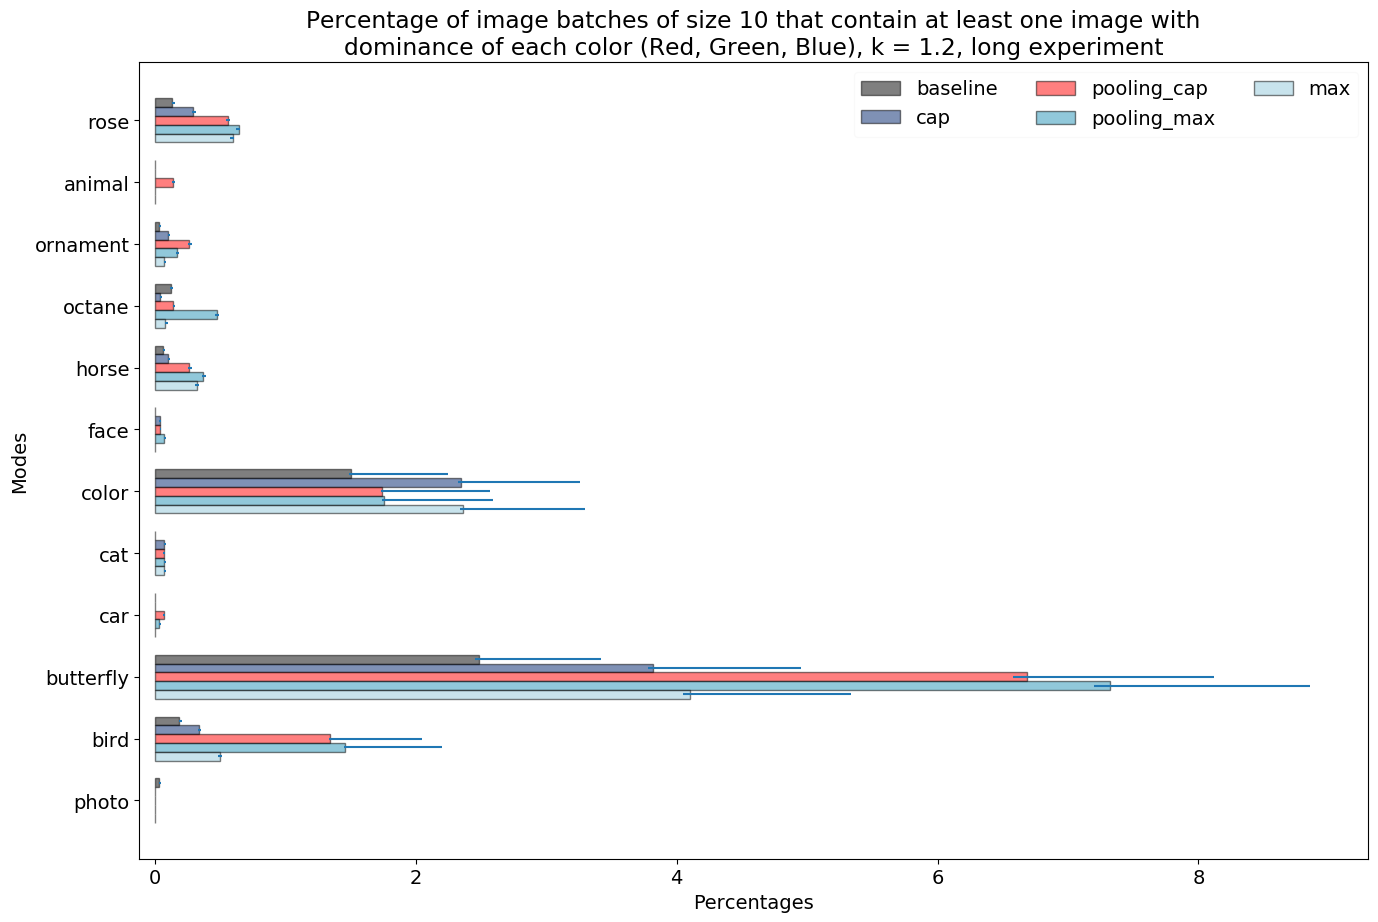

In [1124]:
get_graph(prompt_dic_10_K12, prompt_dic_10_K12_num, lf_10_K12, len(list(modes_10_K12)), modes_10_K12, sd = None,
          title = "Percentage of image batches of size 10 that contain at least one image with dominance of each color (Red, Green, Blue), k = " + str(k))

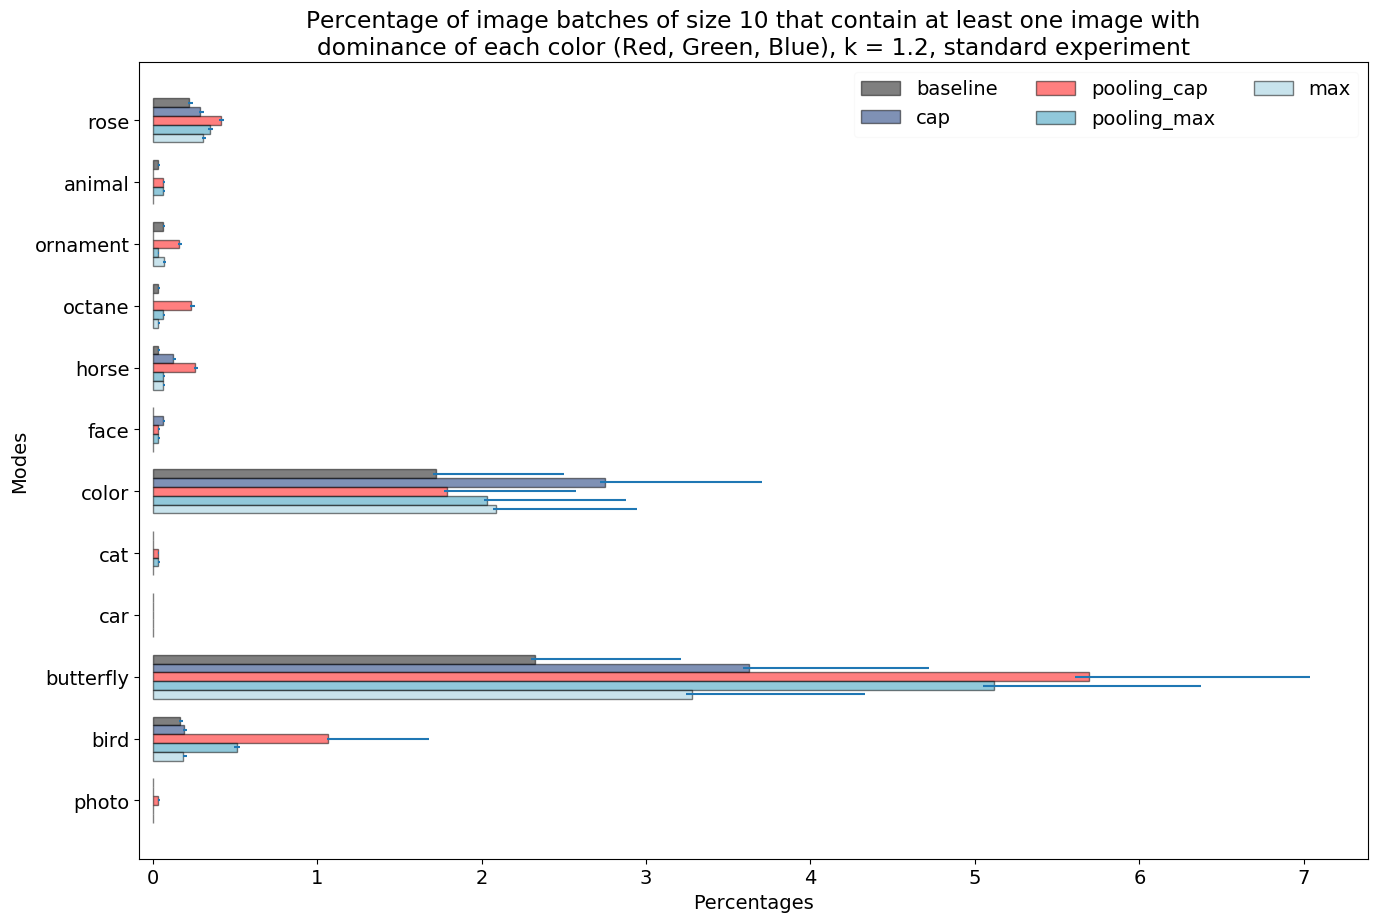

In [1125]:
get_graph(prompt_dic_10_K12, prompt_dic_10_K12_num, lf_10_K12, len(list(modes_10_K12)), modes_10_K12, sd = None,
          title = "Percentage of image batches of size 10 that contain at least one image with dominance of each color (Red, Green, Blue), k = " + str(k), updated_experiment = False )

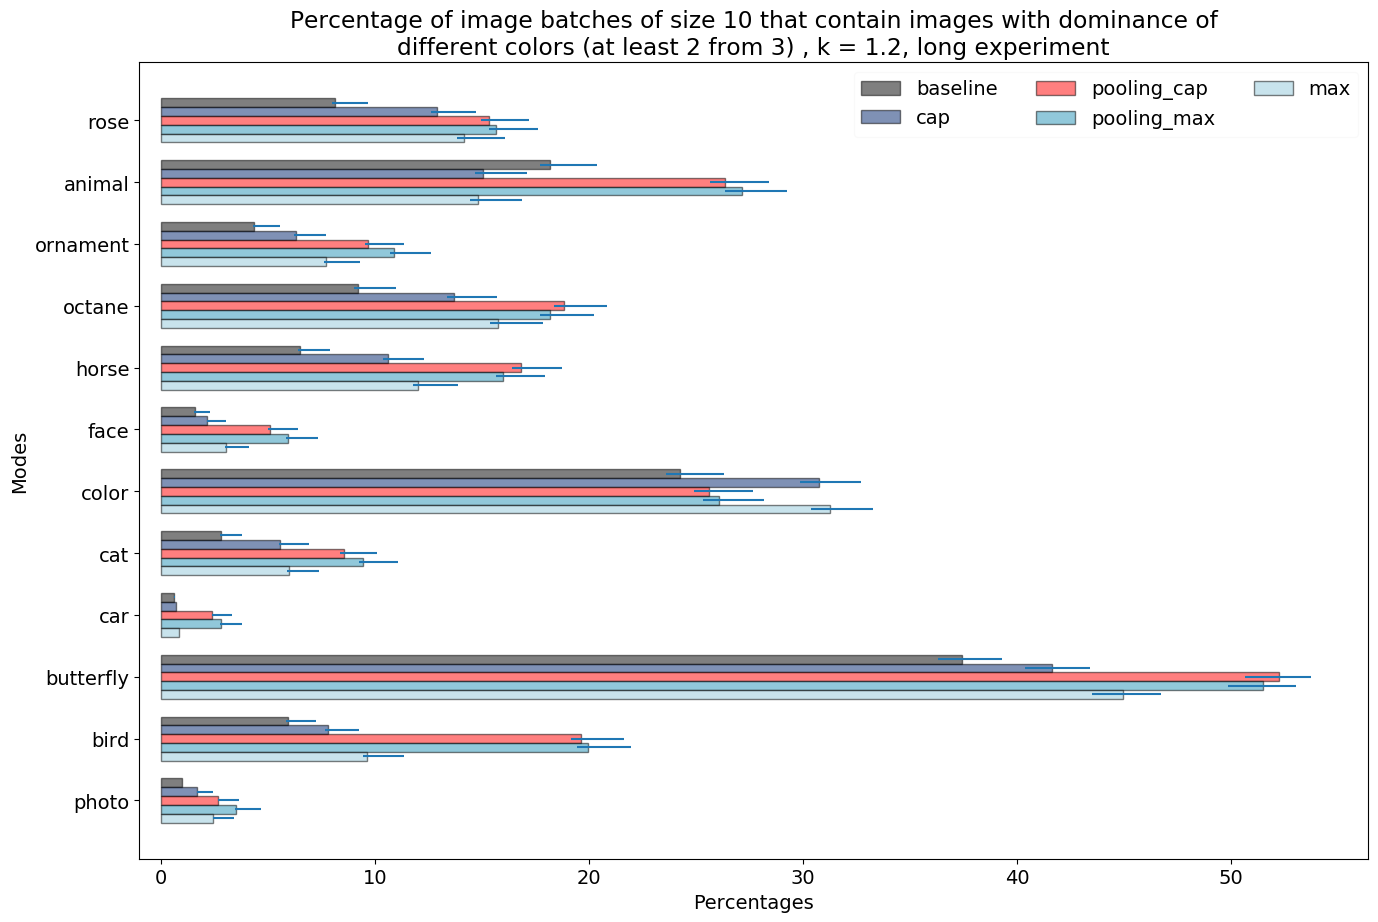

In [1142]:
get_graph(prompt_dic_10_K12_ss, prompt_dic_10_K12_num, lf_10_K12, len(list(modes_10_K12)), modes_10_K12, sd = None,
          title = "Percentage of image batches of size 10 that contain images with dominance of different colors (at least 2 from 3) , k = " + str(k))

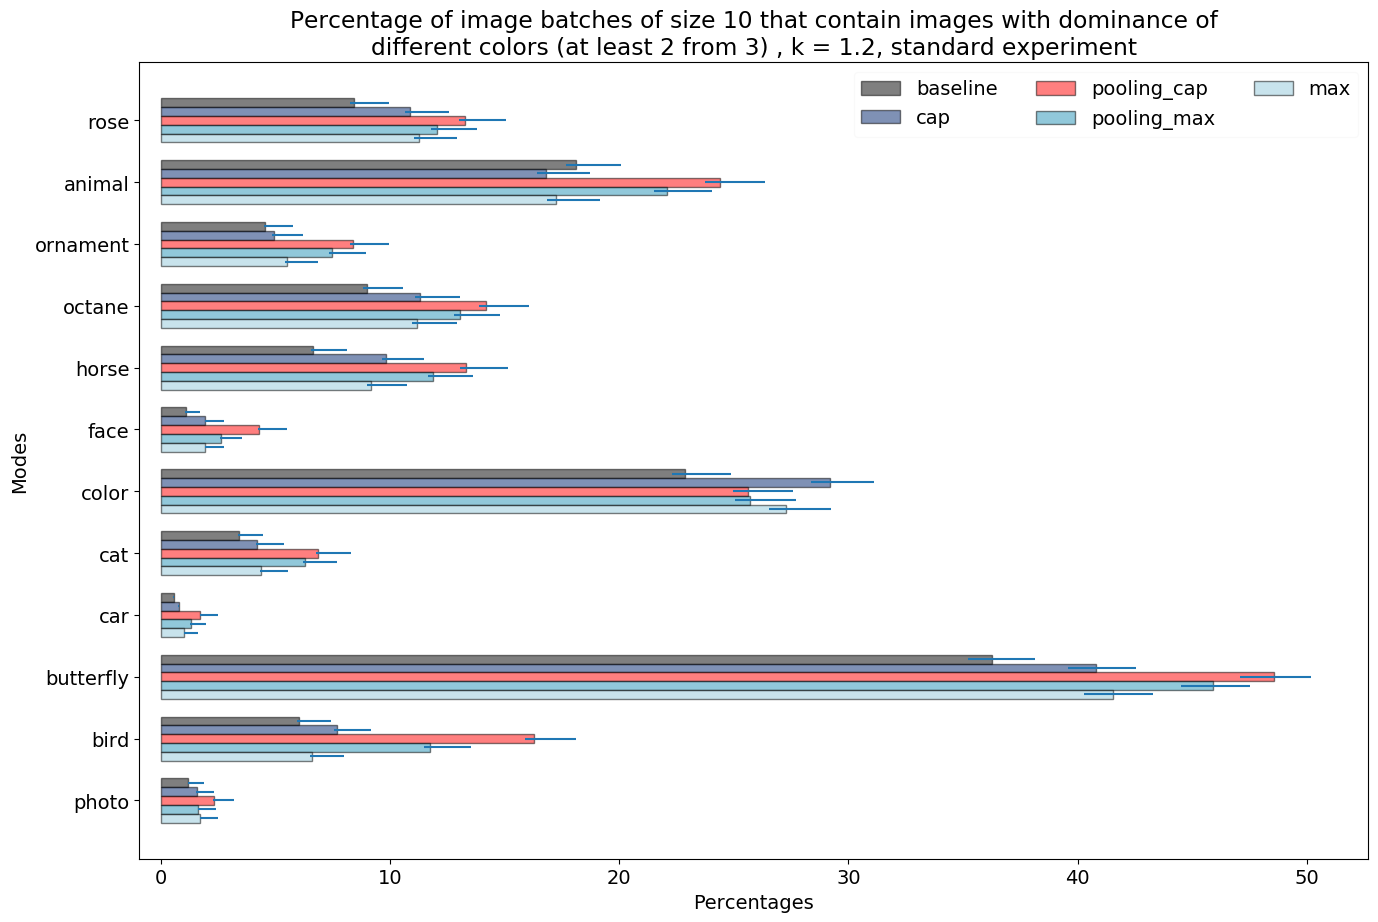

In [1141]:
get_graph(prompt_dic_10_K12_ss, prompt_dic_10_K12_num, lf_10_K12, len(list(modes_10_K12)), modes_10_K12, sd = None,
          title = "Percentage of image batches of size 10 that contain images with dominance of different colors (at least 2 from 3) , k = " + str(k), updated_experiment = False )

# K = 1.1


## batch size = 3

In [1143]:
k = 1.1

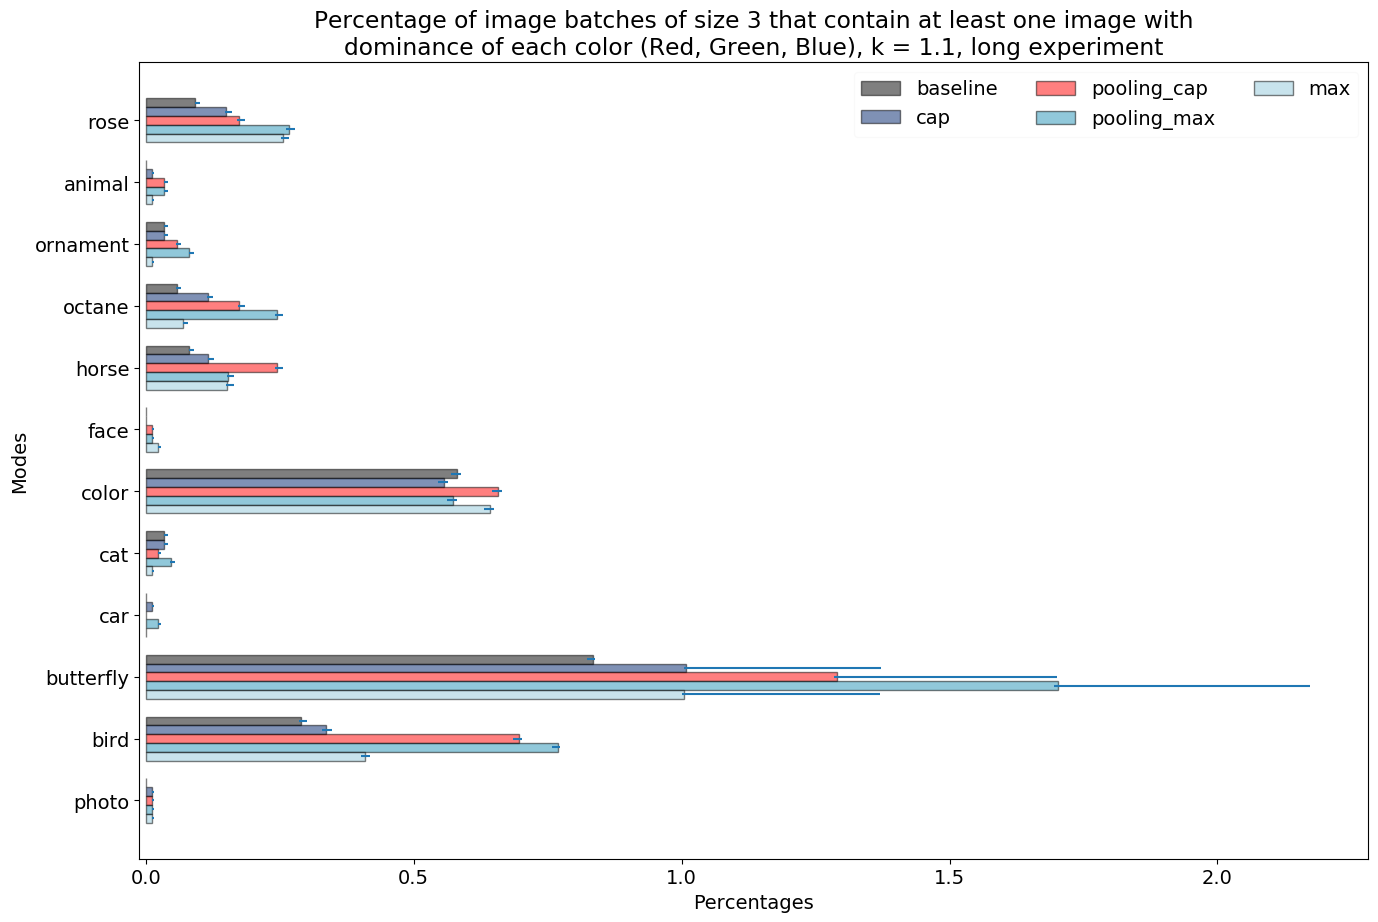

In [1129]:
get_graph(prompt_dic_3_K11, prompt_dic_3_K11_num, lf_3_K11, len(list(modes_3_K11)), modes_3_K11, sd = None,
          title = "Percentage of image batches of size 3 that contain at least one image with dominance of each color (Red, Green, Blue), k = " + str(k))

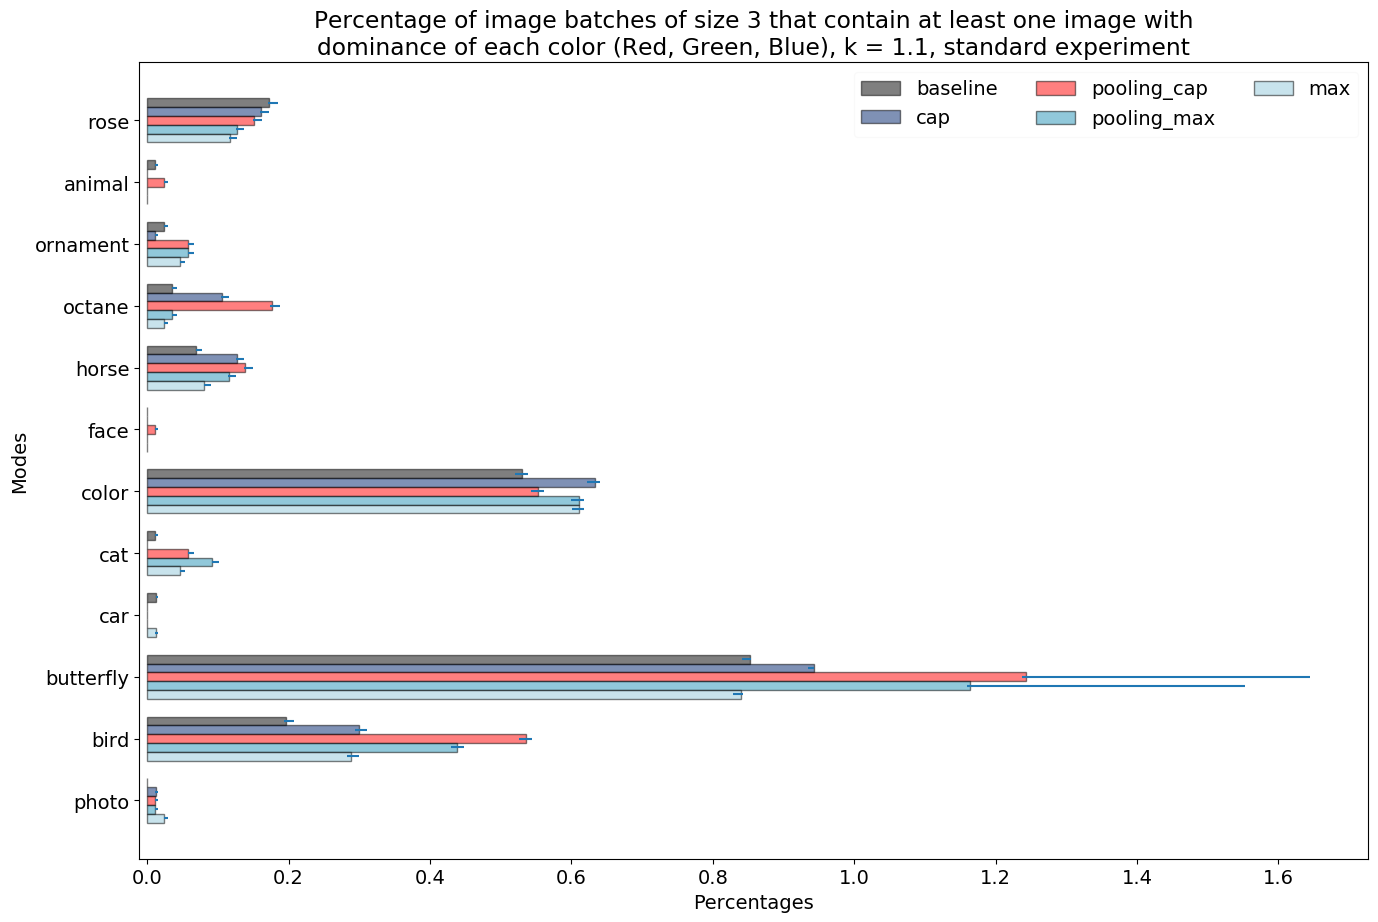

In [1130]:
get_graph(prompt_dic_3_K11, prompt_dic_3_K11_num, lf_3_K11, len(list(modes_3_K11)), modes_3_K11, sd = None,
          title = "Percentage of image batches of size 3 that contain at least one image with dominance of each color (Red, Green, Blue), k = " + str(k), updated_experiment = False )

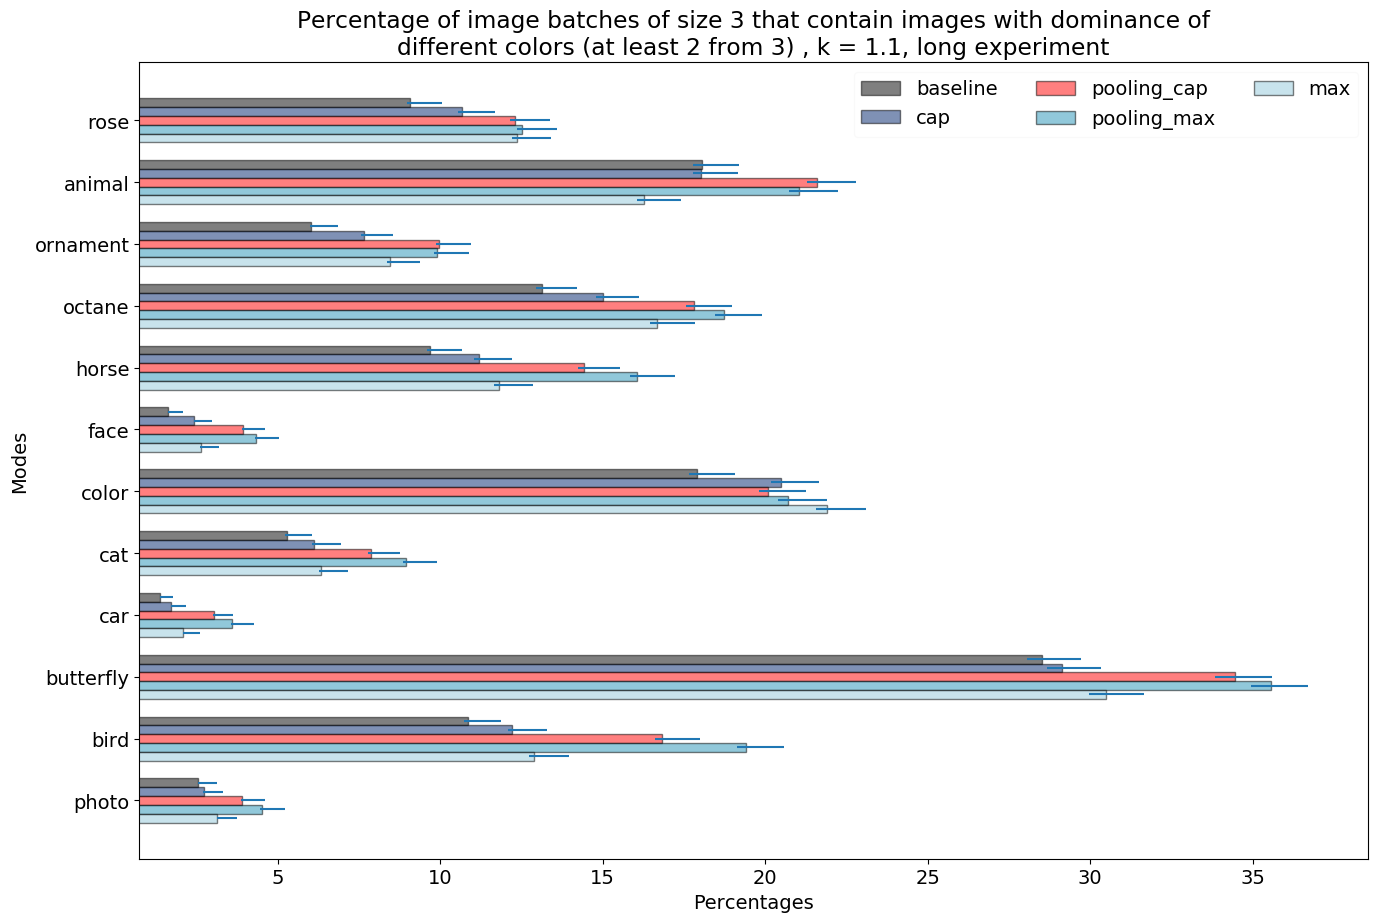

In [1131]:
get_graph(prompt_dic_3_K11_ss, prompt_dic_3_K11_num, lf_3_K11, len(list(modes_3_K11)), modes_3_K11, sd = None,
          title = "Percentage of image batches of size 3 that contain images with dominance of different colors (at least 2 from 3) , k = " + str(k))

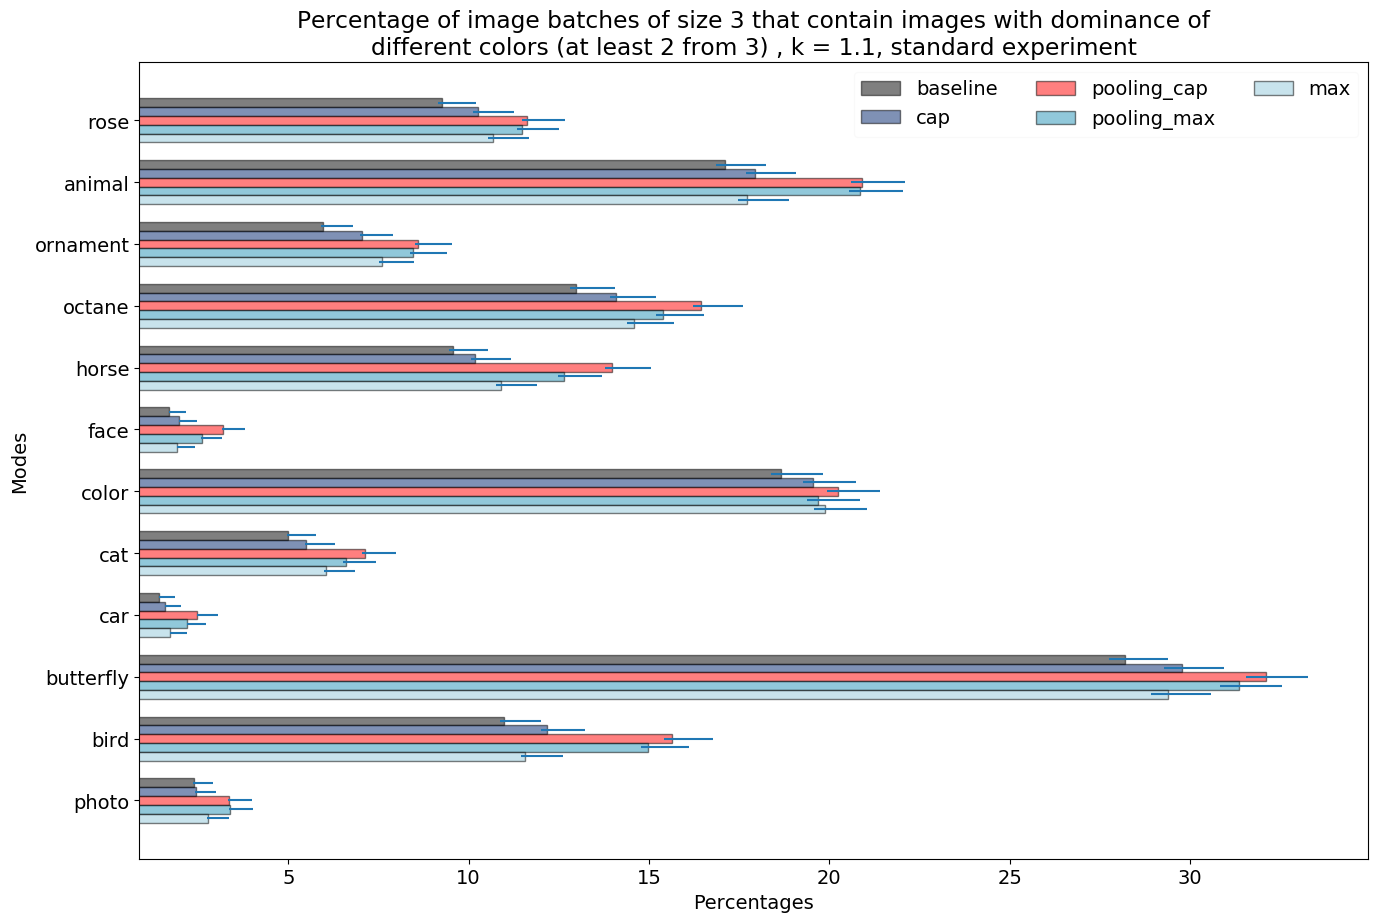

In [1132]:
get_graph(prompt_dic_3_K11_ss, prompt_dic_3_K11_num, lf_3_K11, len(list(modes_3_K11)), modes_3_K11, sd = None,
          title = "Percentage of image batches of size 3 that contain images with dominance of different colors (at least 2 from 3) , k = " + str(k), updated_experiment = False )

## batch size = 5

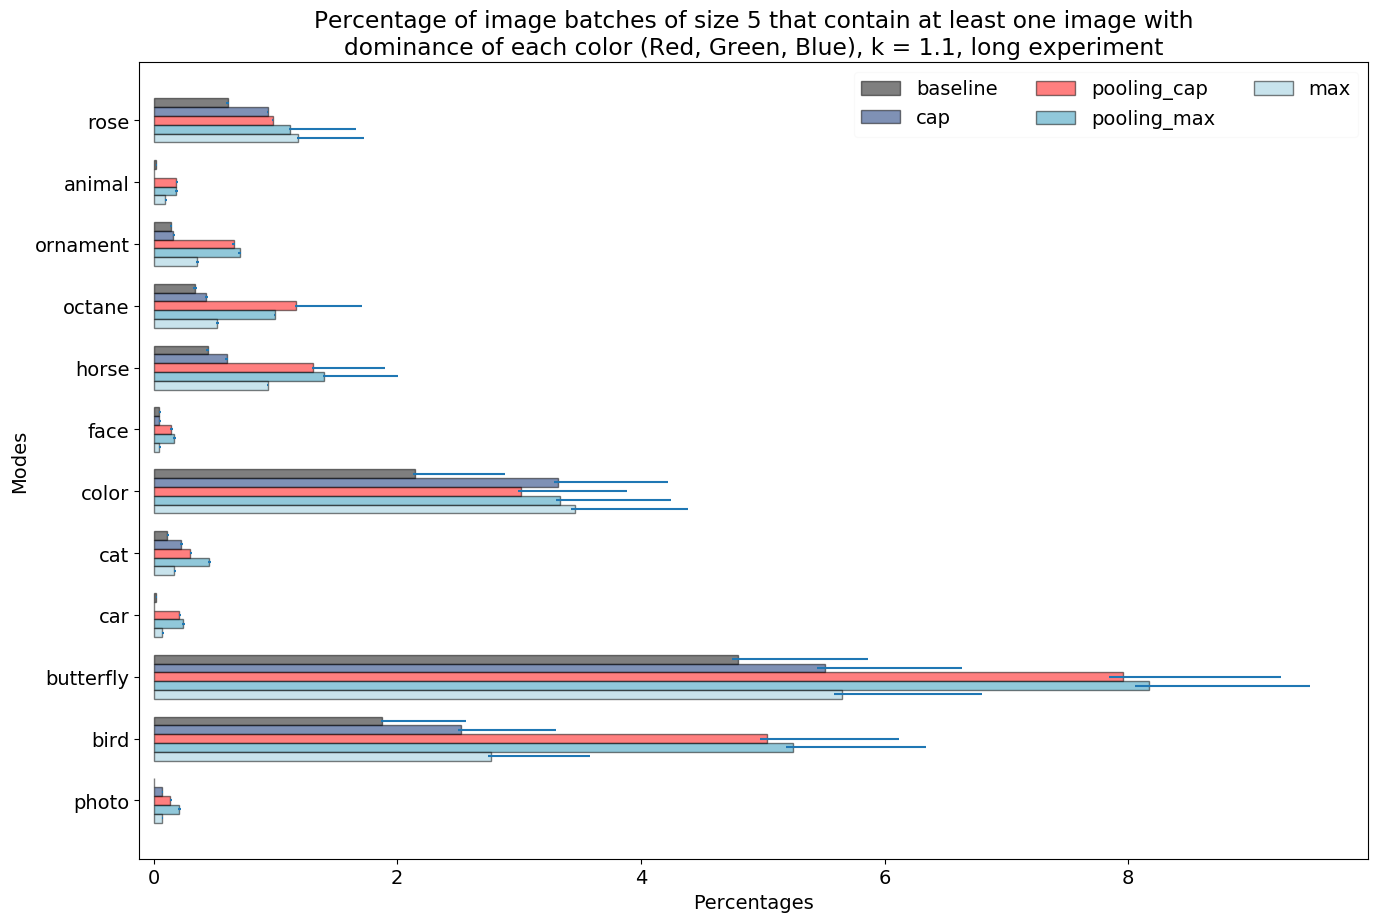

In [1133]:
get_graph(prompt_dic_5_K11, prompt_dic_5_K11_num, lf_5_K11, len(list(modes_5_K11)), modes_5_K11, sd = None,
          title = "Percentage of image batches of size 5 that contain at least one image with dominance of each color (Red, Green, Blue), k = " + str(k))

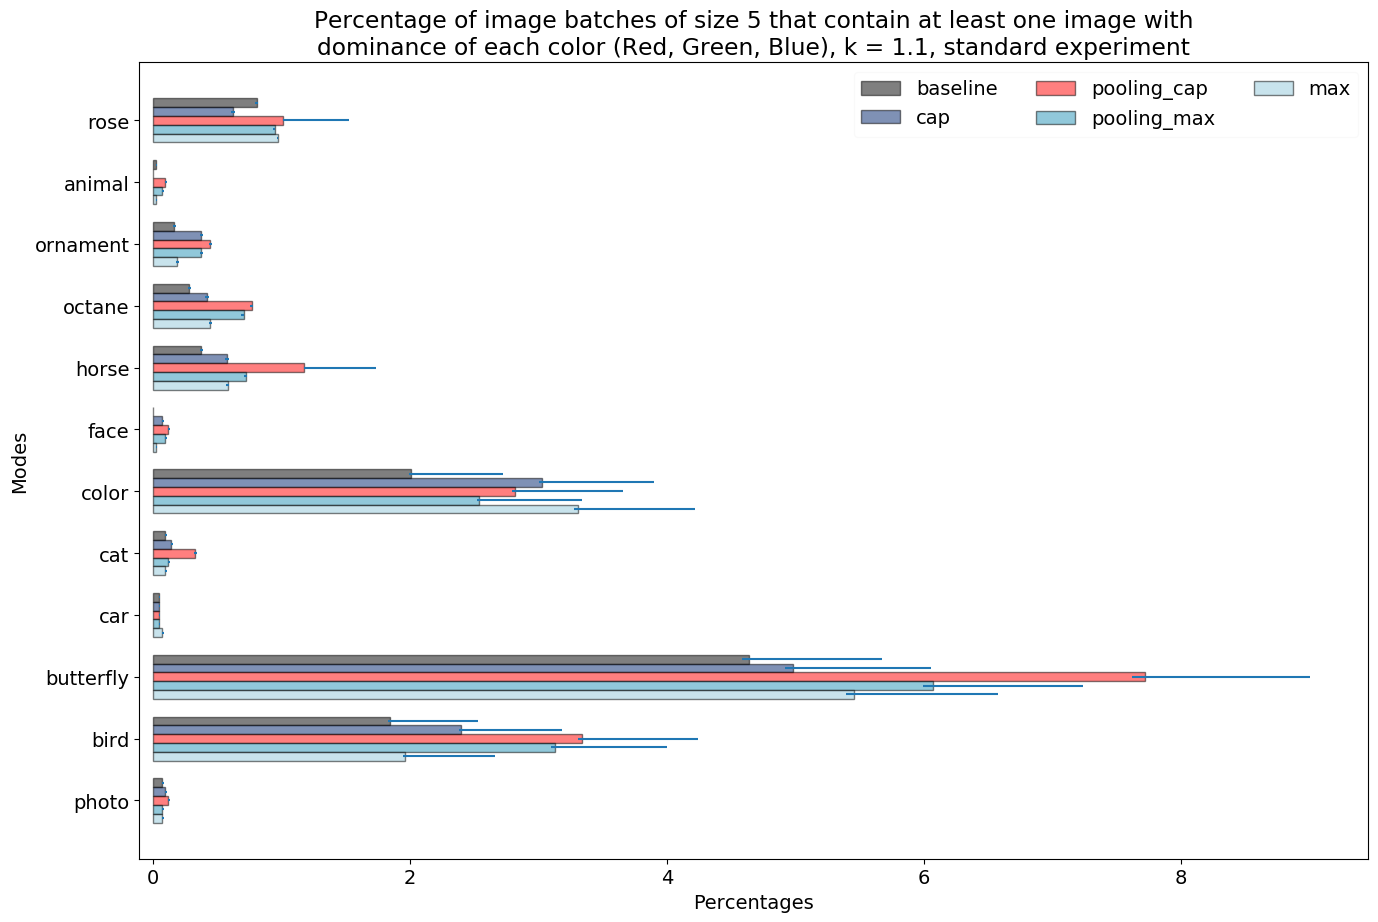

In [1134]:
get_graph(prompt_dic_5_K11, prompt_dic_5_K11_num, lf_5_K11, len(list(modes_5_K11)), modes_5_K11, sd = None,
          title = "Percentage of image batches of size 5 that contain at least one image with dominance of each color (Red, Green, Blue), k = " + str(k), updated_experiment = False )

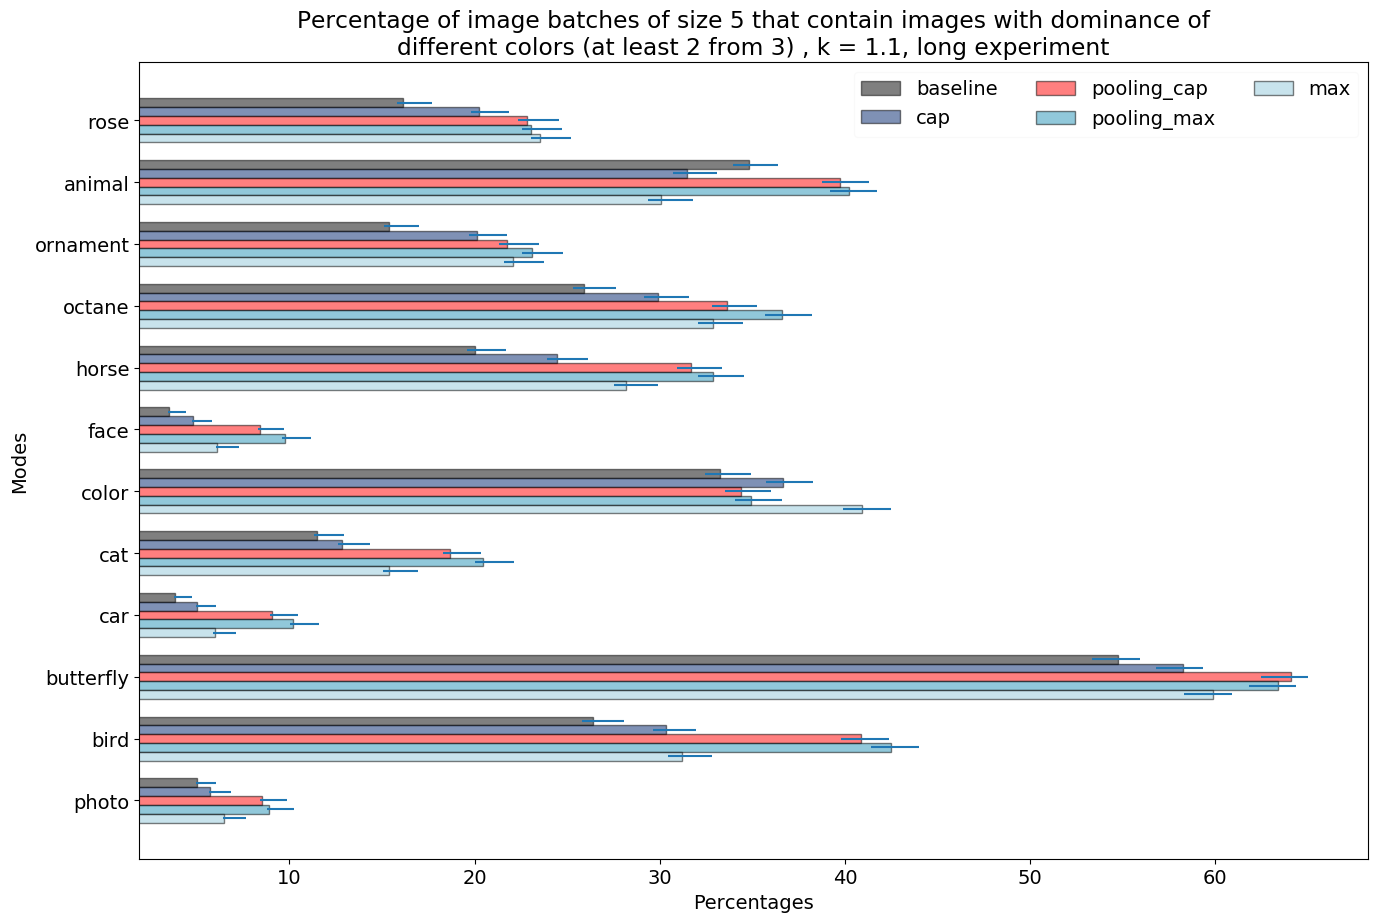

In [1144]:
get_graph(prompt_dic_5_K11_ss, prompt_dic_5_K11_num, lf_5_K11, len(list(modes_5_K11)), modes_5_K11, sd = None,
          title = "Percentage of image batches of size 5 that contain images with dominance of different colors (at least 2 from 3) , k = " + str(k))

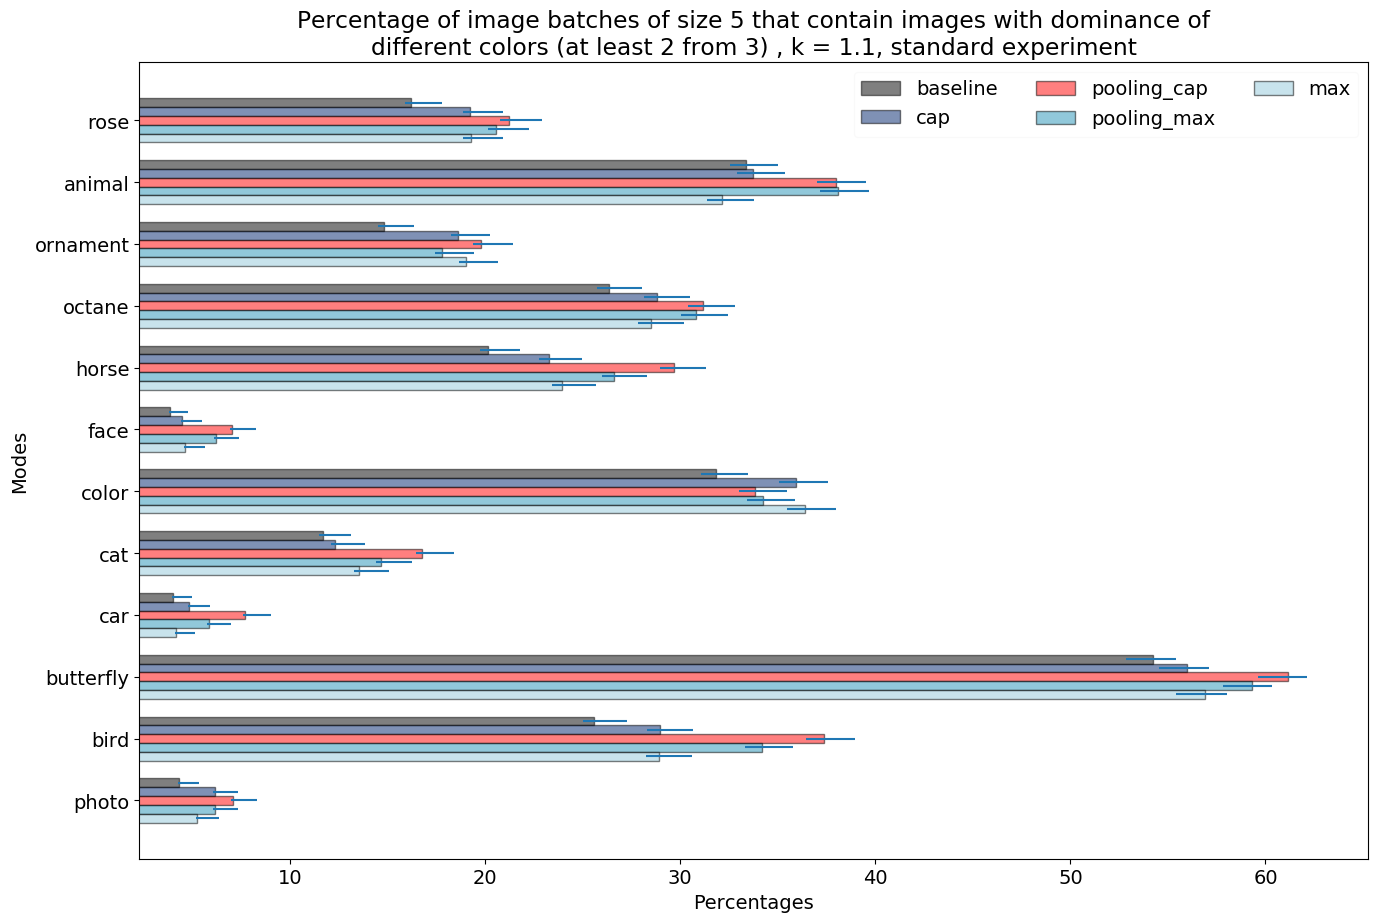

In [1145]:
get_graph(prompt_dic_5_K11_ss, prompt_dic_5_K11_num, lf_5_K11, len(list(modes_5_K11)), modes_5_K11, sd = None,
          title = "Percentage of image batches of size 5 that contain images with dominance of different colors (at least 2 from 3) , k = " + str(k), updated_experiment = False )

## batch size = 10

In [1151]:
modes = modes_10

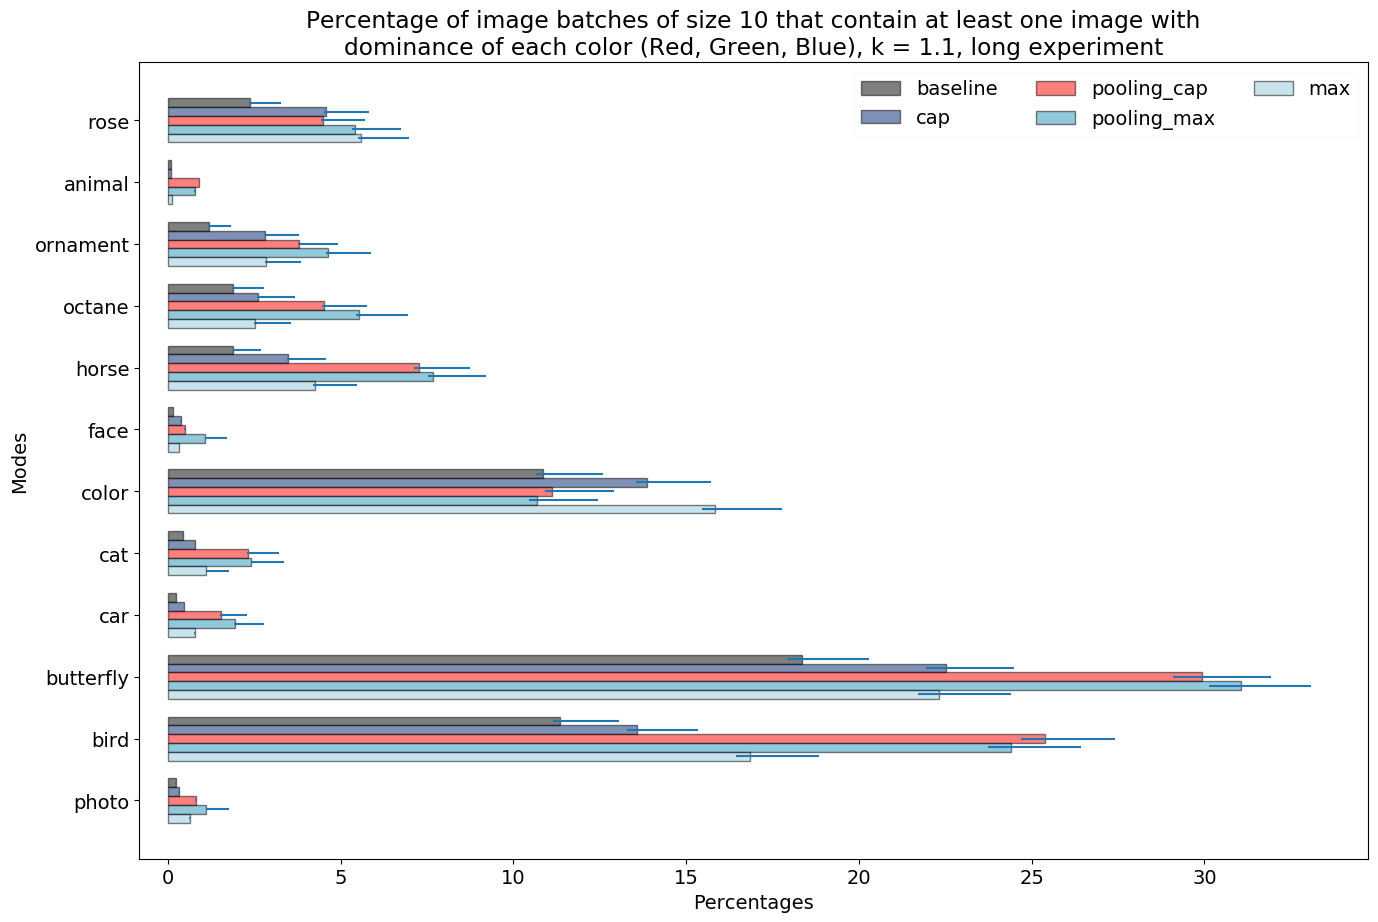

In [1150]:
get_graph(prompt_dic_10_K11, prompt_dic_10_K11_num, lf_10_K11, len(list(modes_10)), modes_10, sd = None,
          title = "Percentage of image batches of size 10 that contain at least one image with dominance of each color (Red, Green, Blue), k = " + str(k))

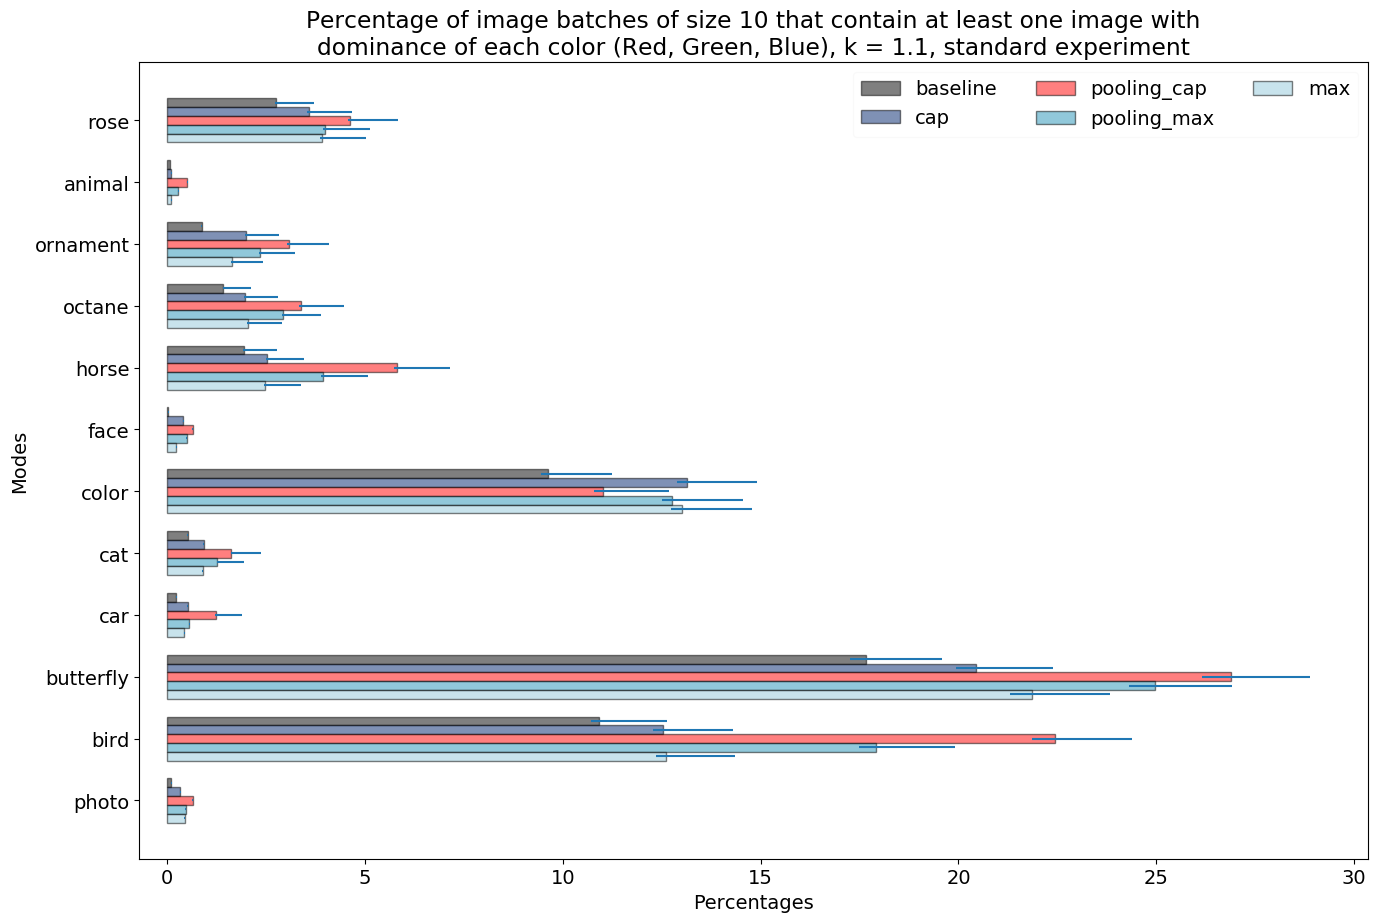

In [1152]:
get_graph(prompt_dic_10_K11, prompt_dic_10_K11_num, lf_10_K11, len(list(modes)), modes, sd = None,
          title = "Percentage of image batches of size 10 that contain at least one image with dominance of each color (Red, Green, Blue), k = " + str(k), updated_experiment = False )

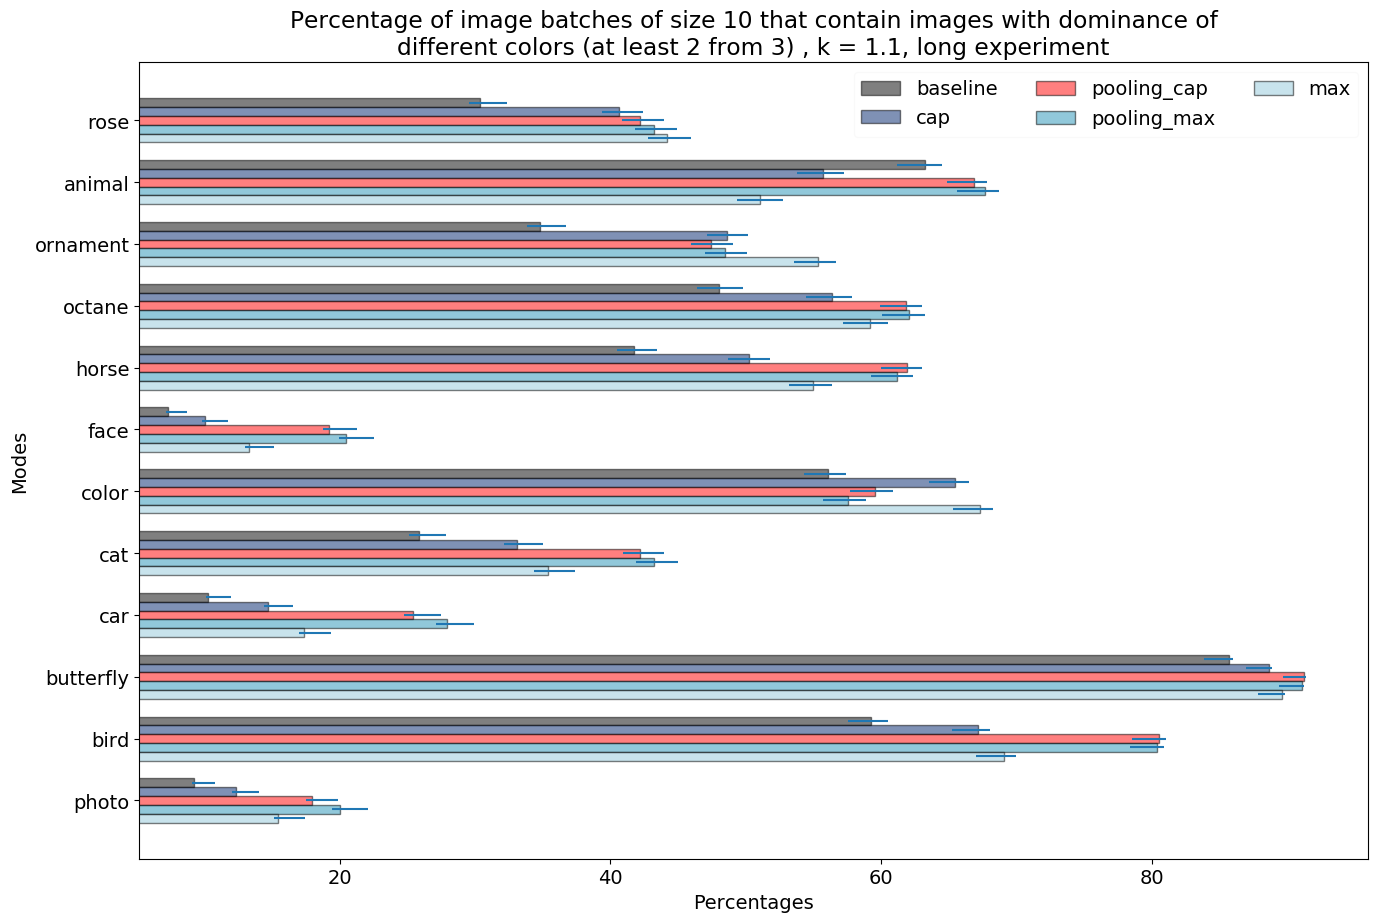

In [1153]:
get_graph(prompt_dic_10_K11_ss, prompt_dic_10_K11_num, lf_10_K11, len(list(modes)), modes, sd = None,
          title = "Percentage of image batches of size 10 that contain images with dominance of different colors (at least 2 from 3) , k = " + str(k))

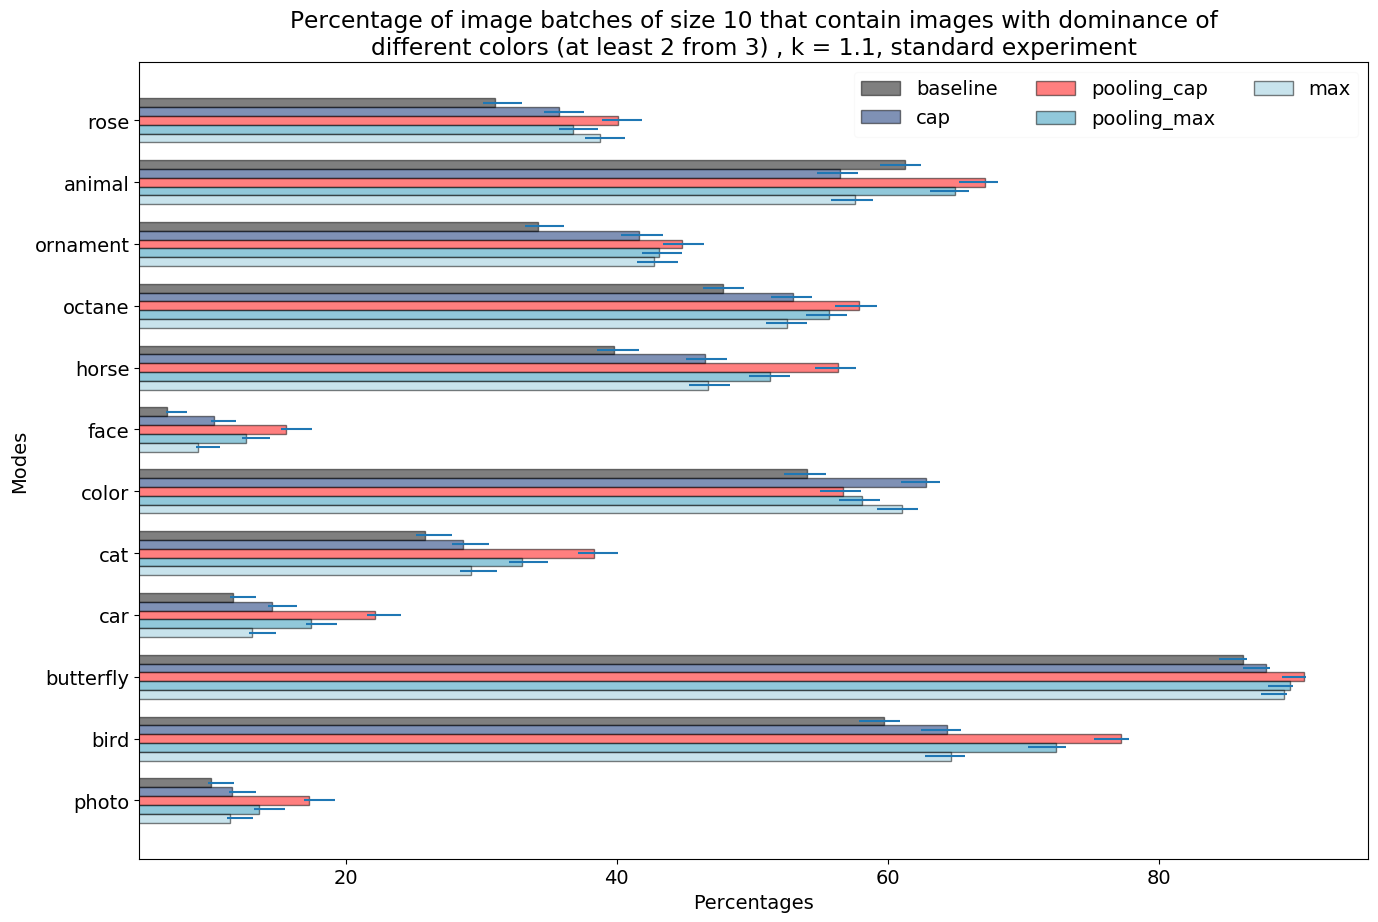

In [1154]:
get_graph(prompt_dic_10_K11_ss, prompt_dic_10_K11_num, lf_10_K11, len(list(modes)), modes, sd = None,
          title = "Percentage of image batches of size 10 that contain images with dominance of different colors (at least 2 from 3) , k = " + str(k), updated_experiment = False )

## batch size = 10

In [1164]:
modes = modes_50
k = 1.1

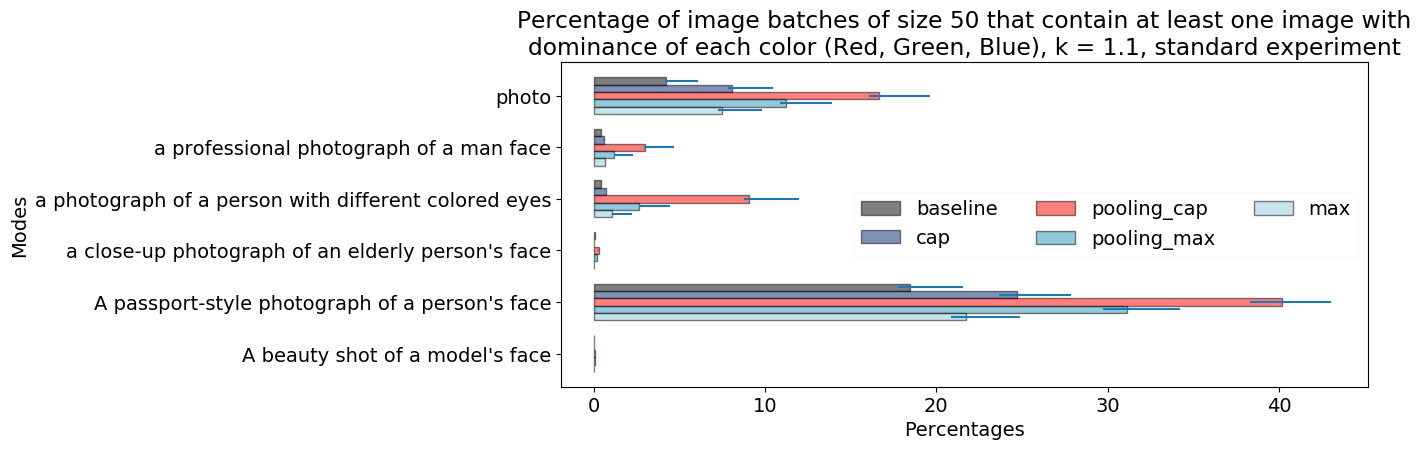

In [1165]:
get_graph(prompt_dic_50_K11, prompt_dic_50_K11_num, lf_50_K11, len(list(modes)), modes, sd = None,
          title = "Percentage of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue), k = " + str(k), updated_experiment = False )

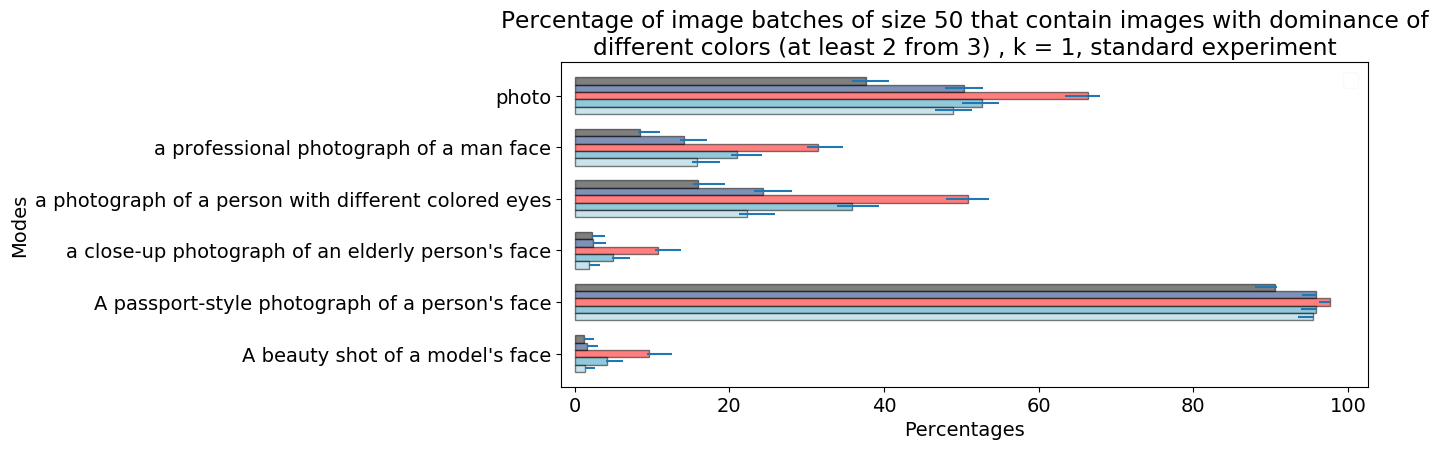

In [1180]:
get_graph(prompt_dic_50_K11_ss, prompt_dic_50_K11_num, lf_50_K11, len(list(modes)), modes, sd = None,
          title = "Percentage of image batches of size 50 that contain images with dominance of different colors (at least 2 from 3) , k = " + str(k), updated_experiment = False )

In [1167]:
k = 1.2

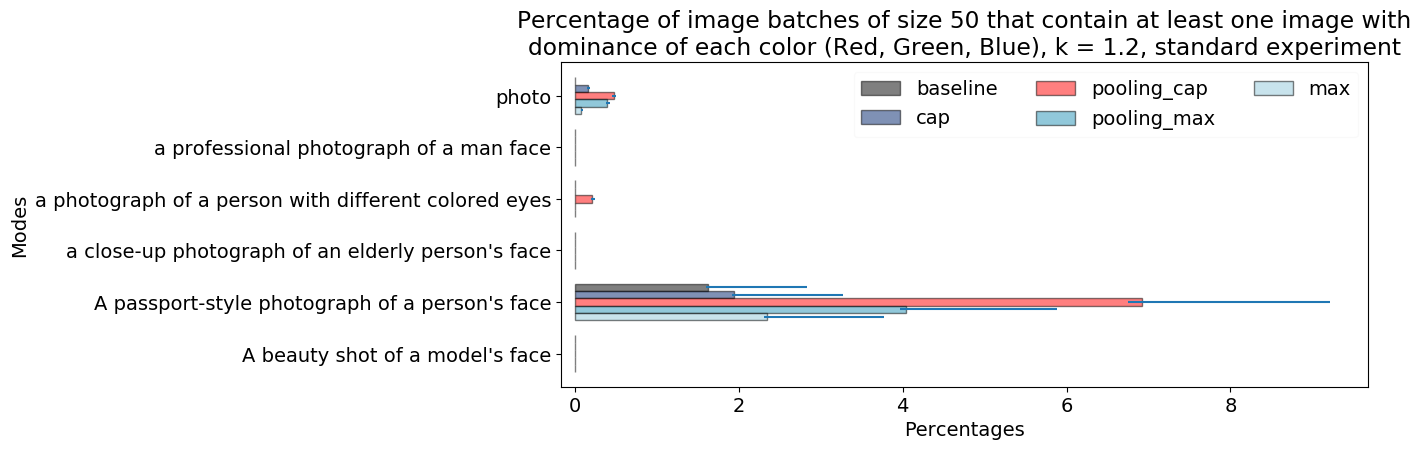

In [1168]:
get_graph(prompt_dic_50_K12, prompt_dic_50_K12_num, lf_50_K12, len(list(modes)), modes, sd = None,
          title = "Percentage of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue), k = " + str(k), updated_experiment = False )

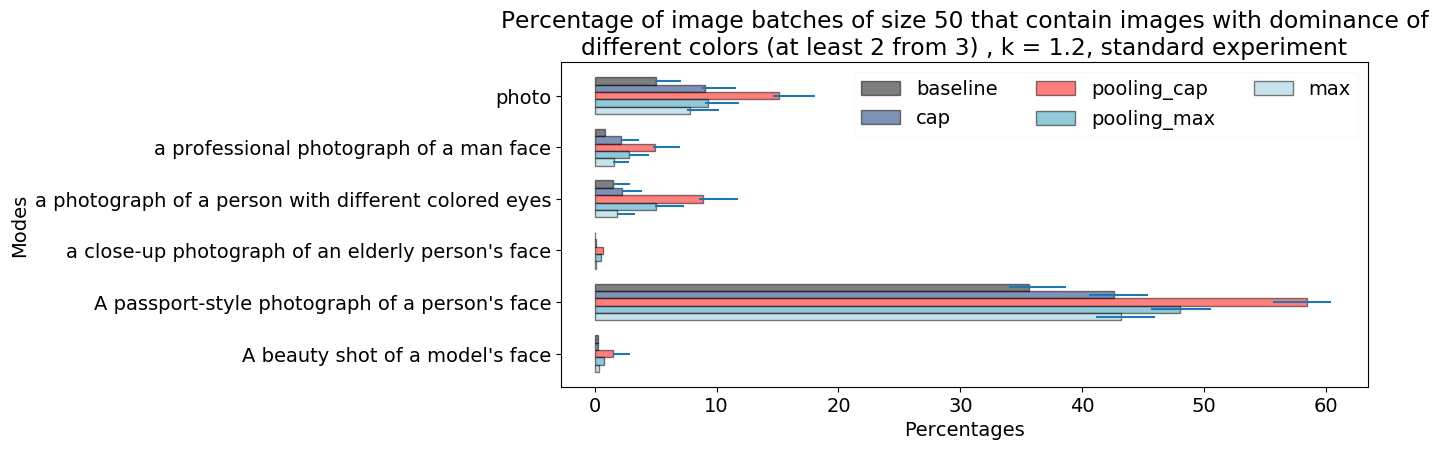

In [1169]:
get_graph(prompt_dic_50_K12_ss, prompt_dic_50_K12_num, lf_50_K12, len(list(modes)), modes, sd = None,
          title = "Percentage of image batches of size 50 that contain images with dominance of different colors (at least 2 from 3) , k = " + str(k), updated_experiment = False )

In [1170]:
k = 1

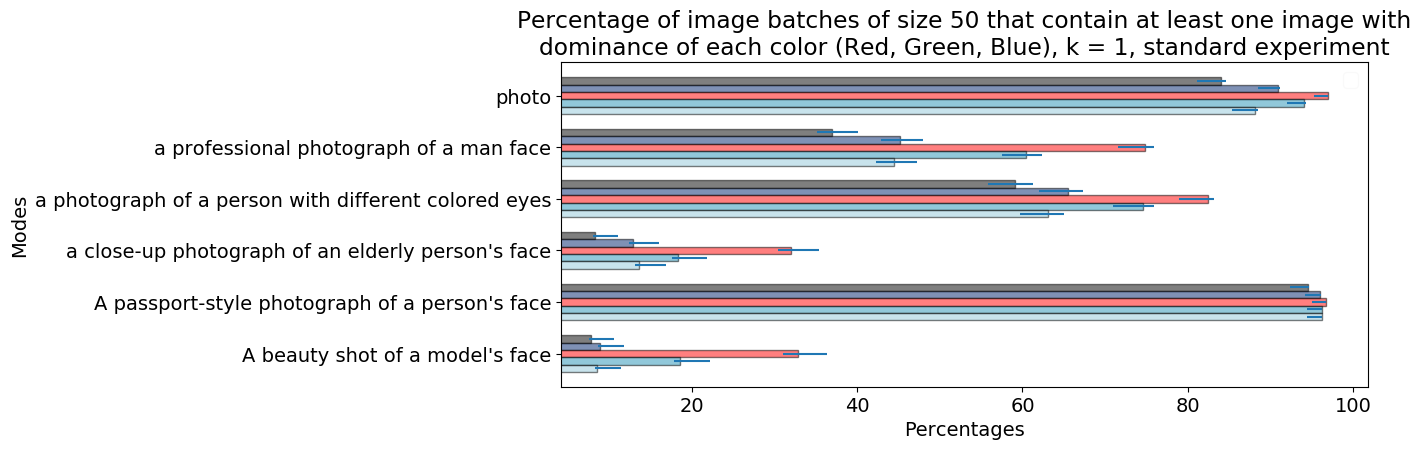

In [1179]:
get_graph(prompt_dic_50, prompt_dic_50_num, lf_50, len(list(modes)), modes, sd = None,
          title = "Percentage of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue), k = " + str(k), updated_experiment = False )

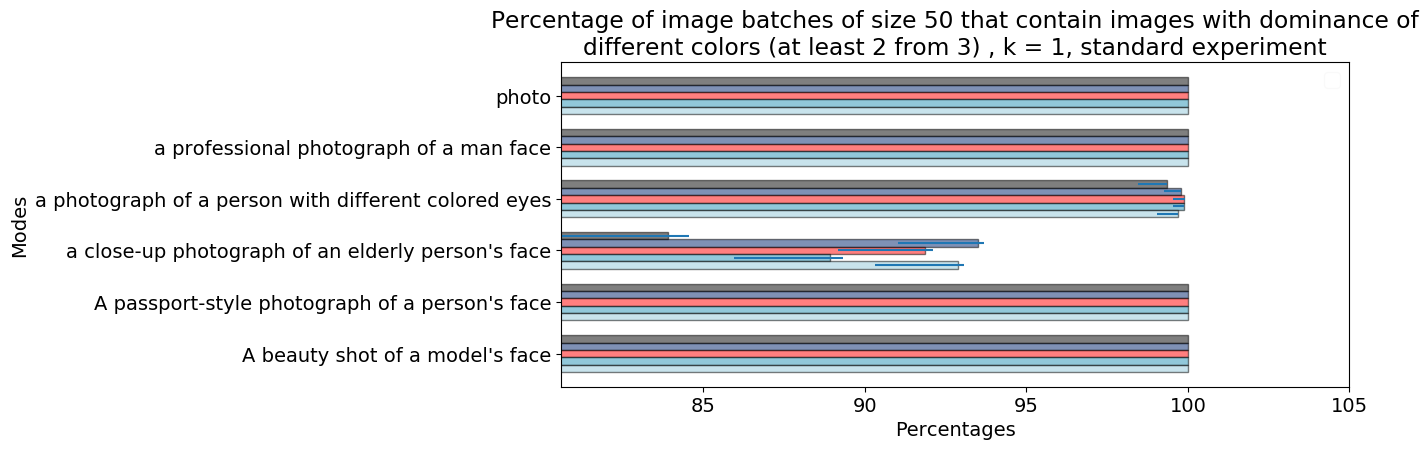

In [1178]:
get_graph(prompt_dic_50_ss, prompt_dic_50_num, lf_50, len(list(modes)), modes, sd = None,
          title = "Percentage of image batches of size 50 that contain images with dominance of different colors (at least 2 from 3) , k = " + str(k), updated_experiment = False )